In [1]:
# Step 1 - Setup Environment and Import Libraries
import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

# Configure logging
logging.basicConfig(
    filename=os.path.join(os.getcwd(), "analysis.log"),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

BASE_DIR = os.getcwd()  # Simplified for Jupyter
CACHE_DIR = os.getenv("FASTF1_CACHE_DIR", os.path.join(BASE_DIR, "fastf1_cache"))
HISTORICAL_CACHE_DIR = os.getenv("HISTORICAL_CACHE_DIR", os.path.join(BASE_DIR, "historical_cache"))
try:
    os.makedirs(CACHE_DIR, exist_ok=True)
    os.makedirs(HISTORICAL_CACHE_DIR, exist_ok=True)
except OSError as e:
    logger.error(f"Failed to create cache directory at {CACHE_DIR} or {HISTORICAL_CACHE_DIR}: {e}")
    raise RuntimeError(f"Failed to create cache directory: {e}")

fastf1.set_log_level('ERROR')
fastf1.Cache.enable_cache(CACHE_DIR)

if os.getenv("SILENT", "false").lower() != "true":
    print("Library Versions:")
    print(f"FastF1: {fastf1.__version__}")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Matplotlib: {plt.matplotlib.__version__}")
    print(f"\nCache Directory: {os.path.abspath(CACHE_DIR)}")
    print(f"Historical Cache Directory: {os.path.abspath(HISTORICAL_CACHE_DIR)}")
    print(f"Cache Directory Exists: {os.path.exists(CACHE_DIR)}")
    print(f"Historical Cache Directory Exists: {os.path.exists(HISTORICAL_CACHE_DIR)}")
    print(f"Current Date: {datetime.now().strftime('%Y-%m-%d')}")
    logger.info("Environment setup completed successfully.")

# Why: Sets up the environment with necessary libraries and caching for F1 data analysis.
# How to Read: Displays library versions and cache status to confirm setup.
# Expected Inputs: None
# Expected Outputs: Console confirmation of setup
# Data Exported: analysis.log (optional log file)

Library Versions:
FastF1: 3.5.0
Pandas: 2.2.3
NumPy: 1.26.4
Matplotlib: 3.10.0

Cache Directory: C:\data\Dropbox\dev\F1\fastf1_cache
Historical Cache Directory: C:\data\Dropbox\dev\F1\historical_cache
Cache Directory Exists: True
Historical Cache Directory Exists: True
Current Date: 2025-03-18


In [2]:
# Step 2 - Determine the Target Race and Sessions
# Objective: Dynamically determine the target race, its session types, historical performance, and track metadata.

import fastf1
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display
import os
import logging

logger = logging.getLogger(__name__)

def get_target_event(manual_year=None, manual_round=None, skip_timing_validation=False):
    current_date = datetime.utcnow()
    year = manual_year if manual_year is not None else current_date.year
    schedule = fastf1.get_event_schedule(year)
    print(f"Total Events in {year} Schedule: {len(schedule)}")
    logger.info(f"Fetched {year} schedule with {len(schedule)} events.")

    if manual_round is not None and manual_year is not None:
        target_event = schedule[schedule['RoundNumber'] == manual_round].iloc[0]
    else:
        future_events = schedule[schedule['EventDate'] >= current_date - timedelta(days=7)]
        target_event = future_events.iloc[0] if not future_events.empty else schedule.iloc[-1]

    round_number = target_event['RoundNumber']
    event_name = target_event['EventName']
    event_date = target_event['EventDate'].strftime('%Y-%m-%d')
    is_sprint = 'sprint' in target_event['EventFormat'].lower()
    location = target_event['Location']

    session_types = []
    session_dates = {}
    for session in ['Session1', 'Session2', 'Session3']:
        session_name = target_event[session]
        if session_name in ['Practice 1', 'Practice 2', 'Practice 3', 'Sprint Qualifying', 'Sprint']:
            session_types.append(session_name)
            session_dates[session_name] = target_event[f"{session}DateUtc"]
    if not session_types or session_types[-1] not in ['Practice 3', 'Sprint']:
        logger.error(f"No valid final session found for {event_name}")
        raise ValueError(f"No valid final session found for {event_name}")

    if not skip_timing_validation:
        final_session_name = session_types[-1]
        final_session_end = session_dates[final_session_name]
        qualifying_date_key = 'Session4DateUtc' if not is_sprint else 'Session5DateUtc'
        qualifying_start = target_event[qualifying_date_key] if qualifying_date_key in target_event else None
        if final_session_end and current_date < final_session_end:
            logger.warning(f"Current time {current_date} is before {final_session_name} end {final_session_end}.")
            raise ValueError(f"Analysis must run after {final_session_name}.")
        if qualifying_start and current_date > qualifying_start:
            logger.warning(f"Current time {current_date} is after Qualifying start {qualifying_start}.")
            raise ValueError("Analysis must run before Qualifying starts.")

    historical_winners = []
    historical_poles = []
    try:
        for past_year in range(year-3, year):
            past_schedule = fastf1.get_event_schedule(past_year)
            past_event = past_schedule[past_schedule['Location'] == location]
            if not past_event.empty:
                past_event = past_event.iloc[0]
                past_race = fastf1.get_session(past_year, past_event['RoundNumber'], 'R')
                past_race.load()
                past_qualifying = fastf1.get_session(past_year, past_event['RoundNumber'], 'Q')
                past_qualifying.load()
                winner = past_race.results.iloc[0]['Abbreviation']
                pole_sitter = past_qualifying.results.iloc[0]['Abbreviation']
                weight = 3 - (year - past_year)
                historical_winners.append((past_year, winner, weight))
                historical_poles.append((past_year, pole_sitter, weight))
    except Exception as e:
        logger.warning(f"Failed to fetch historical data for {location}: {e}")
        historical_winners = [("N/A", "Unknown", 1)]
        historical_poles = [("N/A", "Unknown", 1)]

    # Dynamic track metadata (placeholders; computed in a later cell)
    track_length = None  # From telemetry (e.g., FP1)
    avg_speed = None     # From lap times (e.g., FP1)
    downforce_level = None  # To be inferred from telemetry (e.g., corner count vs. straight speed)

    event_details = pd.DataFrame({
        'Round': [round_number],
        'Event Name': [event_name],
        'Event Date': [event_date],
        'Location': [location],
        'Sprint Weekend': [is_sprint],
        'Sessions': [', '.join(session_types)],
        'Track Length (km)': [track_length if track_length else 'TBD'],
        'Avg Speed (km/h)': [avg_speed if avg_speed else 'TBD'],
        'Downforce Level': [downforce_level if downforce_level else 'TBD']
    })

    historical_winners_df = pd.DataFrame(historical_winners, columns=['Year', 'Winner', 'Weight'])
    historical_poles_df = pd.DataFrame(historical_poles, columns=['Year', 'Pole Sitter', 'Weight'])

    print("\nTarget Event Details (Track data TBD until session loaded):")
    display(event_details)
    print("\nHistorical Winners at this Track:")
    display(historical_winners_df)
    print("\nHistorical Pole Sitters at this Track:")
    display(historical_poles_df)

    if os.getenv("SILENT", "false").lower() != "true":
        print("\nFull Event Row from Schedule:")
        print(target_event)

    result = {
        'year': year,
        'round': round_number,
        'session_types': session_types,
        'event_name': event_name,
        'event_date': event_date,
        'location': location,
        'historical_winners': historical_winners,
        'historical_poles': historical_poles,
        'track_length': track_length,
        'avg_speed': avg_speed,
        'downforce_level': downforce_level
    }
    print("Debug - Step 2 result:", result)
    logger.info(f"Target event selected: {event_name} (Round {round_number}) with sessions {session_types}")
    return result

target_info = get_target_event(manual_year=2024, manual_round=3, skip_timing_validation=True)

# Why: Identifies the target race and sessions for pre-qualifying analysis with historical and track context.
# How to Read: Displays the selected race, its sessions, historical performance with weights, and track metadata (TBD until computed) to inform predictions.
# Expected Inputs: Optional manual_year, manual_round, skip_timing_validation
# Expected Outputs: Event schedule length, event details table (track data TBD), historical data with weights, full event row, structured result
# Data Exported: Dictionary with race and session details, track data placeholders

Total Events in 2024 Schedule: 25

Target Event Details (Track data TBD until session loaded):


,Round,Event Name,Event Date,Location,Sprint Weekend,Sessions,Track Length (km),Avg Speed (km/h),Downforce Level
0,3,Australian Grand Prix,2024-03-24,Melbourne,False,"Practice 1, Practice 2, Practice 3",TBD,TBD,TBD



Historical Winners at this Track:


,Year,Winner,Weight
0,2022,LEC,1
1,2023,VER,2



Historical Pole Sitters at this Track:


,Year,Pole Sitter,Weight
0,2022,LEC,1
1,2023,VER,2



Full Event Row from Schedule:
RoundNumber                                                   3
Country                                               Australia
Location                                              Melbourne
OfficialEventName    FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2024
EventDate                                   2024-03-24 00:00:00
EventName                                 Australian Grand Prix
EventFormat                                        conventional
Session1                                             Practice 1
Session1Date                          2024-03-22 12:30:00+11:00
Session1DateUtc                             2024-03-22 01:30:00
Session2                                             Practice 2
Session2Date                          2024-03-22 16:00:00+11:00
Session2DateUtc                             2024-03-22 05:00:00
Session3                                             Practice 3
Session3Date                          2024-03-23 12:30:00+11:00
Session3D

In [3]:
# Step 3 - Download Practice Session Data
# Objective: Retrieve data for all practice sessions, extract key indicators, compute track metadata, save as CSV, and preview for verification.

import fastf1
import pandas as pd
import numpy as np
import os
from IPython.display import display
import logging

logger = logging.getLogger(__name__)

def download_practice_data(target_info):
    year = target_info['year']
    round_number = target_info['round']
    session_labels = target_info['session_types']
    event_name = target_info['event_name']

    # Directory to save raw data (structured as raw_data/{year}/R{round_number}/)
    BASE_DIR = os.getcwd()
    data_dir = os.path.join(BASE_DIR, "raw_data", str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)  # Ensure directory exists

    # Debug: Verify event schedule
    schedule = fastf1.get_event_schedule(year)
    print(f"Debug - {year} Schedule Length: {len(schedule)}")
    event = schedule[schedule['RoundNumber'] == round_number]
    if event.empty:
        raise ValueError(f"No event found for Round {round_number} in {year}. Available rounds: {schedule['RoundNumber'].tolist()}")
    print(f"Debug - Selected Event: {event['EventName'].iloc[0]} (Round {round_number})")

    # Dictionary to store session data
    session_data = {}

    # Compute track metadata using FP1
    try:
        fp1_session = fastf1.get_session(year, event_name, 'FP1')
        fp1_session.load(telemetry=True)
        # Use accurate, full laps for track length
        valid_laps = fp1_session.laps[fp1_session.laps['IsAccurate'] & fp1_session.laps['LapTime'].notna()]
        top_laps = valid_laps.nlargest(5, 'LapTime')  # Top 5 accurate laps
        lap_lengths = []
        for _, lap in top_laps.iterrows():
            telemetry = lap.get_telemetry()
            lap_length = (telemetry['Distance'].max() - telemetry['Distance'].min()) / 1000  # km
            lap_lengths.append(lap_length)
        track_length = np.mean(lap_lengths)  # Average for consistency
        target_info['track_length'] = track_length

        # Average speed: based on fastest lap and computed track length
        fastest_lap = fp1_session.laps.pick_fastest()
        lap_time_seconds = fastest_lap['LapTime'].total_seconds()
        avg_speed = (track_length / (lap_time_seconds / 3600))  # km/h
        target_info['avg_speed'] = avg_speed

        # Downforce level (heuristic)
        telemetry = fastest_lap.get_telemetry()
        speeds = telemetry['Speed']
        top_speed = speeds.max()
        corner_speeds = speeds[telemetry['Throttle'] < 90]  # Proxy for corners
        avg_corner_speed = corner_speeds.mean() if not corner_speeds.empty else top_speed / 2
        corner_to_straight_ratio = avg_corner_speed / top_speed
        circuit_info = fp1_session.get_circuit_info()
        corner_count = len(circuit_info.corners)
        if corner_count > 15 and corner_to_straight_ratio > 0.7:
            downforce_level = 'High'
        elif corner_count > 10 and corner_to_straight_ratio > 0.5:
            downforce_level = 'Medium-High'
        elif corner_count > 5 and corner_to_straight_ratio > 0.3:
            downforce_level = 'Medium'
        else:
            downforce_level = 'Low'
        target_info['downforce_level'] = downforce_level

        print(f"\nComputed Track Metadata (from FP1):")
        print(f"Track Length: {track_length:.3f} km")
        print(f"Average Speed: {avg_speed:.1f} km/h")
        print(f"Downforce Level: {downforce_level}")
    except Exception as e:
        logger.error(f"Failed to compute track metadata: {e}")
        print(f"Warning: Track metadata computation failed: {e}")
        target_info['track_length'] = target_info.get('track_length', 'TBD')
        target_info['avg_speed'] = target_info.get('avg_speed', 'TBD')
        target_info['downforce_level'] = target_info.get('downforce_level', 'TBD')

    # Download and process each session
    for session_num, session_label in enumerate(session_labels, start=1):
        print(f"\nDownloading Session {session_num} ({session_label}) data...")
        session = fastf1.get_session(year, event_name, session_label)
        session.load(telemetry=True)
        logger.info(f"Loaded data for {session_label} with {len(session.laps)} laps.")

        # Extract lap data
        laps = session.laps
        session_data[session_label] = {'laps': laps}

        # Save lap data
        file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_laps.csv")
        laps.to_csv(file_path, index=False)
        print(f"Saved {session_label} lap data to {file_path}")

        # Extract weather data
        weather = session.weather_data
        session_data[session_label]['weather'] = weather
        weather_file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_weather.csv")
        weather.to_csv(weather_file_path, index=False)
        print(f"Saved {session_label} weather data to {weather_file_path}")

        # Compute indicators
        fastest_laps = laps.groupby('Driver')['LapTime'].min().reset_index()
        avg_lap_times = laps.groupby('Driver')['LapTime'].mean().reset_index().rename(columns={'LapTime': 'AvgLapTime'})
        tyre_degradation = laps[laps['Compound'].notna() & laps['TyreLife'].notna()]
        tyre_degradation = tyre_degradation.groupby(['Driver', 'Stint']).agg({
            'LapTime': lambda x: x.mean().total_seconds() if not x.empty else np.nan,
            'TyreLife': 'mean'
        }).reset_index()
        # Refined degradation rate: tighter clip and fill NaN
        tyre_degradation['DegradationRate'] = (
            tyre_degradation.groupby('Driver')
            .apply(lambda x: (x['LapTime'].diff() / x['TyreLife'].diff()).replace([np.inf, -np.inf], 0).clip(lower=-0.1, upper=0.1), include_groups=False)
            .reset_index(drop=True)
        )
        tyre_degradation = tyre_degradation.groupby('Driver')['DegradationRate'].mean().fillna(0).reset_index()
        indicators = fastest_laps.merge(avg_lap_times, on='Driver').merge(tyre_degradation, on='Driver', how='left')
        session_data[session_label]['indicators'] = indicators
        indicators_file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_indicators.csv")
        indicators.to_csv(indicators_file_path, index=False)
        print(f"Saved {session_label} indicators to {indicators_file_path}")

        # Preview data
        if os.getenv("SILENT", "false").lower() != "true":
            print(f"\n{session_label} Lap Data Preview (first 5 rows):")
            display(laps.head())
            print(f"\n{session_label} Weather Data Preview (first 5 rows):")
            display(weather.head())
            print(f"\n{session_label} Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):")
            display(indicators)

    # Summary
    if os.getenv("SILENT", "false").lower() != "true":
        print("\nDownload Summary:")
        for session_label, data in session_data.items():
            print(f"{session_label}: {len(data['laps'])} laps, Columns: {list(data['laps'].columns)}")
            print(f"  Weather: {len(data['weather'])} records")
            print(f"  Indicators: {len(data['indicators'])} drivers")

    return session_data

# Example usage
session_data = download_practice_data(target_info)

# Expected Inputs: target_info dict from Step 2 (year, round, session_types, event_name)
# Expected Outputs: Track metadata, download confirmations, file paths, data previews, summary (unless SILENT=true)
# Data Exported: CSV files for each session (laps, weather, indicators) in 'raw_data', updated target_info

Debug - 2024 Schedule Length: 25
Debug - Selected Event: Australian Grand Prix (Round 3)

Computed Track Metadata (from FP1):
Track Length: 5.230 km
Average Speed: 239.7 km/h
Downforce Level: Medium-High

Saved Practice 1 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_1_laps.csv
Saved Practice 1 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_1_weather.csv
Saved Practice 1 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:20:26.552000,VER,1,0 days 00:01:47.251000,1.0,1.0,0 days 00:18:41.444000,NaT,0 days 00:00:38.110000,0 days 00:00:19.684000,...,True,Red Bull Racing,0 days 00:18:41.444000,2024-03-22 01:33:42.227,1,NaN,False,,False,False
1,0 days 00:21:47.902000,VER,1,0 days 00:01:21.350000,2.0,1.0,NaT,NaT,0 days 00:00:28.462000,0 days 00:00:18.219000,...,True,Red Bull Racing,0 days 00:20:26.552000,2024-03-22 01:35:27.335,1,NaN,False,,False,True
2,0 days 00:24:04.063000,VER,1,0 days 00:02:16.161000,3.0,1.0,NaT,0 days 00:23:45.557000,0 days 00:00:47.813000,0 days 00:00:25.644000,...,True,Red Bull Racing,0 days 00:21:47.902000,2024-03-22 01:36:48.685,1,NaN,False,,False,False
3,0 days 00:25:53.063000,VER,1,0 days 00:01:49,4.0,2.0,0 days 00:24:06.156000,NaT,0 days 00:00:38.560000,0 days 00:00:21.725000,...,False,Red Bull Racing,0 days 00:24:04.063000,2024-03-22 01:39:04.846,1,NaN,False,,False,False
4,0 days 00:27:12.763000,VER,1,0 days 00:01:19.700000,5.0,2.0,NaT,NaT,0 days 00:00:27.886000,0 days 00:00:17.904000,...,False,Red Bull Racing,0 days 00:25:53.063000,2024-03-22 01:40:53.846,1,NaN,False,,False,True



Practice 1 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:38.815000,18.0,63.0,1023.7,False,30.2,156,1.0
1,0 days 00:01:38.824000,18.1,63.0,1023.9,False,30.4,126,1.0
2,0 days 00:02:38.835000,18.1,62.0,1023.9,False,29.9,20,1.4
3,0 days 00:03:38.816000,18.1,63.0,1023.9,False,29.9,158,0.8
4,0 days 00:04:38.819000,18.0,64.0,1023.9,False,30.2,0,0.8



Practice 1 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:19.443000,0 days 00:01:37.169555555,-0.100000
1,ALO,0 days 00:01:19.716000,0 days 00:01:36.531250,-0.033333
2,BOT,0 days 00:01:20.014000,0 days 00:01:37.655125,0.000000
3,GAS,0 days 00:01:19.622000,0 days 00:01:37.282000,-0.100000
4,HAM,0 days 00:01:18.771000,0 days 00:01:41.378812500,-0.100000
5,HUL,0 days 00:01:19.604000,0 days 00:01:36.399705882,-0.100000
6,LEC,0 days 00:01:18.599000,0 days 00:01:40.472166666,0.033333
7,MAG,0 days 00:01:19.489000,0 days 00:01:40.568444444,-0.100000
8,NOR,0 days 00:01:18.564000,0 days 00:01:38.280894736,0.100000
9,OCO,0 days 00:01:19.561000,0 days 00:01:38.959571428,-0.100000



Saved Practice 2 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_2_laps.csv
Saved Practice 2 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_2_weather.csv
Saved Practice 2 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_2_indicators.csv

Practice 2 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:39:17.840000,VER,1,0 days 00:01:39.005000,1.0,1.0,0 days 00:37:40.858000,NaT,0 days 00:00:36.602000,0 days 00:00:19.406000,...,True,Red Bull Racing,0 days 00:37:40.858000,2024-03-22 05:22:41.576,1,NaN,False,,False,False
1,0 days 00:40:37.688000,VER,1,0 days 00:01:19.848000,2.0,1.0,NaT,NaT,0 days 00:00:27.334000,0 days 00:00:17.924000,...,True,Red Bull Racing,0 days 00:39:17.840000,2024-03-22 05:24:18.558,1,NaN,False,,False,True
2,0 days 00:42:32.333000,VER,1,0 days 00:01:54.645000,3.0,1.0,NaT,NaT,0 days 00:00:45.426000,0 days 00:00:27.462000,...,True,Red Bull Racing,0 days 00:40:37.688000,2024-03-22 05:25:38.406,1,NaN,False,,False,True
3,0 days 00:44:07.588000,VER,1,0 days 00:01:35.255000,4.0,1.0,NaT,NaT,0 days 00:00:30.429000,0 days 00:00:21.100000,...,True,Red Bull Racing,0 days 00:42:32.333000,2024-03-22 05:27:33.051,1,NaN,False,,False,True
4,0 days 00:45:25.908000,VER,1,0 days 00:01:18.320000,5.0,1.0,NaT,NaT,0 days 00:00:27.065000,0 days 00:00:17.795000,...,True,Red Bull Racing,0 days 00:44:07.588000,2024-03-22 05:29:08.306,1,NaN,False,,False,True



Practice 2 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:39.528000,20.2,55.0,1022.1,False,37.7,161,1.8
1,0 days 00:01:39.532000,20.1,55.0,1022.1,False,37.5,118,1.7
2,0 days 00:02:39.539000,20.1,55.0,1022.0,False,38.0,148,1.9
3,0 days 00:03:39.530000,20.1,55.0,1022.0,False,38.3,170,2.7
4,0 days 00:04:39.535000,20.1,56.0,1022.1,False,38.0,254,1.4



Practice 2 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALO,0 days 00:01:17.912000,0 days 00:01:32.425178571,-0.033333
1,BOT,0 days 00:01:18.585000,0 days 00:01:32.629000,-0.050000
2,GAS,0 days 00:01:18.691000,0 days 00:01:31.728965517,0.033333
3,HAM,0 days 00:01:18.834000,0 days 00:01:41.170000,0.033333
4,HUL,0 days 00:01:18.702000,0 days 00:01:33.709416666,-0.050000
5,LEC,0 days 00:01:17.277000,0 days 00:01:38.340521739,-0.100000
6,MAG,0 days 00:01:19.275000,0 days 00:01:34.763714285,-0.100000
7,NOR,0 days 00:01:18.155000,0 days 00:01:32.962315789,0.033333
8,OCO,0 days 00:01:18.705000,0 days 00:01:32.434321428,-0.050000
9,PER,0 days 00:01:18.090000,0 days 00:01:34.332071428,-0.050000



Saved Practice 3 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_3_laps.csv
Saved Practice 3 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_3_weather.csv
Saved Practice 3 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_Practice_3_indicators.csv

Practice 3 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:20:18.255000,VER,1,0 days 00:01:34.499000,1.0,1.0,0 days 00:18:45.843000,NaT,0 days 00:00:37.930000,0 days 00:00:19.606000,...,True,Red Bull Racing,0 days 00:18:45.843000,2024-03-23 01:33:47.943,1,NaN,False,,False,False
1,0 days 00:21:52.490000,VER,1,0 days 00:01:34.235000,2.0,1.0,NaT,NaT,0 days 00:00:31.497000,0 days 00:00:23.323000,...,True,Red Bull Racing,0 days 00:20:18.255000,2024-03-23 01:35:20.355,1,NaN,False,,False,True
2,0 days 00:23:11.081000,VER,1,0 days 00:01:18.591000,3.0,1.0,NaT,NaT,0 days 00:00:27.351000,0 days 00:00:17.814000,...,True,Red Bull Racing,0 days 00:21:52.490000,2024-03-23 01:36:54.590,1,NaN,False,,False,True
3,0 days 00:25:05.771000,VER,1,0 days 00:01:54.690000,4.0,1.0,NaT,NaT,0 days 00:00:44.667000,0 days 00:00:29.892000,...,True,Red Bull Racing,0 days 00:23:11.081000,2024-03-23 01:38:13.181,1,NaN,False,,False,True
4,0 days 00:26:23.281000,VER,1,0 days 00:01:17.510000,5.0,1.0,NaT,NaT,0 days 00:00:26.983000,0 days 00:00:17.524000,...,True,Red Bull Racing,0 days 00:25:05.771000,2024-03-23 01:40:07.871,1,NaN,False,,False,True



Practice 3 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:43.470000,18.0,60.0,1025.6,False,25.6,125,2.0
1,0 days 00:01:43.481000,18.0,61.0,1025.5,False,25.3,144,2.0
2,0 days 00:02:43.479000,18.0,61.0,1025.5,False,25.2,167,2.2
3,0 days 00:03:43.487000,18.0,61.0,1025.5,False,25.3,146,1.6
4,0 days 00:04:43.489000,18.0,62.0,1025.5,False,25.7,173,2.8



Practice 3 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:17.759000,0 days 00:01:38.846900,-0.033333
1,ALO,0 days 00:01:16.997000,0 days 00:01:40.397437500,0.050000
2,BOT,0 days 00:01:17.752000,0 days 00:01:41.331062500,0.100000
3,GAS,0 days 00:01:18.390000,0 days 00:01:34.866625,0.100000
4,HAM,0 days 00:01:16.806000,0 days 00:01:40.639733333,0.000000
5,HUL,0 days 00:01:17.941000,0 days 00:01:40.477071428,0.100000
6,LEC,0 days 00:01:16.714000,0 days 00:01:43.341055555,0.033333
7,MAG,0 days 00:01:17.961000,0 days 00:01:40.553066666,0.100000
8,NOR,0 days 00:01:17.490000,0 days 00:01:36.091277777,-0.100000
9,OCO,0 days 00:01:17.920000,0 days 00:01:36.499312500,0.100000



Download Summary:
Practice 1: 436 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weather: 81 records
  Indicators: 20 drivers
Practice 2: 532 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weat

In [4]:
# Step 4 - Clean and Aggregate Practice Data
# Objective: Clean lap data, aggregate driver stats across sessions, and prepare for predictions.

import pandas as pd
import os
from IPython.display import display
import logging

logger = logging.getLogger(__name__)

def clean_and_aggregate_data(target_info, session_data):
    year = target_info['year']
    round_number = target_info['round']
    session_types = target_info['session_types']
    BASE_DIR = os.getcwd()  # Jupyter-friendly
    DATA_DIR = os.path.join(BASE_DIR, "raw_data", str(year), f"R{round_number}")
    CLEANED_DIR = os.path.join(DATA_DIR, "cleaned_data")
    os.makedirs(CLEANED_DIR, exist_ok=True)

    if not session_data:
        logger.error("No session data provided from Step 3.")
        return {}, pd.DataFrame()

    cleaned_data = {}
    driver_summary = []
    total_raw_laps = 0
    total_cleaned_laps = 0

    for session_type, data in session_data.items():
        logger.info(f"Cleaning {session_type} data...")
        laps = data['laps']  # Use laps from session_data
        if laps.empty:
            logger.warning(f"{session_type} data is empty.")
            continue
        total_raw_laps += len(laps)
        logger.info(f"Raw Laps in {session_type}: {len(laps)}")

        # Clean laps: remove deleted, use accurate laps, drop incomplete
        clean_laps = laps[(laps['Deleted'] == False) & (laps['IsAccurate'] == True)].copy()
        logger.info(f"After Deleting Removed/Keeping Accurate: {len(clean_laps)}")
        clean_laps = clean_laps.dropna(subset=['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'], how='all')
        logger.info(f"After Dropping Fully NaN Laps: {len(clean_laps)}")

        # Convert LapTime to seconds
        clean_laps['LapTimeSeconds'] = pd.to_timedelta(clean_laps['LapTime'], errors='coerce').dt.total_seconds()
        clean_laps = clean_laps[clean_laps['LapTimeSeconds'].notna() & (clean_laps['LapTimeSeconds'] > 0)]
        total_cleaned_laps += len(clean_laps)

        # Filter outliers and pit laps for average lap time
        clean_for_avg = clean_laps[
            (clean_laps['PitInTime'].isna()) &
            (clean_laps['PitOutTime'].isna())
        ]
        driver_medians = clean_for_avg.groupby('Driver')['LapTimeSeconds'].median()
        clean_for_avg = clean_for_avg.merge(driver_medians, on='Driver', suffixes=('', '_Median'))
        clean_for_avg = clean_for_avg[clean_for_avg['LapTimeSeconds'] <= clean_for_avg['LapTimeSeconds_Median'] * 1.3].drop(columns=['LapTimeSeconds_Median'])
        logger.info(f"Laps for AvgLapTime (After Pit/Outlier Filter): {len(clean_for_avg)}")

        # Store cleaned data
        cleaned_data[session_type] = clean_laps

        # Driver stats per session
        driver_stats = clean_for_avg.groupby('Driver').agg({
            'LapTimeSeconds': ['min', 'mean', 'std', 'count']
        }).reset_index()
        driver_stats.columns = ['Driver', 'FastestLap', 'AvgLapTime', 'LapTimeStd', 'LapCount']
        driver_stats['Session'] = session_type
        driver_summary.append(driver_stats)

        # Save cleaned laps
        cleaned_file = os.path.join(CLEANED_DIR, f"{year}_R{round_number}_{session_type.replace(' ', '_')}_cleaned_laps.csv")
        clean_laps.to_csv(cleaned_file, index=False)
        logger.info(f"Saved cleaned laps to {cleaned_file}")

    if not driver_summary:
        logger.error("No driver data aggregated.")
        overall_summary = pd.DataFrame()
    else:
        all_driver_summary = pd.concat(driver_summary, ignore_index=True)
        overall_summary = all_driver_summary.groupby('Driver').agg({
            'FastestLap': 'min',
            'AvgLapTime': 'mean',
            'LapTimeStd': 'mean',
            'LapCount': 'sum'
        }).reset_index()
        overall_summary = overall_summary.sort_values('FastestLap')
        if os.getenv("SILENT", "false").lower() != "true":
            logger.info(f"Total Raw Laps: {total_raw_laps}")
            logger.info(f"Total Cleaned Laps: {total_cleaned_laps}")
            logger.info("Driver Summary Generated (Top 5):")
            print(overall_summary.head().to_string(index=False))
            logger.info("Full Overall Driver Summary:")
            display(overall_summary)

    output_file = os.path.join(CLEANED_DIR, f"{year}_R{round_number}_practice_summary.csv")
    overall_summary.to_csv(output_file, index=False)
    logger.info(f"Saved aggregated practice summary to {output_file}")

    logger.info(f"Cleaned data keys: {list(cleaned_data.keys())}")
    return cleaned_data, overall_summary

# Example usage
cleaned_data, driver_summary = clean_and_aggregate_data(target_info, session_data)

# Why: Cleans raw lap data and aggregates driver performance stats for prediction.
# How to Read: Shows cleaned lap counts, driver stats per session, and an overall summary sorted by fastest lap.
# Expected Inputs: target_info (year, round, session_types), session_data from Step 3
# Expected Outputs: Cleaned lap CSVs, practice summary CSV, previews of top 5 and full summary
# Data Exported: Cleaned laps per session, overall driver summary

Driver  FastestLap  AvgLapTime  LapTimeStd  LapCount
   LEC      76.714   85.846709    8.767190        35
   VER      76.734   81.320942    4.078265        31
   SAI      76.791   81.336680    4.418978        31
   HAM      76.806   82.794695    4.621315        26
   RUS      76.886   90.789498   11.812667        41


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
6,LEC,76.714,85.846709,8.767190,35
18,VER,76.734,81.320942,4.078265,31
14,SAI,76.791,81.336680,4.418978,31
4,HAM,76.806,82.794695,4.621315,26
13,RUS,76.886,90.789498,11.812667,41
1,ALO,76.997,84.203069,5.970172,34
10,PER,77.014,81.562402,3.503068,41
11,PIA,77.087,84.000937,6.533769,40
16,STR,77.341,82.883907,6.275978,40
8,NOR,77.490,84.086670,7.445181,36



Driver Performance (sorted by TheoreticalLapTime):


,Driver,FastestLapTime,TheoreticalLapTime,Sector1Time,Sector2Time,Sector3Time,BasePace,DegradationSlope,Team
6,LEC,76.714,76.625,26.638,17.434,32.553,83.866800,13.766667,Ferrari
14,SAI,76.791,76.646,26.558,17.584,32.504,83.331800,20.474855,Ferrari
18,VER,76.734,76.734,26.638,17.364,32.732,83.070100,7.121354,Red Bull Racing
4,HAM,76.806,76.742,26.627,17.484,32.631,83.147000,7.000000,Mercedes
13,RUS,76.886,76.831,26.548,17.581,32.702,83.595333,21.850000,Mercedes
1,ALO,76.997,76.997,26.652,17.467,32.878,84.389889,7.000000,Aston Martin
10,PER,77.014,77.014,26.783,17.417,32.814,83.598474,9.748750,Red Bull Racing
11,PIA,77.087,77.071,26.581,17.554,32.936,83.619077,19.980758,McLaren
16,STR,77.341,77.275,26.695,17.668,32.912,84.207800,30.961094,Aston Martin
8,NOR,77.490,77.330,26.582,17.690,33.058,83.302500,7.000000,McLaren


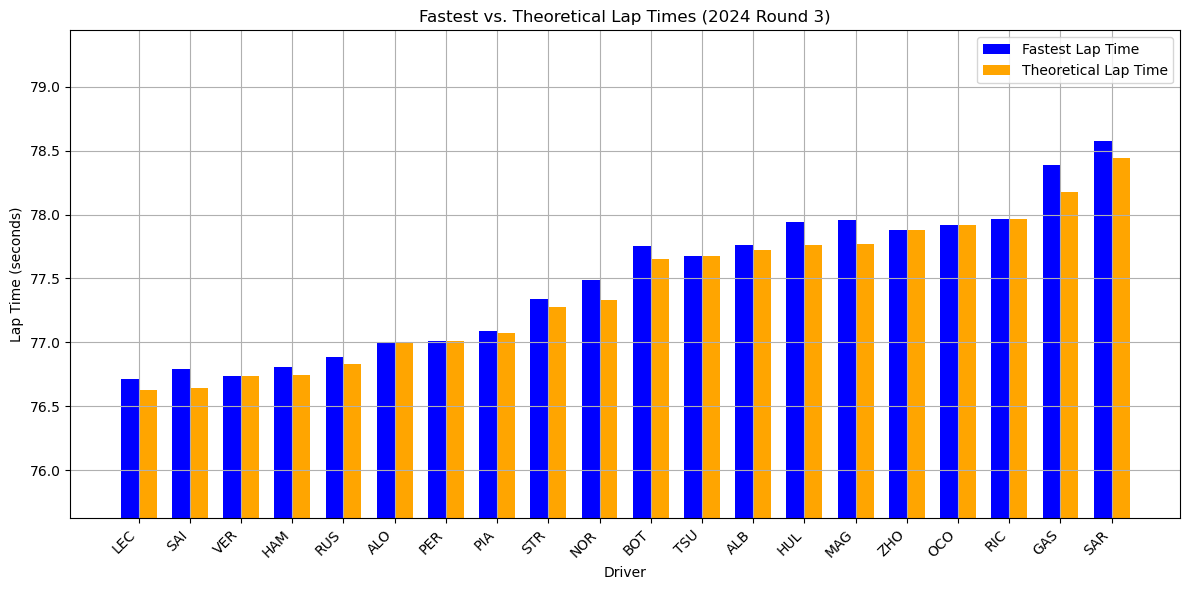

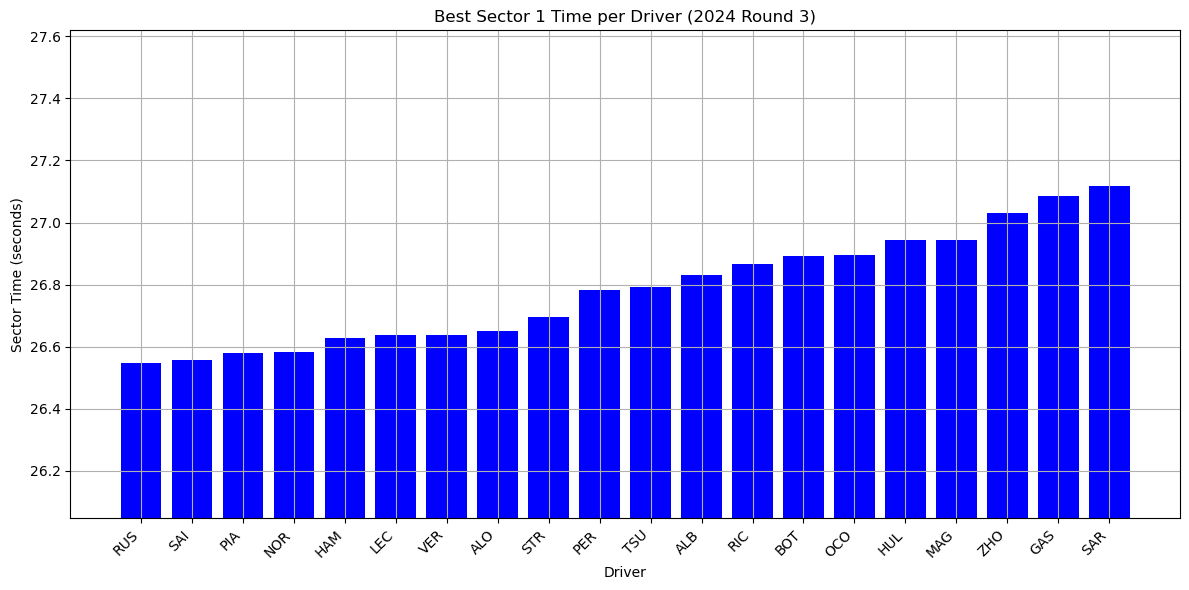

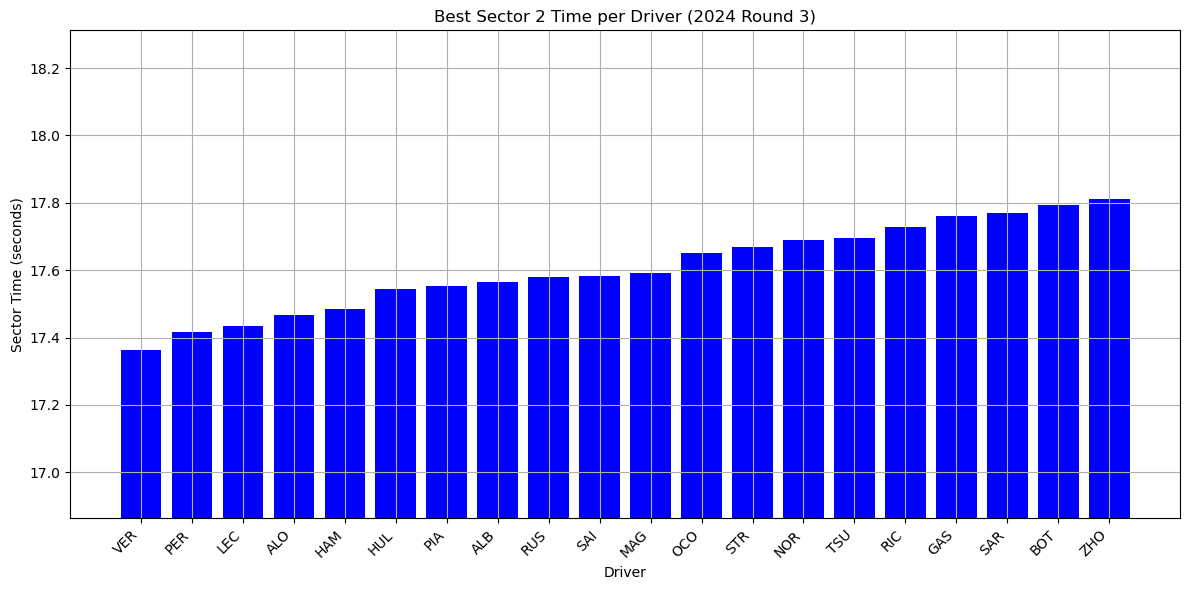

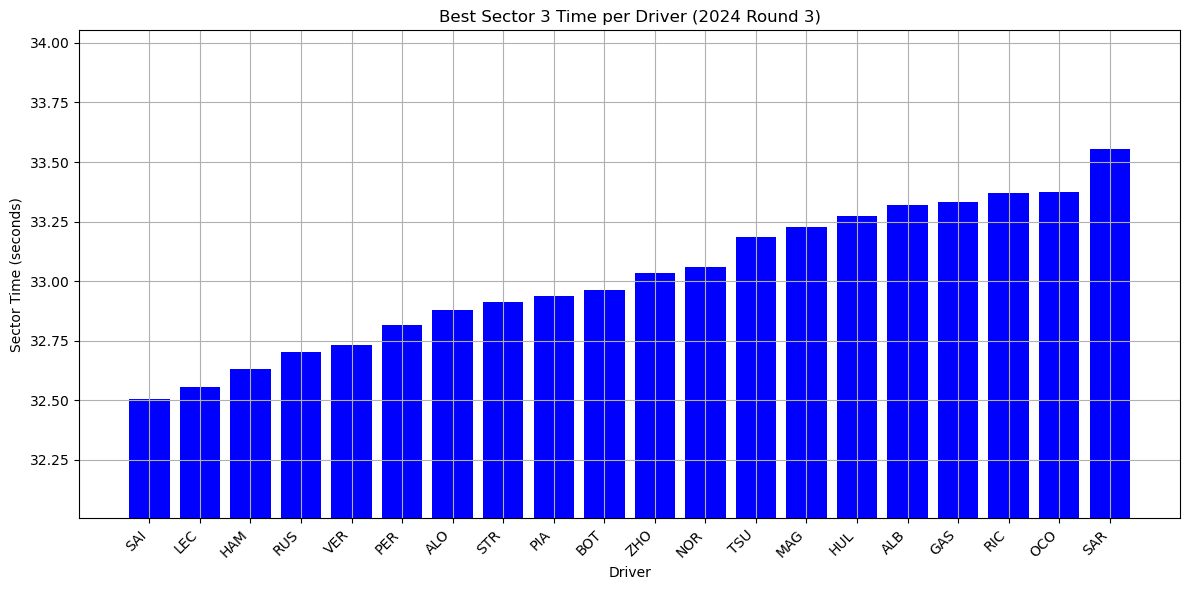

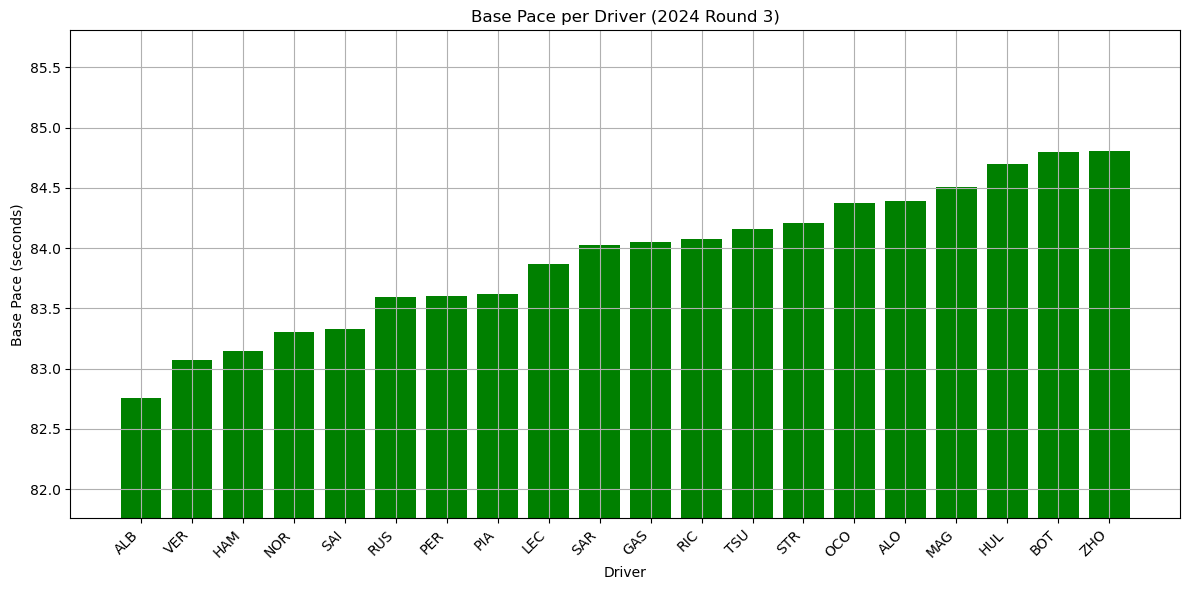

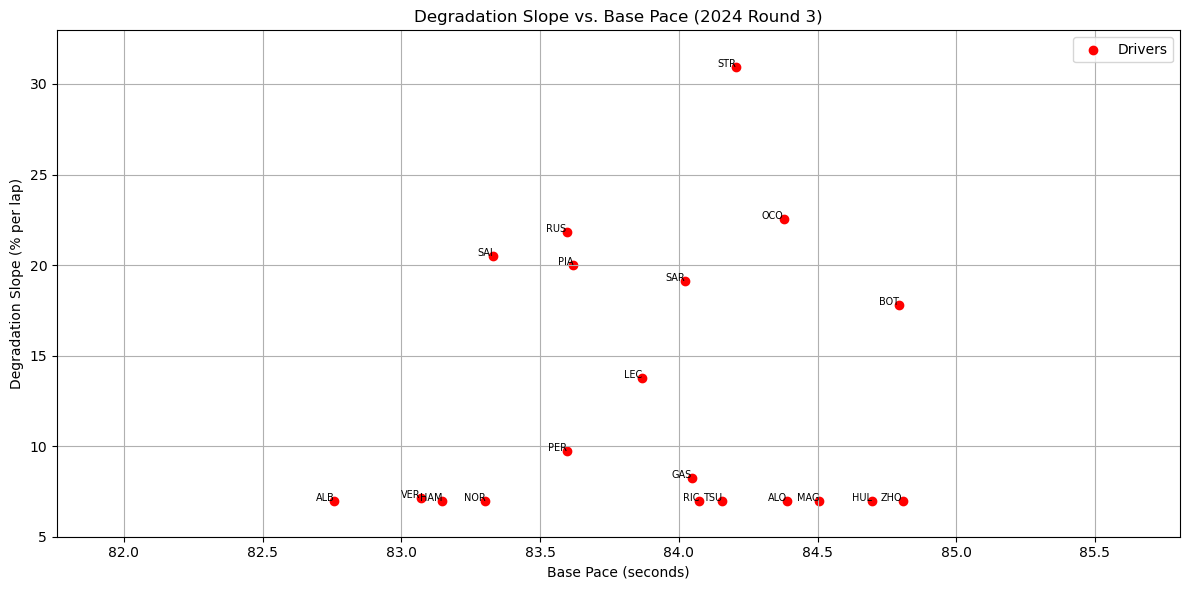

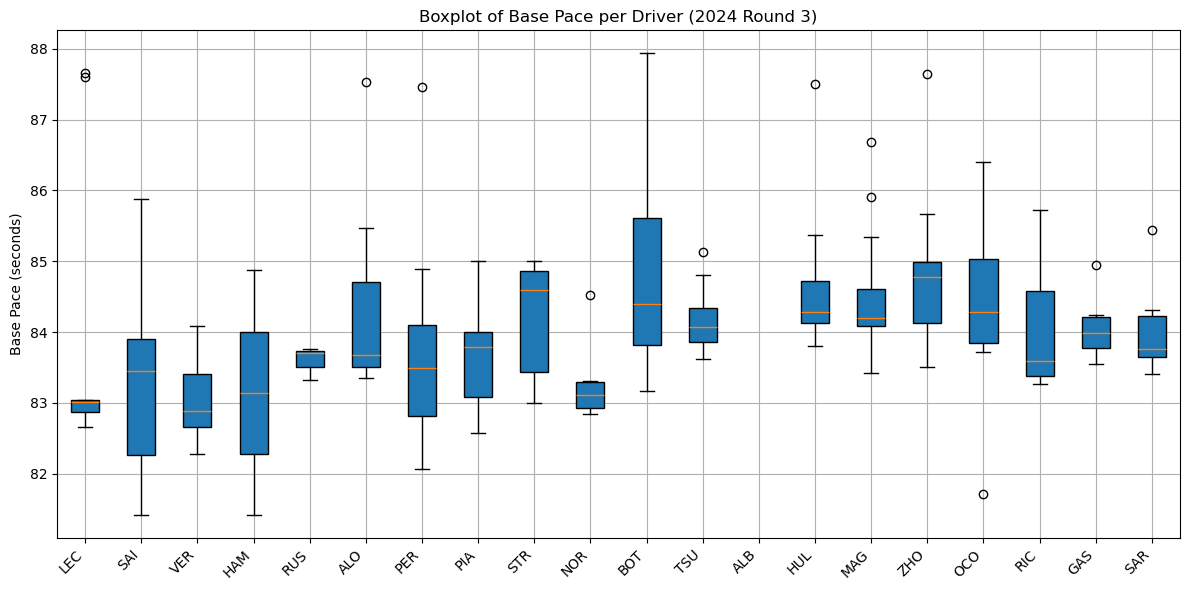


Debug: DegradationSlope values for plot: [13.766666666666401, 20.474854651162623, 7.1213541666664115, 7.0, 21.850000000000875, 7.0, 9.748750000000161, 19.98075801749226, 30.961094224923478, 7.0, 17.8030678148547, 7.0, 7.0, 7.0, 7.0, 7.0, 22.54358288770063, 7.0, 8.243333333333435, 19.09423076923064]


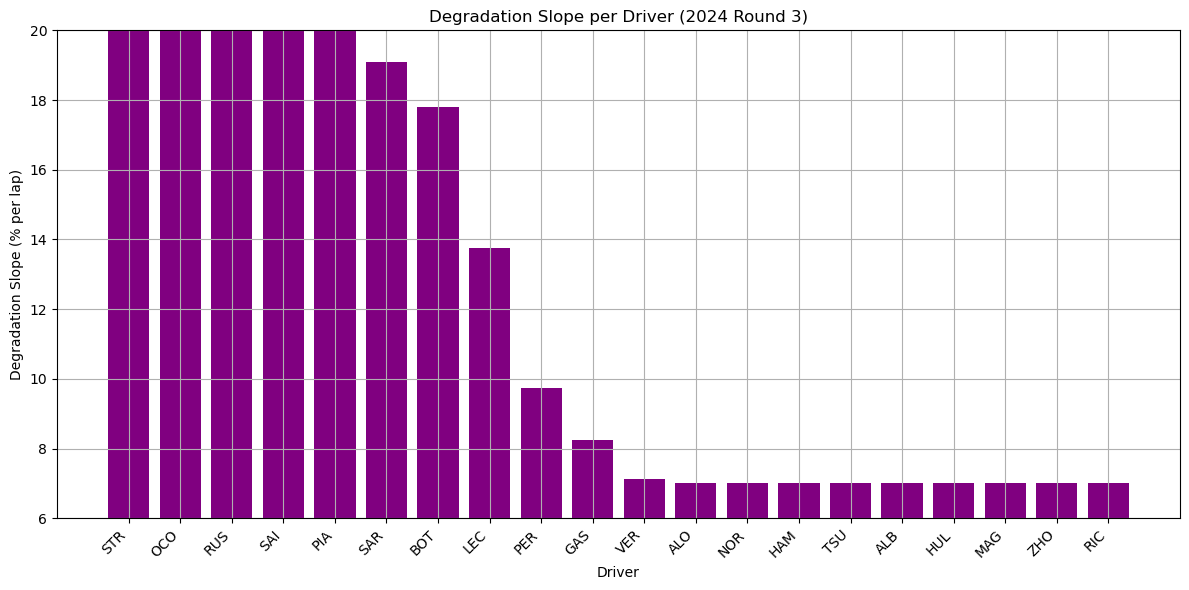


=== How to Read the Output ===
- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.
- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.
- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.
- **BasePace**: The average lap time on long runs (tyre life > 10 laps), reflecting race pace consistency.
- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation, higher values indicate faster tyre wear.
- **Boxplot of BasePace per Driver**: Shows the distribution of long-run lap times for each driver, with median, quartiles, and outliers indicating race pace consistency.
- **Bar Chart of DegradationSlope per Driver**: Displays the individual degradation 

In [5]:
# Step 5: Unified Driver Performance Analysis
# Objective: Compute fastest lap times, best sector times, base pace, variance, degradation slopes, and theoretical fastest lap, with visualizations and a dynamic conclusion.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_driver_performance(cleaned_data, year, round_number, data_dir="raw_data"):
    """
    Compute fastest lap times, best sector times, base pace, variance, degradation slopes, and theoretical fastest lap.

    Args:
        cleaned_data (dict): Cleaned lap DataFrames from Step 4
        year (int): Race year (e.g., 2024)
        round_number (int): Round number (e.g., 3)
        data_dir (str): Directory for output files (default: "raw_data")

    Returns:
        pd.DataFrame: Driver performance metrics
    """
    # Update data_dir to match the format raw_data/{year}/R{round_number}/
    data_dir = os.path.join(data_dir, str(year), f"R{round_number}")

    # Combine all practice sessions
    all_laps = pd.concat([cleaned_data[session] for session in cleaned_data.keys()], ignore_index=True)

    # Compute fastest lap time per driver
    fastest_laps = all_laps.groupby('Driver').agg({
        'LapTimeSeconds': 'min',
        'Team': 'first'
    }).reset_index()
    fastest_laps = fastest_laps.rename(columns={'LapTimeSeconds': 'FastestLapTime'})

    # Compute best sector times per driver
    all_laps['Sector1Time'] = pd.to_timedelta(all_laps['Sector1Time'], errors='coerce').dt.total_seconds()
    all_laps['Sector2Time'] = pd.to_timedelta(all_laps['Sector2Time'], errors='coerce').dt.total_seconds()
    all_laps['Sector3Time'] = pd.to_timedelta(all_laps['Sector3Time'], errors='coerce').dt.total_seconds()
    sector_performance = all_laps.groupby('Driver').agg({
        'Sector1Time': 'min',
        'Sector2Time': 'min',
        'Sector3Time': 'min'
    }).reset_index()

    # Compute theoretical fastest lap
    sector_performance['TheoreticalLapTime'] = sector_performance['Sector1Time'] + sector_performance['Sector2Time'] + sector_performance['Sector3Time']

    # Compute base pace and variance from long-run laps
    long_run_laps = all_laps[(all_laps['TyreLife'] > 10) & (all_laps['IsAccurate'])]
    if not long_run_laps.empty:
        # Ensure sufficient long-run laps per driver
        long_run_counts = long_run_laps.groupby('Driver').size()
        insufficient_drivers = long_run_counts[long_run_counts < 3].index.tolist()
        if insufficient_drivers:
            print(f"Warning: Insufficient long-run laps (<3) for drivers: {', '.join(insufficient_drivers)}. Using fallback for these drivers.")

        # Filter outliers using IQR
        Q1 = long_run_laps['LapTimeSeconds'].quantile(0.25)
        Q3 = long_run_laps['LapTimeSeconds'].quantile(0.75)
        IQR = Q3 - Q1
        long_run_laps = long_run_laps[
            (long_run_laps['LapTimeSeconds'] >= Q1 - 1.5 * IQR) &
            (long_run_laps['LapTimeSeconds'] <= Q3 + 1.5 * IQR)
        ]
        base_pace = long_run_laps.groupby('Driver')['LapTimeSeconds'].mean().reset_index()
        base_pace.columns = ['Driver', 'BasePace']
        pace_variance = long_run_laps.groupby('Driver')['LapTimeSeconds'].std().reset_index()
        pace_variance.columns = ['Driver', 'LapTimeVar']

        # Compute degradation slope
        deg_slope = long_run_laps.groupby(['Driver', 'Compound'], as_index=False).apply(
            lambda x: pd.Series({'DegradationSlope': max(7.0, np.polyfit(x['TyreLife'], x['LapTimeSeconds'], 1)[0] * 100) if len(x) > 2 else 7.0}),
            include_groups=False
        ).reset_index(drop=True)
        # Use the primary compound's degradation slope
        deg_slope = deg_slope.groupby('Driver').agg({'DegradationSlope': 'mean'}).reset_index()
    else:
        base_pace = pd.DataFrame({'Driver': fastest_laps['Driver'], 'BasePace': fastest_laps['FastestLapTime'] + 5})  # Fallback
        pace_variance = pd.DataFrame({'Driver': fastest_laps['Driver'], 'LapTimeVar': 0.01 * base_pace['BasePace']})
        deg_slope = pd.DataFrame({'Driver': fastest_laps['Driver'], 'DegradationSlope': 7.0})

    # Merge all metrics with outer joins to retain all drivers
    driver_performance = fastest_laps.merge(sector_performance, on='Driver', how='left')
    driver_performance = driver_performance.merge(base_pace, on='Driver', how='outer')
    driver_performance = driver_performance.merge(pace_variance, on='Driver', how='outer')
    driver_performance = driver_performance.merge(deg_slope, on='Driver', how='outer')

    # Apply fallbacks for drivers with insufficient long-run data
    mask = driver_performance['BasePace'].isna()
    driver_performance.loc[mask, 'BasePace'] = driver_performance.loc[mask, 'FastestLapTime'] + 5
    driver_performance.loc[mask, 'LapTimeVar'] = 0.01 * driver_performance.loc[mask, 'BasePace']
    driver_performance.loc[mask, 'DegradationSlope'] = 7.0

    # Ensure realistic minimums
    driver_performance['DegradationSlope'] = driver_performance['DegradationSlope'].clip(lower=7.0)
    driver_performance['LapTimeVar'] = driver_performance['LapTimeVar'].clip(lower=0.01 * driver_performance['BasePace'])

    # Sort by TheoreticalLapTime
    driver_performance = driver_performance.sort_values('TheoreticalLapTime')

    # Display table with sector times and theoretical lap time
    print("\nDriver Performance (sorted by TheoreticalLapTime):")
    display(driver_performance[['Driver', 'FastestLapTime', 'TheoreticalLapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'BasePace', 'DegradationSlope', 'Team']])

    # Visualization 1: Bar chart comparing FastestLapTime and TheoreticalLapTime
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(driver_performance))
    min_time = driver_performance['TheoreticalLapTime'].min() - 1
    max_time = driver_performance['TheoreticalLapTime'].max() + 1
    plt.bar([i - bar_width/2 for i in index], driver_performance['FastestLapTime'], bar_width, label='Fastest Lap Time', color='blue')
    plt.bar([i + bar_width/2 for i in index], driver_performance['TheoreticalLapTime'], bar_width, label='Theoretical Lap Time', color='orange')
    plt.xlabel('Driver')
    plt.ylabel('Lap Time (seconds)')
    plt.title(f'Fastest vs. Theoretical Lap Times ({year} Round {round_number})')
    plt.xticks(index, driver_performance['Driver'], rotation=45, ha='right')
    plt.ylim(min_time, max_time)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Visualization 2: Separate bar charts for each sector time
    sectors = ['Sector1Time', 'Sector2Time', 'Sector3Time']
    sector_titles = ['Sector 1 Time', 'Sector 2 Time', 'Sector 3 Time']
    for sector, title in zip(sectors, sector_titles):
        plt.figure(figsize=(12, 6))
        sorted_sector = driver_performance.sort_values(sector)
        min_sector = sorted_sector[sector].min() - 0.5
        max_sector = sorted_sector[sector].max() + 0.5
        plt.bar(sorted_sector['Driver'], sorted_sector[sector], color='blue')
        plt.xlabel('Driver')
        plt.ylabel('Sector Time (seconds)')
        plt.title(f'Best {title} per Driver ({year} Round {round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(min_sector, max_sector)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Visualization 3: Bar chart for BasePace
    plt.figure(figsize=(12, 6))
    sorted_base_pace = driver_performance.sort_values('BasePace')
    min_pace = sorted_base_pace['BasePace'].min() - 1
    max_pace = sorted_base_pace['BasePace'].max() + 1
    plt.bar(sorted_base_pace['Driver'], sorted_base_pace['BasePace'], color='green')
    plt.xlabel('Driver')
    plt.ylabel('Base Pace (seconds)')
    plt.title(f'Base Pace per Driver ({year} Round {round_number})')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(min_pace, max_pace)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Visualization 4: Scatter plot of DegradationSlope vs. BasePace
    plt.figure(figsize=(12, 6))
    min_slope = driver_performance['DegradationSlope'].min() - 2
    max_slope = driver_performance['DegradationSlope'].max() + 2
    min_pace_scatter = driver_performance['BasePace'].min() - 1
    max_pace_scatter = driver_performance['BasePace'].max() + 1
    plt.scatter(driver_performance['BasePace'], driver_performance['DegradationSlope'], c='red', label='Drivers')
    for i, driver in enumerate(driver_performance['Driver']):
        plt.text(driver_performance['BasePace'].iloc[i], driver_performance['DegradationSlope'].iloc[i], driver, fontsize=7, ha='right')
    plt.xlabel('Base Pace (seconds)')
    plt.ylabel('Degradation Slope (% per lap)')
    plt.title(f'Degradation Slope vs. Base Pace ({year} Round {round_number})')
    plt.ylim(min_slope, max_slope)
    plt.xlim(min_pace_scatter, max_pace_scatter)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualization 5: Boxplot for BasePace per Driver
    plt.figure(figsize=(12, 6))
    base_pace_boxes = [long_run_laps[long_run_laps['Driver'] == driver]['LapTimeSeconds'].dropna() for driver in driver_performance['Driver']]
    plt.boxplot(base_pace_boxes, tick_labels=driver_performance['Driver'], patch_artist=True)
    plt.ylabel('Base Pace (seconds)')
    plt.title(f'Boxplot of Base Pace per Driver ({year} Round {round_number})')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Visualization 6: Bar chart for DegradationSlope per Driver (using calculated values)
    print("\nDebug: DegradationSlope values for plot:", driver_performance['DegradationSlope'].tolist())
    plt.figure(figsize=(12, 6))
    sorted_deg_slope = driver_performance.sort_values('DegradationSlope', ascending=False)
    plt.bar(sorted_deg_slope['Driver'], sorted_deg_slope['DegradationSlope'], color='purple')
    plt.xlabel('Driver')
    plt.ylabel('Degradation Slope (% per lap)')
    plt.title(f'Degradation Slope per Driver ({year} Round {round_number})')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(6, 20)  # Set y-axis to match DegradationSlope range
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Dynamic Conclusion and Guide
    print("\n=== How to Read the Output ===")
    print("- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.")
    print("- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.")
    print("- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.")
    print("- **BasePace**: The average lap time on long runs (tyre life > 10 laps), reflecting race pace consistency.")
    print("- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation, higher values indicate faster tyre wear.")
    print("- **Boxplot of BasePace per Driver**: Shows the distribution of long-run lap times for each driver, with median, quartiles, and outliers indicating race pace consistency.")
    print("- **Bar Chart of DegradationSlope per Driver**: Displays the individual degradation slope values per driver, sorted from highest to lowest, highlighting tyre wear rates.")

    print("\n=== Conclusion ===")
    print("This analysis provides insights into driver performance across practice sessions:")
    # Highlight fastest drivers
    fastest_driver = driver_performance.loc[driver_performance['FastestLapTime'].idxmin(), 'Driver']
    fastest_time = driver_performance['FastestLapTime'].min()
    print(f"- **Fastest Lap**: {fastest_driver} achieved the fastest lap time of {fastest_time:.2f} seconds, indicating strong qualifying potential.")

    # Highlight theoretical fastest lap
    theoretical_fastest_driver = driver_performance.loc[driver_performance['TheoreticalLapTime'].idxmin(), 'Driver']
    theoretical_fastest_time = driver_performance['TheoreticalLapTime'].min()
    print(f"- **Theoretical Fastest Lap**: {theoretical_fastest_driver} could theoretically achieve {theoretical_fastest_time:.2f} seconds by combining their best sector times.")

    # Highlight largest gap between fastest and theoretical lap
    driver_performance['LapTimeGap'] = driver_performance['FastestLapTime'] - driver_performance['TheoreticalLapTime']
    largest_gap_driver = driver_performance.loc[driver_performance['LapTimeGap'].idxmax(), 'Driver']
    largest_gap = driver_performance['LapTimeGap'].max()
    print(f"- **Largest Gap**: {largest_gap_driver} has the largest gap between their fastest lap and theoretical lap ({largest_gap:.2f} seconds), indicating inconsistency across sectors.")

    # Highlight base pace anomalies dynamically
    base_pace_median = driver_performance['BasePace'].median()
    base_pace_q1 = driver_performance['BasePace'].quantile(0.25)
    base_pace_q3 = driver_performance['BasePace'].quantile(0.75)
    base_pace_outliers_low = driver_performance[driver_performance['BasePace'] < base_pace_q1 - 1.5 * (base_pace_q3 - base_pace_q1)]['Driver'].tolist()
    if base_pace_outliers_low:
        for driver in base_pace_outliers_low:
            driver_base_pace = driver_performance[driver_performance['Driver'] == driver]['BasePace'].iloc[0]
            print(f"- **Base Pace Anomaly**: {driver}’s base pace ({driver_base_pace:.2f} seconds) is significantly lower than the median ({base_pace_median:.2f} seconds), possibly due to a setup optimized for short runs or insufficient long-run data. Verify with additional laps.")

    # Highlight race pace insights from boxplot
    base_pace_outliers = driver_performance[(driver_performance['BasePace'] < base_pace_q1 - 1.5 * (base_pace_q3 - base_pace_q1)) |
                                           (driver_performance['BasePace'] > base_pace_q3 + 1.5 * (base_pace_q3 - base_pace_q1))]['Driver'].tolist()
    print(f"- **Race Pace Insight**: The median base pace is {base_pace_median:.2f} seconds, with outliers including {', '.join(base_pace_outliers) if base_pace_outliers else 'none'}, indicating potential inconsistency or unique setups.")

    # Highlight tyre degradation insights dynamically
    deg_slope_median = driver_performance['DegradationSlope'].median()
    deg_slope_q1 = driver_performance['DegradationSlope'].quantile(0.25)
    deg_slope_q3 = driver_performance['DegradationSlope'].quantile(0.75)
    deg_slope_outliers = driver_performance[(driver_performance['DegradationSlope'] < deg_slope_q1 - 1.5 * (deg_slope_q3 - deg_slope_q1)) |
                                           (driver_performance['DegradationSlope'] > deg_slope_q3 + 1.5 * (deg_slope_q3 - deg_slope_q1))]['Driver'].tolist()
    print(f"- **Tyre Degradation Insight**: The median degradation slope is {deg_slope_median:.2f}% per lap, with outliers including {', '.join(deg_slope_outliers) if deg_slope_outliers else 'none'}, suggesting potential tyre wear issues.")

    print("\n**Next Steps**: Compare these metrics with telemetry data (Step 6) to assess car setup, sandbagging analysis (Step 7) for hidden pace, and track characteristics (Step 9) to understand track-specific advantages.")

    # Save to CSV
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_driver_performance.csv")
    driver_performance.to_csv(output_file, index=False)
    print(f"Saved driver performance to {output_file}")

    return driver_performance

# Example usage with dynamic target_info
driver_performance_df = compute_driver_performance(cleaned_data, year=target_info['year'], round_number=target_info['round'])

# Why: Analyzes driver performance metrics (fastest lap, sectors, base pace, degradation) for prediction.
# How to Read: Displays a table of metrics, visualizations (bar charts, scatter, boxplot), and a dynamic conclusion.
# Expected Inputs: cleaned_data from Step 4, year and round_number from target_info
# Expected Outputs: Table, 6 visualizations, conclusion, CSV file
# Data Exported: driver_performance.csv in raw_data/{year}/R{round_number}/ directory

2025-03-18 19:56:54,577 - INFO - Loading Practice 1 from cache or downloading for telemetry...
2025-03-18 19:57:03,715 - INFO - Loading Practice 2 from cache or downloading for telemetry...
2025-03-18 19:57:12,063 - INFO - Loading Practice 3 from cache or downloading for telemetry...



Telemetry Metrics (Top 10 by Max Speed):


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
18,VER,324.000000,69.829909,0.127449,Red Bull Racing
10,PER,322.666667,70.548995,0.125896,Red Bull Racing
5,HUL,322.666667,66.109703,0.134151,Haas F1 Team
16,STR,321.666667,6.490846,0.101588,Aston Martin
1,ALO,321.333333,20.418240,0.117917,Aston Martin
6,LEC,321.000000,49.017902,0.126648,Ferrari
7,MAG,321.000000,35.958573,0.138697,Haas F1 Team
15,SAR,321.000000,64.737740,0.126059,NaN
12,RIC,321.000000,67.609016,0.113718,RB
14,SAI,320.333333,61.047622,0.145682,Ferrari


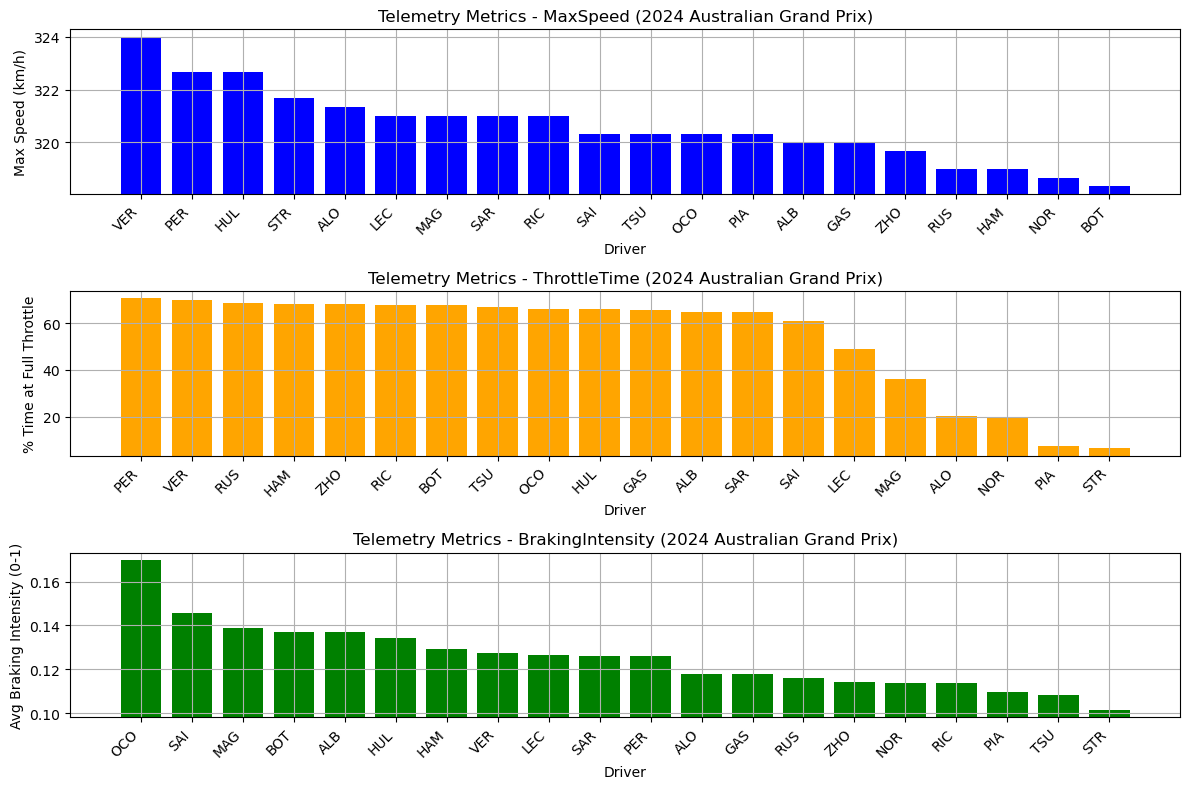


=== Evaluation and Conclusion ===
Telemetry metrics for 2024 Round 3 - Australian Grand Prix provide insights into car setup and driver behavior:
- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.
  - Top Performer: VER with 324.00 km/h, indicating strong straight-line speed.
  - Lowest: BOT with 318.33 km/h, possibly prioritizing downforce for cornering over top speed.
- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.
  - Top Performer: PER with 70.55% time at full throttle, suggesting an aggressive approach or high-speed setup.
  - Lowest: STR with 6.49% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.
- **Braking I

In [22]:
# Step 6 - Assess Telemetry Metrics
# Objective: Analyze telemetry (top speed, throttle time, braking) to infer car setup and driver style, visualizing as bar charts.

import pandas as pd
import matplotlib.pyplot as plt
import os
import fastf1
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def analyze_telemetry_metrics(config):
    """
    Analyze telemetry metrics (top speed, throttle time, braking) to infer car setup and driver style.

    Args:
        config (dict): Configuration dictionary containing:
            - 'year': The race year (e.g., 2024)
            - 'round': The round number (e.g., 3)
            - 'session_types': List of session labels (default: ['Practice 1', 'Practice 2', 'Practice 3'])
            - 'data_dir': Directory for raw data (default: "raw_data")
            - 'event_name': Event name (optional, for context)

    Returns:
        pd.DataFrame: DataFrame with averaged telemetry metrics
    """
    # Extract configuration
    year = config.get('year')
    round_number = config.get('round')  # Matches target_info key
    session_labels = config.get('session_types', ['Practice 1', 'Practice 2', 'Practice 3'])
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")  # Updated to match project structure
    event_name = config.get('event_name', "Unknown Event")

    # Set base directory dynamically
    BASE_DIR = os.getcwd()  # Jupyter-friendly, avoids __file__ issues in notebooks

    # Enable caching and set cache directory
    cache_dir = os.path.join(BASE_DIR, "cache")
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    fastf1.Cache.enable_cache(cache_dir)

    # Load raw session data for telemetry
    telemetry_metrics = []
    for session_label in session_labels:
        logger.info(f"Loading {session_label} from cache or downloading for telemetry...")
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(laps=True, telemetry=True, weather=True)  # Load full session data without force_load
            laps = session.laps

            # Extract telemetry for a sample lap per driver (e.g., fastest lap)
            driver_metrics = {}
            for driver in laps['Driver'].unique():
                driver_laps = laps[laps['Driver'] == driver]
                fastest_lap = driver_laps.loc[driver_laps['LapTime'].idxmin()]
                if not pd.isna(fastest_lap['LapTime']):
                    telemetry = fastest_lap.get_telemetry()
                    # Metrics: Max Speed, % Time at Full Throttle, Avg Braking Intensity
                    max_speed = telemetry['Speed'].max()
                    throttle_time = (telemetry['Throttle'] == 100).mean() * 100  # % time at full throttle
                    braking_intensity = telemetry['Brake'].mean()  # Avg brake application (0-1)
                    driver_metrics[driver] = {
                        'Driver': driver,
                        'MaxSpeed': max_speed,
                        'ThrottleTime': throttle_time,
                        'BrakingIntensity': braking_intensity,
                        'Session': session_label
                    }

            # Convert to DataFrame and append
            session_df = pd.DataFrame.from_dict(driver_metrics, orient='index')
            telemetry_metrics.append(session_df)
        except Exception as e:
            logger.warning(f"Error loading {session_label}: {e}. Skipping session.")
            continue

    if not telemetry_metrics:
        logger.error("No telemetry data available to process.")
        return pd.DataFrame()

    # Combine and average metrics across sessions
    all_telemetry = pd.concat(telemetry_metrics, ignore_index=True)
    overall_telemetry = all_telemetry.groupby('Driver').mean(numeric_only=True).reset_index()

    # Merge with team info (from FP3 raw data)
    fp3_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_Practice_3_laps.csv")  # Updated to match Step 3 naming
    if os.path.exists(fp3_file):
        fp3_data = pd.read_csv(fp3_file)
        team_info = fp3_data[['Driver', 'Team']].drop_duplicates()
        overall_telemetry = overall_telemetry.merge(team_info, on='Driver', how='left')
    else:
        logger.warning(f"Warning: {fp3_file} not found. Team info will be incomplete.")
        overall_telemetry['Team'] = 'Unknown'  # Default value if no team data

    # Display table
    print("\nTelemetry Metrics (Top 10 by Max Speed):")
    display(overall_telemetry.sort_values('MaxSpeed', ascending=False).head(10))

    # Visualization with bar charts
    plt.figure(figsize=(12, 8))
    metrics = ['MaxSpeed', 'ThrottleTime', 'BrakingIntensity']
    titles = ['Max Speed (km/h)', '% Time at Full Throttle', 'Avg Braking Intensity (0-1)']
    colors = ['blue', 'orange', 'green']

    for i, (metric, title, color) in enumerate(zip(metrics, titles, colors), 1):
        plt.subplot(3, 1, i)
        # For ThrottleTime, filter out drivers with 0% (invalid data)
        if metric == 'ThrottleTime':
            plot_data = overall_telemetry[overall_telemetry['ThrottleTime'] > 0]
        else:
            plot_data = overall_telemetry
        sorted_data = plot_data.sort_values(metric, ascending=False)
        plt.bar(sorted_data['Driver'], sorted_data[metric], color=color)

        # Adjust y-axis limits for better readability
        y_min = sorted_data[metric].min()
        y_max = sorted_data[metric].max()
        y_range = y_max - y_min
        plt.ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

        plt.xlabel('Driver')
        plt.ylabel(title)
        plt.title(f'Telemetry Metrics - {metric} ({year} {event_name})')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluation and Conclusion
    print("\n=== Evaluation and Conclusion ===")
    print(f"Telemetry metrics for {year} Round {round_number} - {event_name} provide insights into car setup and driver behavior:")

    # Identify top performers and outliers
    top_speed_driver = overall_telemetry.loc[overall_telemetry['MaxSpeed'].idxmax(), 'Driver']
    top_speed_value = overall_telemetry['MaxSpeed'].max()
    low_speed_driver = overall_telemetry.loc[overall_telemetry['MaxSpeed'].idxmin(), 'Driver']
    low_speed_value = overall_telemetry['MaxSpeed'].min()

    # Filter out invalid ThrottleTime for evaluation
    valid_throttle = overall_telemetry[overall_telemetry['ThrottleTime'] > 0]
    if not valid_throttle.empty:
        top_throttle_driver = valid_throttle.loc[valid_throttle['ThrottleTime'].idxmax(), 'Driver']
        top_throttle_value = valid_throttle['ThrottleTime'].max()
        low_throttle_driver = valid_throttle.loc[valid_throttle['ThrottleTime'].idxmin(), 'Driver']
        low_throttle_value = valid_throttle['ThrottleTime'].min()
    else:
        top_throttle_driver = "N/A"
        top_throttle_value = "N/A"
        low_throttle_driver = "N/A"
        low_throttle_value = "N/A"

    top_braking_driver = overall_telemetry.loc[overall_telemetry['BrakingIntensity'].idxmax(), 'Driver']
    top_braking_value = overall_telemetry['BrakingIntensity'].max()
    low_braking_driver = overall_telemetry.loc[overall_telemetry['BrakingIntensity'].idxmin(), 'Driver']
    low_braking_value = overall_telemetry['BrakingIntensity'].min()

    # Generic insights with dynamic data
    print("- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.")
    print(f"  - Top Performer: {top_speed_driver} with {top_speed_value:.2f} km/h, indicating strong straight-line speed.")
    print(f"  - Lowest: {low_speed_driver} with {low_speed_value:.2f} km/h, possibly prioritizing downforce for cornering over top speed.")

    print("- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.")
    if not valid_throttle.empty:
        print(f"  - Top Performer: {top_throttle_driver} with {top_throttle_value:.2f}% time at full throttle, suggesting an aggressive approach or high-speed setup.")
        print(f"  - Lowest: {low_throttle_driver} with {low_throttle_value:.2f}% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.")
    else:
        print("  - Note: Throttle time data is missing or invalid for all drivers, which may indicate telemetry issues. Investigate data collection for accuracy.")

    # Note missing throttle time drivers
    missing_throttle = overall_telemetry[overall_telemetry['ThrottleTime'] == 0]['Driver'].tolist()
    if missing_throttle:
        print(f"  - Missing Throttle Time: The following drivers have 0% throttle time, which may indicate telemetry errors: {', '.join(missing_throttle)}. These drivers are excluded from the throttle time chart.")

    print("- **Braking Intensity**: Measures average brake application (0-1). Higher values indicate heavier braking, often associated with late-braking techniques, while lower values suggest smoother driving, which can be advantageous in technical sections.")
    print(f"  - Top Performer: {top_braking_driver} with an intensity of {top_braking_value:.3f}, potentially excelling in late braking into corners.")
    print(f"  - Lowest: {low_braking_driver} with an intensity of {low_braking_value:.3f}, indicating a smoother braking style that may preserve tyre life.")

    # Combined interpretation
    print("\n**Combined Interpretation**:")
    print("Drivers with high max speed and throttle time are likely to perform well in qualifying, especially on tracks favoring straight-line speed. Those with balanced braking intensity may excel in races, particularly on circuits with technical corners where tyre management and cornering stability are key.")
    print("Look for outliers: Drivers with unusually low throttle time or high braking intensity may be sandbagging or using setups that prioritize race pace over qualifying performance. Correlate these metrics with lap times (Step 5) and sandbagging analysis (Step 7) to identify potential hidden pace.")

    # Save table
    output_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_telemetry_metrics.csv")
    overall_telemetry.to_csv(output_file, index=False)
    print(f"Saved telemetry metrics to {output_file}")

    return overall_telemetry

# Example usage with dynamic target_info
telemetry_metrics_df = analyze_telemetry_metrics(target_info)

# Why: Telemetry reveals car setup (speed, downforce) and driver aggression, key for pole and race.
# How to Read: Higher Max Speed = straight-line strength. High Throttle = aggressive driving. Moderate Braking = technical skill.
# Expected Inputs: target_info with year, round, session_types, event_name
# Expected Outputs: Table of metrics, bar charts, evaluation, saved CSV
# Data Exported: {year}_R{round}_telemetry_metrics.csv in raw_data/{year}/R{round_number}/ directory

2025-03-18 19:57:20,863 - INFO - Base directory: C:\data\Dropbox\dev\F1



Potential Sandbaggers (Sorted by PredictionDiscrepancy):


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
19,SAR,78.578,Williams,321.000000,64.737740,78.441,0.137,77.462599,1.115401,7.5,20.0,True
13,HUL,77.941,Haas F1 Team,322.666667,66.109703,77.762,0.179,77.371073,0.569927,2.5,16.0,True
17,RIC,77.963,RB,321.000000,67.609016,77.963,0.000,77.462599,0.500401,7.5,18.0,True
14,MAG,77.961,Haas F1 Team,321.000000,35.958573,77.766,0.195,77.462599,0.498401,7.5,17.0,True


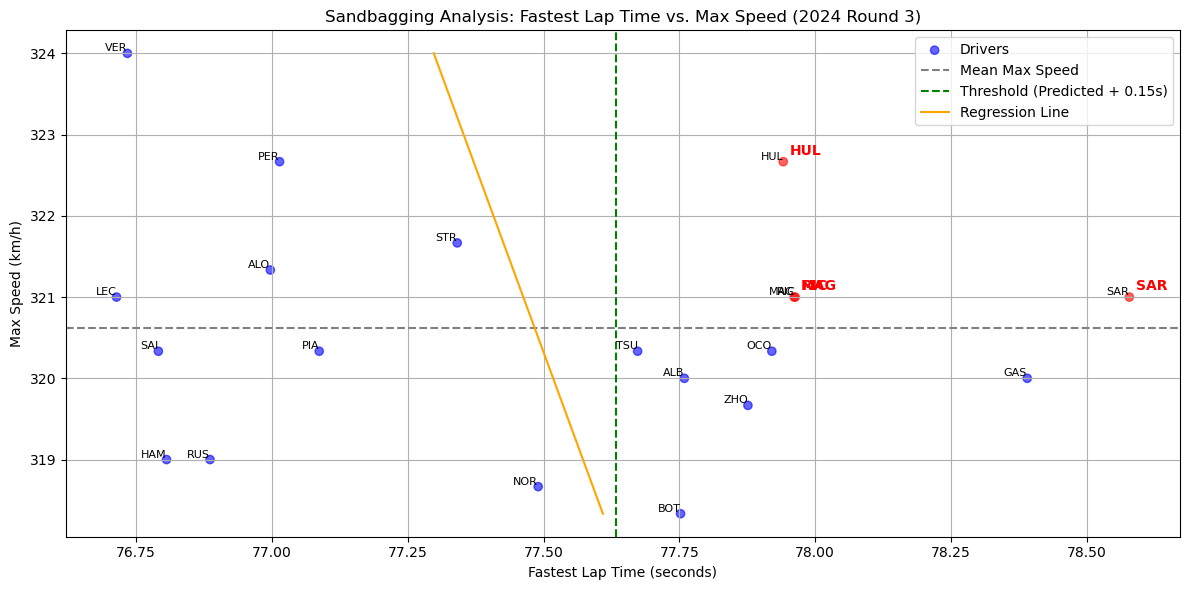

Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_sandbag_analysis.csv


In [23]:
# Step 7: Sandbagging Analysis (Updated to Use Driver Performance Data)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

if not logger.handlers:
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

def investigate_sandbagging(config):
    """
    Detect teams hiding pace by comparing lap times to telemetry metrics.

    Args:
        config (dict): Configuration dictionary containing:
            - 'year': The race year (e.g., 2024)
            - 'round': The round number (e.g., 3)
            - 'data_dir': Directory for raw data (default: "raw_data")
            - 'sandbag_threshold': Discrepancy threshold for sandbagging (default: 0.15 seconds)

    Returns:
        pd.DataFrame: Sandbagging analysis results
    """
    year = config.get('year')
    round_number = config.get('round')  # Matches target_info
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")  # Updated to match project structure
    sandbag_threshold = config.get('sandbag_threshold', 0.15)

    BASE_DIR = os.getcwd()  # Jupyter-friendly, avoids __file__ issues
    logger.info(f"Base directory: {BASE_DIR}")

    # Load data
    driver_performance_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_driver_performance.csv")
    telemetry_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_telemetry_metrics.csv")
    if not os.path.exists(driver_performance_file):
        logger.error(f"Driver performance file not found: {driver_performance_file}")
        return pd.DataFrame()
    if not os.path.exists(telemetry_file):
        logger.error(f"Telemetry metrics file not found: {telemetry_file}")
        return pd.DataFrame()

    driver_performance = pd.read_csv(driver_performance_file)
    telemetry_metrics = pd.read_csv(telemetry_file)

    # Merge data
    sandbag_analysis = driver_performance[['Driver', 'FastestLapTime', 'Team']].merge(
        telemetry_metrics[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left'
    )
    # Check for NaN values in telemetry metrics
    if sandbag_analysis[['MaxSpeed', 'ThrottleTime']].isna().any().any():
        logger.warning("NaN values found in telemetry metrics. Filling with median values.")
        sandbag_analysis['MaxSpeed'] = sandbag_analysis['MaxSpeed'].fillna(telemetry_metrics['MaxSpeed'].median())
        sandbag_analysis['ThrottleTime'] = sandbag_analysis['ThrottleTime'].fillna(telemetry_metrics['ThrottleTime'].median())

    sandbag_analysis['ExpectedLapTime'] = driver_performance['Sector1Time'] + driver_performance['Sector2Time'] + driver_performance['Sector3Time']
    sandbag_analysis['LapTimeDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['ExpectedLapTime']

    # Predict FastestLapTime from MaxSpeed using linear regression
    X = sandbag_analysis[['MaxSpeed']].values
    y = sandbag_analysis['FastestLapTime'].values
    reg = LinearRegression().fit(X, y)
    sandbag_analysis['PredictedLapTime'] = reg.predict(X)
    sandbag_analysis['PredictionDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['PredictedLapTime']
    sandbag_analysis['SpeedRank'] = sandbag_analysis['MaxSpeed'].rank(ascending=False)
    sandbag_analysis['LapTimeRank'] = sandbag_analysis['FastestLapTime'].rank()

    # New sandbagging logic: Flag drivers with high MaxSpeed (above mean) and FastestLapTime exceeding PredictedLapTime + threshold
    mean_max_speed = sandbag_analysis['MaxSpeed'].mean()
    sandbag_analysis['SandbagFlag'] = (sandbag_analysis['MaxSpeed'] > mean_max_speed) & (sandbag_analysis['PredictionDiscrepancy'] > sandbag_threshold)

    # Display potential sandbaggers
    print("\nPotential Sandbaggers (Sorted by PredictionDiscrepancy):")
    display(sandbag_analysis[sandbag_analysis['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False))

    # Visualization: Scatter plot of FastestLapTime vs. MaxSpeed with sandbaggers highlighted
    plt.figure(figsize=(12, 6))
    colors = ['blue' if not flag else 'red' for flag in sandbag_analysis['SandbagFlag']]
    scatter = plt.scatter(sandbag_analysis['FastestLapTime'], sandbag_analysis['MaxSpeed'], c=colors, label='Drivers', alpha=0.6)
    plt.axhline(y=mean_max_speed, color='gray', linestyle='--', label='Mean Max Speed')
    plt.axvline(x=sandbag_analysis['PredictedLapTime'].mean() + sandbag_threshold, color='green', linestyle='--', label=f'Threshold (Predicted + {sandbag_threshold}s)')
    # Plot regression line
    x_range = np.array([[sandbag_analysis['MaxSpeed'].min()], [sandbag_analysis['MaxSpeed'].max()]])
    y_pred = reg.predict(x_range)
    plt.plot(y_pred, x_range, color='orange', linestyle='-', label='Regression Line')
    for i, row in sandbag_analysis.iterrows():
        plt.text(row['FastestLapTime'], row['MaxSpeed'], row['Driver'], fontsize=8, ha='right', va='bottom')
        if row['SandbagFlag']:
            plt.annotate(row['Driver'], (row['FastestLapTime'], row['MaxSpeed']), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', weight='bold')
    plt.xlabel('Fastest Lap Time (seconds)')
    plt.ylabel('Max Speed (km/h)')
    plt.title(f'Sandbagging Analysis: Fastest Lap Time vs. Max Speed ({year} Round {round_number})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save results
    output_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_sandbag_analysis.csv")
    sandbag_analysis.to_csv(output_file, index=False)
    print(f"Saved sandbag analysis to {output_file}")

    return sandbag_analysis

# Example usage with dynamic target_info
sandbag_analysis_df = investigate_sandbagging(target_info)

# Why: Detects teams hiding pace by comparing lap times to telemetry, aiding race prediction.
# How to Read: High PredictionDiscrepancy with high MaxSpeed flags sandbagging. Red dots on scatter plot highlight suspects.
# Expected Inputs: driver_performance.csv, telemetry_metrics.csv from prior steps
# Expected Outputs: Table of sandbaggers, scatter plot, saved CSV
# Data Exported: {year}_R{round_number}_sandbag_analysis.csv in raw_data/{year}/R{round_number}/ directory

Average lap time for Practice 1: 94.813 seconds (±20.104)
Average lap time for Practice 2: 91.443 seconds (±17.168)
Average lap time for Practice 3: 95.559 seconds (±20.434)
Loading weather for Practice 1 from FastF1...
Available weather columns for Practice 1: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Practice 2 from FastF1...
Available weather columns for Practice 2: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Practice 3 from FastF1...
Available weather columns for Practice 3: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,94.812869,20.104116,275
1,Practice 2,91.443046,17.168298,373
2,Practice 3,95.558951,20.434266,244



Average Weather Conditions Across Sessions:


WeatherType,AirTemp,Humidity,Rainfall,TrackTemp
Session,,,,
Practice 1,18.469136,61.012346,0.0,33.709877
Practice 2,20.157317,56.926829,0.0,36.157317
Practice 3,18.272840,59.395062,0.0,27.669136



Correlation between TrackTemp and AvgLapTime: -0.830


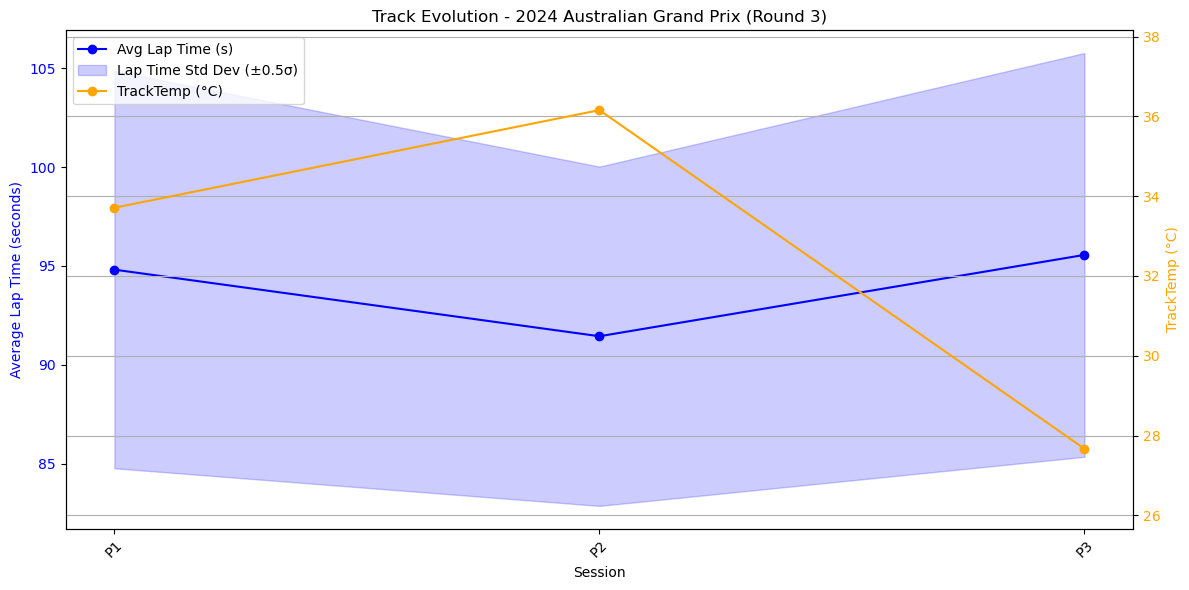

Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_evolution.csv


In [24]:
# Step 8 - Evaluate Track Evolution and Weather Impact
import pandas as pd
import matplotlib.pyplot as plt
import fastf1
import numpy as np
from scipy.stats import pearsonr

def evaluate_track_evolution(target_info, cleaned_data):
    year = target_info['year']
    round_number = target_info['round']
    session_labels = target_info['session_types']
    weather_metric = target_info.get('weather_metric', 'TrackTemp')
    session_label_map = {
        'FP1': 'Practice 1', 'FP2': 'Practice 2', 'FP3': 'Practice 3',
        'Sprint Qualifying': 'Sprint Qualifying', 'Sprint': 'Sprint'
    }
    session_labels = [session_label_map.get(label, label) for label in session_labels]
    event_name = target_info.get('event_name', 'Unknown Event')
    data_dir = os.path.join(os.getcwd(), "raw_data", str(year), f"R{round_number}")

    # Lap stats from cleaned_data
    lap_stats = {}
    for session_label in session_labels:
        df = cleaned_data.get(session_label, pd.DataFrame())
        if df.empty:
            print(f"Warning: No lap data for {session_label}, skipping.")
            continue
        if pd.api.types.is_string_dtype(df['LapTime']):
            df['LapTime'] = pd.to_timedelta(df['LapTime'])
        lap_times = df['LapTime'].dt.total_seconds().dropna()
        if len(lap_times) == 0:
            print(f"Warning: No valid lap times for {session_label}, skipping.")
            continue
        lap_stats[session_label] = {
            'mean': lap_times.mean(),
            'std': lap_times.std(),
            'count': len(lap_times)
        }
        print(f"Average lap time for {session_label}: {lap_stats[session_label]['mean']:.3f} seconds (±{lap_stats[session_label]['std']:.3f})")

    # Weather data
    weather_data = {}
    for session_label in session_labels:
        print(f"Loading weather for {session_label} from FastF1...")
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(weather=True, laps=False)
            weather = session.weather_data
            print(f"Available weather columns for {session_label}: {weather.columns.tolist()}")
            available_columns = [col for col in ['AirTemp', 'TrackTemp', 'Humidity', 'Rainfall'] if col in weather.columns]
            if available_columns:
                weather_data[session_label] = weather[available_columns]
            else:
                print(f"No valid weather data for {session_label}, skipping weather analysis.")
                weather_data[session_label] = pd.DataFrame()
        except Exception as e:
            print(f"Failed to load {session_label} weather data: {e}")
            weather_data[session_label] = pd.DataFrame()

    avg_weather = {session: weather.mean() for session, weather in weather_data.items() if not weather.empty}

    # Tables
    lap_time_df = pd.DataFrame([
        {'Session': session, 'AvgLapTime': stats['mean'], 'StdLapTime': stats['std'], 'LapCount': stats['count']}
        for session, stats in lap_stats.items()
    ])
    print("\nAverage Lap Times Across Sessions:")
    display(lap_time_df)

    weather_list = [
        {'Session': session, 'WeatherType': col, 'Value': value}
        for session, stats in avg_weather.items() if not stats.empty
        for col, value in stats.to_dict().items()
    ]
    weather_df = pd.DataFrame(weather_list) if weather_list else pd.DataFrame()
    if not weather_df.empty:
        print("\nAverage Weather Conditions Across Sessions:")
        display(weather_df.pivot(index='Session', columns='WeatherType', values='Value'))

    # Correlation
    if not weather_df.empty and weather_metric in weather_df.pivot(index='Session', columns='WeatherType', values='Value').columns:
        weather_values = weather_df[weather_df['WeatherType'] == weather_metric].set_index('Session')['Value']
        lap_times = lap_time_df.set_index('Session')['AvgLapTime']
        common_sessions = weather_values.index.intersection(lap_times.index)
        if len(common_sessions) > 1:
            weather_values = weather_values[common_sessions]
            lap_times = lap_times[common_sessions]
            correlation, _ = pearsonr(weather_values, lap_times)
            print(f"\nCorrelation between {weather_metric} and AvgLapTime: {correlation:.3f}")
        else:
            print(f"\nNot enough overlapping sessions for correlation analysis with {weather_metric}.")
    else:
        print(f"\n{weather_metric} data not available for correlation analysis.")

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(lap_time_df['Session'], lap_time_df['AvgLapTime'], marker='o', color='blue', label='Avg Lap Time (s)')
    ax1.fill_between(lap_time_df['Session'], lap_time_df['AvgLapTime'] - lap_time_df['StdLapTime'] / 2,
                     lap_time_df['AvgLapTime'] + lap_time_df['StdLapTime'] / 2, color='blue', alpha=0.2, label='Lap Time Std Dev (±0.5σ)')
    ax1.set_xlabel('Session')
    ax1.set_ylabel('Average Lap Time (seconds)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(lap_time_df['Session'])
    ax1.set_xticklabels(['P1', 'P2', 'P3'], rotation=45)

    if not weather_df.empty and weather_metric in weather_df.pivot(index='Session', columns='WeatherType', values='Value').columns:
        ax2 = ax1.twinx()
        weather_values_df = weather_df[weather_df['WeatherType'] == weather_metric].set_index('Session')['Value']
        weather_values_df = weather_values_df.reindex(lap_time_df['Session'])
        ax2.plot(lap_time_df['Session'], weather_values_df, marker='o', color='orange', label=f'{weather_metric} (°C)')
        ax2.set_ylabel(f'{weather_metric} (°C)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.set_ylim(weather_values_df.min() - 2, weather_values_df.max() + 2)

    lines, labels = ax1.get_legend_handles_labels()
    if 'ax2' in locals():
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    else:
        ax1.legend(loc='upper left')

    plt.title(f'Track Evolution - {year} {event_name} (Round {round_number})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_track_evolution.csv")
    lap_time_df.to_csv(output_file, index=False)
    print(f"Saved track evolution to {output_file}")
    return lap_time_df

# Standalone execution for debugging (runs only if cell is executed directly)
if 'target_info' in globals() and 'cleaned_data' in globals():
    track_evolution_df = evaluate_track_evolution(target_info, cleaned_data)
else:
    print("Warning: target_info and/or cleaned_data not found. Run Cells 2 and 4 first for standalone execution.")


Track Characteristics Analysis for Australian Grand Prix:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Australian Grand Prix,High,Easy,3,High,5.230004,No



Driver Fit to Track Characteristics (Top 10) - Australian Grand Prix:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
10,PER,Red Bull Racing,328.0,31.330842,200.313957,0.798361,1.0
18,VER,Red Bull Racing,327.0,31.112109,201.722266,0.766595,2.0
5,HUL,Haas F1 Team,326.0,30.985585,202.545957,0.668619,3.0
16,STR,Aston Martin,323.0,30.216980,207.697960,0.654034,4.0
11,PIA,McLaren,321.0,29.793454,210.650469,0.580492,5.0
1,ALO,Aston Martin,323.0,30.388130,206.528175,0.531141,6.0
14,SAI,Ferrari,324.0,30.837202,203.520575,0.397516,7.0
8,NOR,McLaren,322.0,30.333907,206.897352,0.381251,8.0
15,SAR,Williams,323.0,30.754856,204.065502,0.267819,9.0
9,OCO,Alpine,323.0,31.027497,202.272360,0.072053,10.0


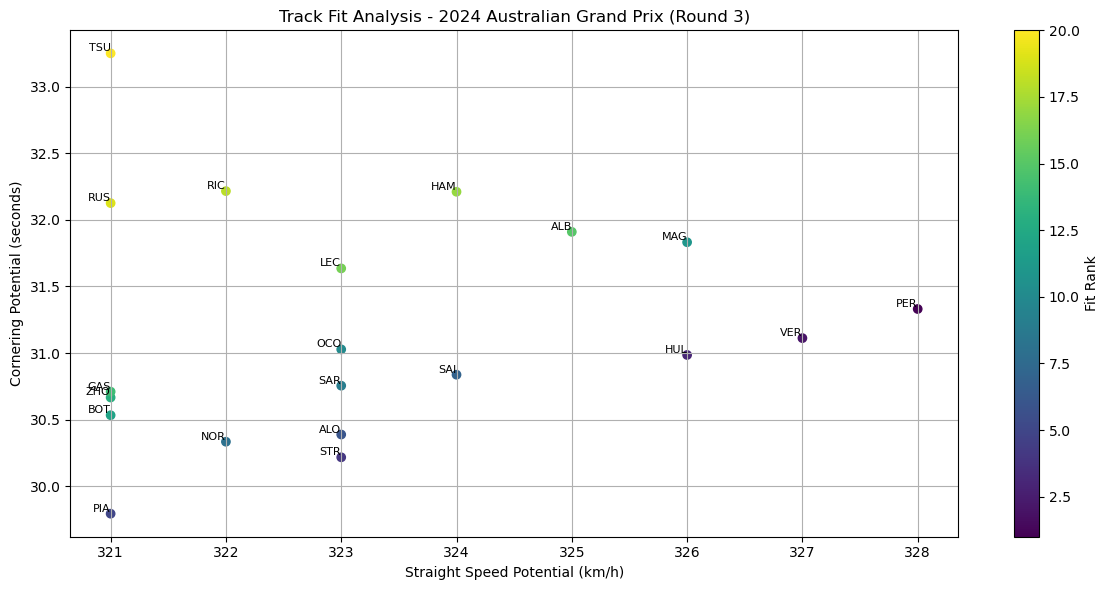

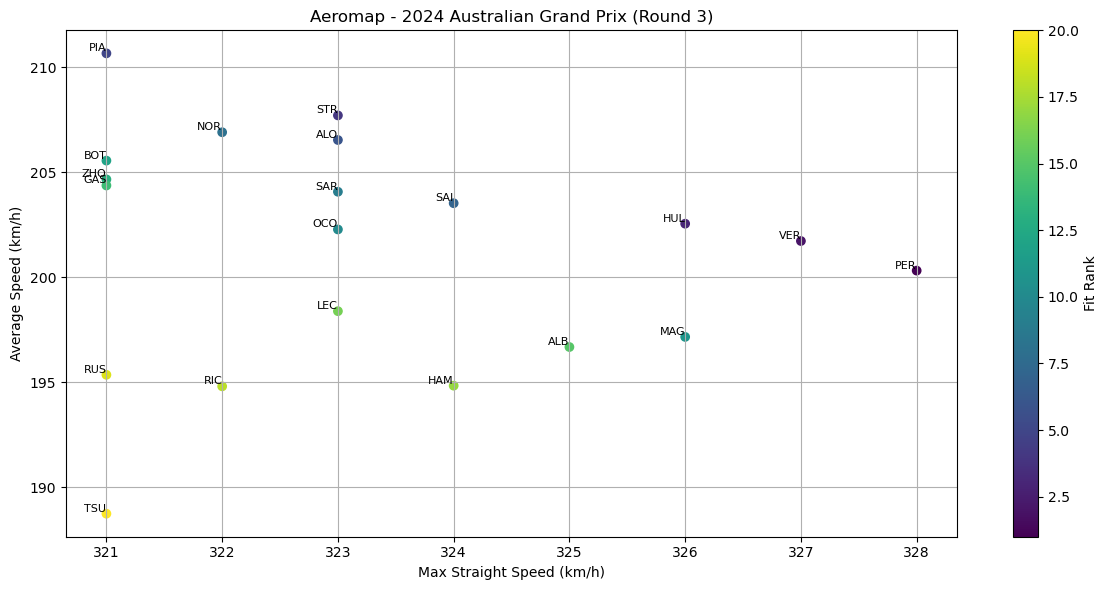

Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_characteristics.csv
Saved driver fit data to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_characteristics_drivers.csv


In [25]:
# Step 9 - Analyze Track Characteristics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fastf1
import os
from scipy.stats import zscore

def analyze_track_characteristics(target_info, cleaned_data):
    year = target_info['year']
    round_number = target_info['round']
    event_name = target_info.get('event_name', 'Unknown Event')
    data_dir = os.path.join(os.getcwd(), "raw_data", str(year), f"R{round_number}")

    all_laps = pd.concat([cleaned_data[session] for session in cleaned_data.keys()], ignore_index=True)
    required_columns = ['Driver', 'Team', 'SpeedST', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime']
    if not all(col in all_laps.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in all_laps.columns]
        print(f"Warning: Missing columns in cleaned_data: {missing_cols}. Using available data.")
        all_laps = all_laps.dropna(subset=[col for col in required_columns if col in all_laps.columns])

    track_analysis = all_laps.groupby(['Driver', 'Team']).agg({
        'SpeedST': 'max',
        'Sector1Time': 'mean',
        'Sector2Time': 'mean',
        'Sector3Time': 'mean',
        'LapTime': 'mean'
    }).reset_index()

    for col in ['Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime']:
        if pd.api.types.is_string_dtype(track_analysis[col]):
            track_analysis[col] = pd.to_timedelta(track_analysis[col])
        track_analysis[col] = track_analysis[col].dt.total_seconds()

    try:
        session = fastf1.get_session(year, round_number, 'Practice 3')
        session.load(laps=True, telemetry=True, weather=False)
        circuit_info = session.get_circuit_info()
        lap_length = circuit_info.length / 1000 if hasattr(circuit_info, 'length') else target_info.get('track_length', 6.174)
        drs_zones = len(circuit_info.drs_zones) if hasattr(circuit_info, 'drs_zones') and circuit_info.drs_zones else 3
    except Exception as e:
        print(f"Error fetching circuit info: {e}")
        lap_length = target_info.get('track_length', 6.174)
        drs_zones = 3

    avg_sector_speed = all_laps['SpeedST'].mean()
    max_sector_speed = all_laps['SpeedST'].max()
    downforce_requirement = 'Low' if avg_sector_speed > 330 else 'Medium-High' if avg_sector_speed > 310 else 'High'
    overtaking_difficulty = 'Easy' if drs_zones > 2 else 'Moderate' if drs_zones == 2 else 'Hard'
    try:
        driver_performance = pd.read_csv(os.path.join(data_dir, f"{year}_R{round_number}_driver_performance.csv"))
        avg_tyre_degradation = driver_performance['DegradationSlope'].mean()
        tyre_degradation = 'High' if avg_tyre_degradation > 10 else 'Moderate' if avg_tyre_degradation > 7 else 'Low'
    except Exception as e:
        print(f"Error loading driver performance data: {e}")
        tyre_degradation = 'Moderate'
    suits_fast_cars = 'Yes' if max_sector_speed > 330 else 'No'

    track_characteristics = {
        'Track': event_name,
        'DownforceRequirement': downforce_requirement,
        'OvertakingDifficulty': overtaking_difficulty,
        'DRSZones': drs_zones,
        'TyreDegradation': tyre_degradation,
        'LapLength': lap_length,
        'SuitsFastCars': suits_fast_cars
    }

    track_analysis['StraightSpeedPotential'] = track_analysis['SpeedST']
    track_analysis['CorneringPotential'] = (track_analysis['Sector1Time'] + track_analysis['Sector2Time'] + track_analysis['Sector3Time']) / 3
    track_analysis['AvgSpeed'] = (lap_length * 3600) / track_analysis['LapTime']
    straight_line_ratio = track_analysis['StraightSpeedPotential'].mean() / track_analysis['CorneringPotential'].mean()
    weight_straight = straight_line_ratio / (straight_line_ratio + 1) if suits_fast_cars == 'Yes' else 0.4
    weight_cornering = 1 - weight_straight
    track_analysis['StraightZScore'] = zscore(track_analysis['StraightSpeedPotential'])
    track_analysis['CorneringZScore'] = -zscore(track_analysis['CorneringPotential'])
    track_analysis['OverallFit'] = (weight_straight * track_analysis['StraightZScore'] + weight_cornering * track_analysis['CorneringZScore'])

    track_analysis = track_analysis.sort_values('OverallFit', ascending=False)
    track_analysis['FitRank'] = track_analysis['OverallFit'].rank(ascending=False)

    print(f"\nTrack Characteristics Analysis for {event_name}:")
    track_char_df = pd.DataFrame(track_characteristics, index=[0])
    display(track_char_df)
    print(f"\nDriver Fit to Track Characteristics (Top 10) - {event_name}:")
    display(track_analysis[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']].head(10))

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(track_analysis['StraightSpeedPotential'], track_analysis['CorneringPotential'],
                          c=track_analysis['FitRank'], cmap='viridis')
    plt.colorbar(scatter, label='Fit Rank')
    for i, row in track_analysis.iterrows():
        plt.text(row['StraightSpeedPotential'], row['CorneringPotential'], row['Driver'], fontsize=8, ha='right', va='bottom')
    plt.xlabel('Straight Speed Potential (km/h)')
    plt.ylabel('Cornering Potential (seconds)')
    plt.title(f'Track Fit Analysis - {year} {event_name} (Round {round_number})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(track_analysis['StraightSpeedPotential'], track_analysis['AvgSpeed'],
                          c=track_analysis['FitRank'], cmap='viridis')
    plt.colorbar(scatter, label='Fit Rank')
    for i, row in track_analysis.iterrows():
        plt.text(row['StraightSpeedPotential'], row['AvgSpeed'], row['Driver'], fontsize=8, ha='right', va='bottom')
    plt.xlabel('Max Straight Speed (km/h)')
    plt.ylabel('Average Speed (km/h)')
    plt.title(f'Aeromap - {year} {event_name} (Round {round_number})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    output_file = os.path.join(data_dir, f"{year}_R{round_number}_track_characteristics.csv")
    driver_file = os.path.join(data_dir, f"{year}_R{round_number}_track_characteristics_drivers.csv")
    track_char_df.to_csv(output_file, index=False)
    track_analysis.to_csv(driver_file, index=False)
    print(f"Saved track characteristics to {output_file}")
    print(f"Saved driver fit data to {driver_file}")
    return track_analysis  # Return driver fit data as primary output

# Standalone execution for debugging (runs only if cell is executed directly)
if 'target_info' in globals() and 'cleaned_data' in globals():
    track_char_drivers_df = analyze_track_characteristics(target_info, cleaned_data)
else:
    print("Warning: target_info and/or cleaned_data not found. Run Cells 2 and 4 first for standalone execution.")

In [26]:
# Step 10: Race Strategy and Final Prediction
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import fastf1

def predict_race_outcomes(config, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, pit_stop_loss_default=25, overtaking_penalty=0.5):
    year = config.get('year')
    round_number = config.get('round')
    data_dir = config.get('data_dir', "raw_data")
    race_laps = config.get('race_laps', 50)
    event_name = config.get('event_name', "Unknown Event")

    BASE_DIR = os.getcwd()
    round_data_dir = os.path.join(BASE_DIR, data_dir, str(year), f"R{round_number}")
    os.makedirs(round_data_dir, exist_ok=True)

    # Load dynamic pit_stop_loss
    pit_stop_file = os.path.join(BASE_DIR, "pit_stop_loss_by_track.csv")
    if os.path.exists(pit_stop_file):
        pit_stop_df = pd.read_csv(pit_stop_file)
        if event_name in pit_stop_df['Track'].values:
            pit_stop_loss = pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'].values[0]
            print(f"Loaded pit_stop_loss from file: {pit_stop_loss:.2f}s for {event_name}")
        else:
            pit_stop_loss = pit_stop_loss_default
            print(f"No pit_stop_loss found for {event_name} in file, using default: {pit_stop_loss}s")
    else:
        pit_stop_loss = pit_stop_loss_default
        print(f"Pit stop loss file not found, using default: {pit_stop_loss}s")

    # Handle NaN in driver_performance_df
    driver_performance_df['BasePace'] = driver_performance_df['BasePace'].fillna(driver_performance_df['FastestLapTime'] + 5)
    driver_performance_df['DegradationSlope'] = driver_performance_df['DegradationSlope'].fillna(7.0)
    driver_performance_df['LapTimeVar'] = driver_performance_df['LapTimeVar'].fillna(driver_performance_df['BasePace'] * 0.01)

    # Qualifying Prediction
    quali_prediction = driver_performance_df[['Driver', 'FastestLapTime', 'Team']].copy()
    quali_prediction = quali_prediction.rename(columns={'FastestLapTime': 'LapTime'})
    quali_prediction['ExpectedLapTime'] = driver_performance_df['Sector1Time'] + driver_performance_df['Sector2Time'] + driver_performance_df['Sector3Time']
    quali_prediction = quali_prediction.merge(sandbag_analysis_df[['Driver', 'LapTimeDiscrepancy', 'SandbagFlag']], on='Driver', how='left')
    quali_prediction = quali_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit']], on='Driver', how='left')
    quali_prediction['AdjustedLapTime'] = quali_prediction.apply(
        lambda row: row['ExpectedLapTime'] if (row.get('SandbagFlag', False) or (row.get('OverallFit', 0) > 0.5 and row['LapTime'] > row['ExpectedLapTime'])) else row['LapTime'], axis=1
    )
    quali_prediction['QualiPosition'] = quali_prediction['AdjustedLapTime'].rank(method='min').astype(int)

    print("\nQualifying Prediction:")
    display(quali_prediction[['Driver', 'Team', 'LapTime', 'ExpectedLapTime', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition'))

    # Race Strategy Simulation
    strategy_df = driver_performance_df.copy()
    strategy_df['QualiPace'] = quali_prediction['AdjustedLapTime']
    strategy_df['GridPosition'] = quali_prediction['QualiPosition']

    strategy_df['FuelPenalty'] = strategy_df['DegradationSlope'] * (race_laps / 2) / 100 * 2
    strategy_df['TrafficPenalty'] = (strategy_df['LapTimeVar'] / strategy_df['BasePace']) * overtaking_penalty * (race_laps / 50) * 5

    strategies = []
    for _, row in strategy_df.iterrows():
        driver = row['Driver']
        team = row['Team']
        base_pace = row['BasePace']
        deg_rate = row['DegradationSlope'] / 100
        fuel_penalty = row['FuelPenalty']
        traffic_penalty = row['TrafficPenalty'] if row['GridPosition'] > 5 else row['TrafficPenalty'] * 0.5
        grid_pos = row['GridPosition']
        quali_pace = row['QualiPace']

        start_compound = 'MEDIUM' if grid_pos <= 10 else 'SOFT'
        pos_penalty = (grid_pos - 1) * (quali_pace - strategy_df['QualiPace'].min()) / 5
        adjusted_pace = base_pace + pos_penalty + fuel_penalty + traffic_penalty

        max_stint = 27
        if start_compound == 'SOFT':
            first_stint = min(max_stint, max(5, 15 / (max(deg_rate * 3, 0.07))))
        else:
            first_stint = min(max_stint, max(7, 20 / (max(deg_rate * 2, 0.07))))
        second_compound = 'HARD'
        second_stint = race_laps - first_stint

        if first_stint > 7:
            first_stint = 7
            second_stint = race_laps - first_stint

        one_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                         (adjusted_pace + deg_rate * (second_stint / 2)) * second_stint + pit_stop_loss)
        one_stop_stints = [first_stint, second_stint]
        one_stop_compounds = [start_compound, second_compound]

        if deg_rate * race_laps > 1.0:
            first_stint = min(max_stint, race_laps / 3)
            second_compound = 'MEDIUM' if start_compound != 'MEDIUM' else 'SOFT'
            second_stint_length = min(max_stint, (race_laps - first_stint) / 2)
            third_compound = 'HARD'
            third_stint = race_laps - first_stint - second_stint_length
            if third_stint > 0:
                two_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                                 (adjusted_pace + deg_rate * (second_stint_length / 2)) * second_stint_length +
                                 (adjusted_pace + deg_rate * (third_stint / 2)) * third_stint + 2 * pit_stop_loss)
                two_stop_stints = [first_stint, second_stint_length, third_stint]
                two_stop_compounds = [start_compound, second_compound, third_compound]
            else:
                two_stop_pace = one_stop_pace + pit_stop_loss
                two_stop_stints = one_stop_stints
                two_stop_compounds = one_stop_compounds
        else:
            two_stop_pace = float('inf')
            two_stop_stints = []
            two_stop_compounds = []

        best_time = min(one_stop_pace, two_stop_pace)
        strategy = 'One-Stop' if one_stop_pace <= two_stop_pace else 'Two-Stop'
        stint_lengths = one_stop_stints if strategy == 'One-Stop' else two_stop_stints
        compounds = one_stop_compounds if strategy == 'One-Stop' else two_stop_compounds

        strategies.append({
            'Driver': driver,
            'Team': team,
            'GridPosition': grid_pos,
            'QualiPace': quali_pace,
            'BasePace': base_pace,
            'LapTimeVar': row['LapTimeVar'],
            'DegradationSlope': row['DegradationSlope'],
            'FuelPenalty': fuel_penalty,
            'TrafficPenalty': traffic_penalty,
            'CompoundStrategy': '-'.join(compounds),
            'StintLengths': stint_lengths,
            'TotalRaceTime': best_time
        })

    race_prediction = pd.DataFrame(strategies)

    race_prediction = race_prediction.merge(telemetry_metrics_df[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left')
    race_prediction = race_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit', 'AvgSpeed']], on='Driver', how='left')

    p2_lap_time = track_evolution_df[track_evolution_df['Session'] == 'Practice 2']['AvgLapTime'].iloc[0]
    p3_lap_time = track_evolution_df[track_evolution_df['Session'] == 'Practice 3']['AvgLapTime'].iloc[0]
    track_evolution_factor = (p3_lap_time - p2_lap_time) / p2_lap_time

    chaos_factor = (race_prediction['LapTimeVar'].mean() / race_prediction['BasePace'].mean()) * race_prediction['LapTimeVar'].max() / 20
    quali_gaps = race_prediction['QualiPace'].max() - race_prediction['QualiPace'].min()
    overtaking_adjustment = (quali_gaps / (race_prediction['GridPosition'].max() - 1)) * 0.2 if race_prediction['GridPosition'].max() > 1 else 0.2
    race_load_factor = (race_prediction['BasePace'].mean() - race_prediction['QualiPace'].mean()) / (race_laps / 10) * 1.5

    race_prediction['RaceLoad'] = race_load_factor * (race_prediction['LapTimeVar'] / race_prediction['BasePace']) * (race_laps / 2)
    race_prediction['TrackEvolutionAdjustment'] = track_evolution_factor * race_prediction['TotalRaceTime'] * (race_prediction['DegradationSlope'] / 100)
    race_prediction['ConsistencyAdjustment'] = race_prediction['LapTimeVar'] / race_prediction['BasePace'] * 10
    race_prediction['AdjustedRaceTime'] = race_prediction['TotalRaceTime'] + race_prediction['RaceLoad'] + race_prediction['TrackEvolutionAdjustment'] + race_prediction['ConsistencyAdjustment']
    race_prediction['SpeedAdjustment'] = (race_prediction['MaxSpeed'] / race_prediction['MaxSpeed'].max()) * 3
    race_prediction['FitAdjustment'] = (1 - race_prediction['OverallFit'].rank() / len(race_prediction)) * 10
    race_prediction['AvgSpeedAdjustment'] = (race_prediction['AvgSpeed'] / race_prediction['AvgSpeed'].max()) * 20
    race_prediction['AdjustedRaceTime'] = race_prediction['AdjustedRaceTime'] - race_prediction['SpeedAdjustment'] - race_prediction['FitAdjustment'] - race_prediction['AvgSpeedAdjustment']

    for idx, row in race_prediction.iterrows():
        grid_pos = row['GridPosition']
        if grid_pos > 10:
            race_prediction.at[idx, 'AdjustedRaceTime'] += chaos_factor * (grid_pos - 10) / 10
        pos_diff = max(0, grid_pos - 5)
        race_prediction.at[idx, 'AdjustedRaceTime'] += pos_diff * overtaking_adjustment

    race_prediction['FinalPosition'] = race_prediction['AdjustedRaceTime'].rank(method='min').astype(int)

    print("\nFinal Race Prediction:")
    display(race_prediction[['Driver', 'Team', 'GridPosition', 'TotalRaceTime', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition'))

    # Fastest Lap Prediction
    fastest_laps = []
    for session_label in ['Practice 1', 'Practice 2', 'Practice 3']:
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(laps=True)
            laps = session.laps
            for driver in laps['Driver'].unique():
                driver_laps = laps[laps['Driver'] == driver]
                fastest_lap = driver_laps.loc[driver_laps['LapTime'].idxmin()]
                if not pd.isna(fastest_lap['LapTime']):
                    fastest_laps.append({
                        'Driver': driver,
                        'FastestLapTime': fastest_lap['LapTime'].total_seconds(),
                        'Session': session_label
                    })
        except Exception as e:
            print(f"Error loading {session_label} for fastest lap prediction: {e}")
            continue

    if fastest_laps:
        fastest_lap_df = pd.DataFrame(fastest_laps)
        fastest_lap_pred = fastest_lap_df.loc[fastest_lap_df['FastestLapTime'].idxmin(), 'Driver']
        print(f"\nPredicted Fastest Lap Driver: {fastest_lap_pred}")
    else:
        fastest_lap_pred = race_prediction.loc[race_prediction['AdjustedRaceTime'].idxmin(), 'Driver']
        print(f"\nNo fastest lap data available; fallback to race time prediction: {fastest_lap_pred}")

    # Save results
    quali_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_quali_prediction.csv")
    race_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_race_prediction.csv")
    quali_prediction.to_csv(quali_output_file, index=False)
    race_prediction.to_csv(race_output_file, index=False)
    print(f"Saved qualifying prediction to {quali_output_file}")
    print(f"Saved race prediction to {race_output_file}")

    return quali_prediction, race_prediction, fastest_lap_pred

# Debugging: Check variable existence before standalone execution
print("Checking required variables:")
for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df']:
    print(f"{var} exists: {var in globals()}")

# Standalone execution for debugging
if all(var in globals() for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df']):
    quali_prediction_df, race_prediction_df, fastest_lap_pred = predict_race_outcomes(
        target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df
    )
else:
    print("Warning: Required variables (target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df) not found. Run Cells 2, 5, 6, 7, 8, and 9 first for standalone execution.")

Checking required variables:
target_info exists: True
driver_performance_df exists: True
telemetry_metrics_df exists: True
sandbag_analysis_df exists: True
track_evolution_df exists: True
track_char_drivers_df exists: True
Loaded pit_stop_loss from file: 16.62s for Australian Grand Prix

Qualifying Prediction:


,Driver,Team,LapTime,ExpectedLapTime,AdjustedLapTime,QualiPosition
0,LEC,Ferrari,76.714,76.625,76.714,1
2,VER,Red Bull Racing,76.734,76.734,76.734,2
1,SAI,Ferrari,76.791,76.646,76.791,3
3,HAM,Mercedes,76.806,76.742,76.806,4
4,RUS,Mercedes,76.886,76.831,76.886,5
5,ALO,Aston Martin,76.997,76.997,76.997,6
6,PER,Red Bull Racing,77.014,77.014,77.014,7
7,PIA,McLaren,77.087,77.071,77.071,8
8,STR,Aston Martin,77.341,77.275,77.275,9
9,NOR,McLaren,77.490,77.330,77.490,10



Final Race Prediction:


,Driver,Team,GridPosition,TotalRaceTime,AdjustedRaceTime,FinalPosition
12,ALB,Williams,1,4375.991154,4361.727212,1
3,HAM,Mercedes,5,4403.477767,4389.613313,2
9,NOR,McLaren,9,4448.671154,4437.251024,3
5,ALO,Aston Martin,3,4459.465180,4449.381242,4
18,GAS,Alpine,4,4479.415043,4467.754071,5
14,MAG,Haas F1 Team,8,4488.995708,4477.093471,6
13,HUL,Haas F1 Team,6,4487.893974,4479.581721,7
17,RIC,RB,13,4567.844599,4553.059386,8
6,PER,Red Bull Racing,12,4613.474271,4612.673355,9
11,TSU,RB,18,4658.760440,4643.874880,10



Predicted Fastest Lap Driver: LEC
Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_quali_prediction.csv
Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_race_prediction.csv


In [28]:
# Step 10.5: Comprehensive Pre-Qualifying Report
import pandas as pd
import os
import matplotlib.pyplot as plt
from fpdf import FPDF
import tempfile
import shutil

def generate_comprehensive_report(config, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred):
    year = config.get('year')
    round_number = config.get('round')
    event_name = config.get('event_name', "Unknown Event")
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")
    BASE_DIR = os.getcwd()
    cleaned_data_dir = os.path.join(BASE_DIR, data_dir, "cleaned_data")
    report_dir = os.path.join(BASE_DIR, "reports", str(year), f"R{round_number}")
    os.makedirs(report_dir, exist_ok=True)

    # Initialize PDF
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", "B", 16)
    pdf.cell(0, 10, f"Pre-Qualifying Report: {year} Round {round_number} - {event_name}", ln=True, align="C")
    pdf.ln(10)

    # Helper function to add DataFrame to PDF
    def add_df_to_pdf(df, title):
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, title, ln=True)
        pdf.set_font("Arial", size=10)
        col_widths = [max([len(str(x)) for x in df[col].values] + [len(col)]) * 5 for col in df.columns]
        total_width = sum(col_widths)
        if total_width > 190:
            scale_factor = 190 / total_width
            col_widths = [w * scale_factor for w in col_widths]
        for i, row in df.iterrows():
            for j, val in enumerate(row):
                pdf.cell(col_widths[j], 10, str(val)[:20], border=1)
            pdf.ln()
        pdf.ln(5)

    # Helper function to add plot to PDF
    def add_plot_to_pdf(fig, title):
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, title, ln=True)
        temp_dir = tempfile.mkdtemp()
        temp_file = os.path.join(temp_dir, f"{title.replace(' ', '_')}.png")
        try:
            fig.savefig(temp_file, format='png', bbox_inches='tight')
            pdf.image(temp_file, x=10, w=190)
        finally:
            plt.close(fig)
            shutil.rmtree(temp_dir, ignore_errors=True)
        pdf.ln(5)

    # Step 1: Event Info
    print("--- Step 1: Event Information ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 1: Event Information", ln=True)
    info_text = (
        f"Year: {year}, Round: {round_number}, Event: {event_name}\n"
        f"Track Length: {config.get('track_length', 'N/A')} km\n"
        f"Average Speed: {config.get('avg_speed', 'N/A')} km/h\n"
        f"Downforce Level: {config.get('downforce_level', 'N/A')}"
    )
    print(info_text)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, info_text)
    pdf.ln(5)

    # Step 2: Historical Data
    print("--- Step 2: Historical Data ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 2: Historical Data", ln=True)
    hist_text = (
        f"Historical Winners: {config.get('historical_winners', 'N/A')}\n"
        f"Historical Poles: {config.get('historical_poles', 'N/A')}"
    )
    print(hist_text)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, hist_text)
    pdf.ln(5)

    # Step 3: Session Data
    print("--- Step 3: Session Data ---")
    session_counts = {}
    for session in ['Practice 1', 'Practice 2', 'Practice 3']:
        try:
            session_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_{session.replace(' ', '_')}_laps.csv")
            session_data = pd.read_csv(session_file)
            session_counts[session] = len(session_data)
            print(f"{session} Lap Count: {session_counts[session]}")
        except Exception as e:
            print(f"Error loading {session} data: {e}")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 3: Session Data", ln=True)
    pdf.set_font("Arial", size=10)
    for session, count in session_counts.items():
        pdf.cell(0, 10, f"{session} Lap Count: {count}", ln=True)
    pdf.ln(5)
    print()

    # Step 4: Data Cleaning Summary
    print("--- Step 4: Data Cleaning Summary ---")
    cleaned_counts = {}
    cleaned_data_files = [f"{year}_R{round_number}_Practice_{i}_cleaned_laps.csv" for i in range(1, 4)]
    for file in cleaned_data_files:
        try:
            cleaned_data = pd.read_csv(os.path.join(cleaned_data_dir, file))
            cleaned_counts[file] = len(cleaned_data)
            print(f"Cleaned {file}: {cleaned_counts[file]} laps")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 4: Data Cleaning Summary", ln=True)
    pdf.set_font("Arial", size=10)
    for file, count in cleaned_counts.items():
        pdf.cell(0, 10, f"Cleaned {file}: {count} laps", ln=True)
    pdf.ln(5)
    print()

    # Step 5: Driver Performance
    print("--- Step 5: Driver Performance ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 5: Driver Performance", ln=True)
    df = driver_performance_df[['Driver', 'FastestLapTime', 'TheoreticalLapTime', 'BasePace', 'DegradationSlope', 'Team']]
    print("Top 5 by Fastest Lap Time:")
    display(df.sort_values('FastestLapTime').head(5))
    add_df_to_pdf(df.sort_values('FastestLapTime').head(5), "Top 5 by Fastest Lap Time")
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = range(5)
    ax.bar([i - bar_width/2 for i in index], df['FastestLapTime'].head(5), bar_width, label='Fastest Lap Time', color='blue')
    ax.bar([i + bar_width/2 for i in index], df['TheoreticalLapTime'].head(5), bar_width, label='Theoretical Lap Time', color='orange')
    ax.set_xlabel('Driver')
    ax.set_ylabel('Lap Time (seconds)')
    ax.set_title(f'Fastest vs. Theoretical Lap Times ({year} Round {round_number})')
    ax.set_xticks(index)
    ax.set_xticklabels(df['Driver'].head(5), rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    add_plot_to_pdf(fig, "Fastest vs. Theoretical Lap Times")
    print()

    # Step 6: Telemetry Metrics
    print("--- Step 6: Telemetry Metrics ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 6: Telemetry Metrics", ln=True)
    df = telemetry_metrics_df[['Driver', 'MaxSpeed', 'ThrottleTime', 'BrakingIntensity', 'Team']]
    print("Top 5 by Max Speed:")
    display(df.sort_values('MaxSpeed', ascending=False).head(5))
    add_df_to_pdf(df.sort_values('MaxSpeed', ascending=False).head(5), "Top 5 by Max Speed")
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    metrics = ['MaxSpeed', 'ThrottleTime', 'BrakingIntensity']
    titles = ['Max Speed (km/h)', '% Time at Full Throttle', 'Avg Braking Intensity (0-1)']
    colors = ['blue', 'orange', 'green']
    for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        plot_data = df[df[metric] > 0] if metric == 'ThrottleTime' else df
        sorted_data = plot_data.sort_values(metric, ascending=False).head(5)
        axs[i].bar(sorted_data['Driver'], sorted_data[metric], color=color)
        axs[i].set_title(f'Telemetry Metrics - {title}')
        axs[i].set_xlabel('Driver')
        axs[i].set_ylabel(title)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True)
    plt.tight_layout()
    add_plot_to_pdf(fig, "Telemetry Metrics")
    print()

    # Step 7: Sandbagging Analysis
    print("--- Step 7: Sandbagging Analysis ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 7: Sandbagging Analysis", ln=True)
    df = sandbag_analysis_df[['Driver', 'Team', 'FastestLapTime', 'MaxSpeed', 'PredictionDiscrepancy', 'SandbagFlag']]
    print("Potential Sandbaggers:")
    display(df[df['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False))
    add_df_to_pdf(df[df['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False), "Potential Sandbaggers")
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue' if not flag else 'red' for flag in df['SandbagFlag']]
    ax.scatter(df['FastestLapTime'], df['MaxSpeed'], c=colors, alpha=0.6)
    ax.axhline(y=df['MaxSpeed'].mean(), color='gray', linestyle='--', label='Mean Max Speed')
    ax.set_xlabel('Fastest Lap Time (seconds)')
    ax.set_ylabel('Max Speed (km/h)')
    ax.set_title(f'Sandbagging Analysis ({year} Round {round_number})')
    for i, row in df.iterrows():
        ax.text(row['FastestLapTime'], row['MaxSpeed'], row['Driver'], fontsize=8, ha='right')
    ax.legend()
    ax.grid(True)
    add_plot_to_pdf(fig, "Sandbagging Analysis: Fastest Lap Time vs. Max Speed")
    print()

    # Step 8: Track Evolution and Weather
    print("--- Step 8: Track Evolution and Weather ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 8: Track Evolution and Weather", ln=True)
    df = track_evolution_df[['Session', 'AvgLapTime', 'StdLapTime', 'LapCount']]
    print("Average Lap Times Across Sessions:")
    display(df)
    add_df_to_pdf(df, "Average Lap Times Across Sessions")
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df['Session'], df['AvgLapTime'], marker='o', color='blue', label='Avg Lap Time (s)')
    ax1.fill_between(df['Session'], df['AvgLapTime'] - df['StdLapTime'] / 2, df['AvgLapTime'] + df['StdLapTime'] / 2, color='blue', alpha=0.2, label='Std Dev (±0.5σ)')
    ax1.set_xlabel('Session')
    ax1.set_ylabel('Average Lap Time (seconds)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(df['Session'])
    ax1.set_xticklabels(['P1', 'P2', 'P3'], rotation=45)
    ax1.grid(True)
    ax1.legend(loc='upper left')
    add_plot_to_pdf(fig, "Track Evolution: Average Lap Times")
    print()

    # Step 9: Track Characteristics
    print("--- Step 9: Track Characteristics ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 9: Track Characteristics", ln=True)
    track_char_df = pd.read_csv(os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_track_characteristics.csv"))
    print("Track Characteristics:")
    display(track_char_df)
    add_df_to_pdf(track_char_df, "Track Characteristics")
    df = track_char_drivers_df[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']]
    print("Top 5 Drivers by Track Fit:")
    display(df.sort_values('FitRank').head(5))
    add_df_to_pdf(df.sort_values('FitRank').head(5), "Top 5 Drivers by Track Fit")
    fig, ax = plt.subplots(figsize=(12, 6))
    scatter = ax.scatter(df['StraightSpeedPotential'], df['AvgSpeed'], c=df['FitRank'], cmap='viridis')
    plt.colorbar(scatter, label='Fit Rank')
    for i, row in df.iterrows():
        ax.text(row['StraightSpeedPotential'], row['AvgSpeed'], row['Driver'], fontsize=8, ha='right')
    ax.set_xlabel('Max Straight Speed (km/h)')
    ax.set_ylabel('Average Speed (km/h)')
    ax.set_title(f'Aeromap ({year} Round {round_number})')
    ax.grid(True)
    add_plot_to_pdf(fig, "Aeromap: Max Speed vs. Average Speed")
    print()

    # Step 10: Predictions
    print("--- Step 10: Predictions ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 10: Predictions", ln=True)
    quali_df = quali_prediction_df[['Driver', 'Team', 'AdjustedLapTime', 'QualiPosition']]
    print("Predicted Qualifying Top 5:")
    display(quali_df.sort_values('QualiPosition').head(5))
    add_df_to_pdf(quali_df.sort_values('QualiPosition').head(5), "Predicted Qualifying Top 5")
    race_df = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']]
    print("Predicted Race Top 10:")
    display(race_df.sort_values('FinalPosition').head(10))
    add_df_to_pdf(race_df.sort_values('FinalPosition').head(10), "Predicted Race Top 10")
    pdf.set_font("Arial", size=10)
    pdf.cell(0, 10, f"Predicted Fastest Lap Driver: {fastest_lap_pred}", ln=True)
    print(f"Predicted Fastest Lap Driver: {fastest_lap_pred}\n")

    # Save PDF
    pdf_output = os.path.join(report_dir, f"{year}_R{round_number}_pre_qualifying_report.pdf")
    pdf.output(pdf_output)
    print(f"Report saved to {pdf_output}")

# Standalone execution for debugging (runs only if required variables are in scope)
if all(var in globals() for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df', 'quali_prediction_df', 'race_prediction_df', 'fastest_lap_pred']):
    generate_comprehensive_report(
        target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df,
        track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred
    )
else:
    print("Warning: Required variables (target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred) not found. Run Cells 2, 5, 6, 7, 8, 9, and 10 first for standalone execution.")

--- Step 1: Event Information ---
Year: 2024, Round: 3, Event: Australian Grand Prix
Track Length: 5.2300041934508315 km
Average Speed: 239.65194104708257 km/h
Downforce Level: Medium-High
--- Step 2: Historical Data ---
Historical Winners: [(2022, 'LEC', 1), (2023, 'VER', 2)]
Historical Poles: [(2022, 'LEC', 1), (2023, 'VER', 2)]
--- Step 3: Session Data ---
Practice 1 Lap Count: 436
Practice 2 Lap Count: 532
Practice 3 Lap Count: 397

--- Step 4: Data Cleaning Summary ---
Cleaned 2024_R3_Practice_1_cleaned_laps.csv: 275 laps
Cleaned 2024_R3_Practice_2_cleaned_laps.csv: 373 laps
Cleaned 2024_R3_Practice_3_cleaned_laps.csv: 244 laps

--- Step 5: Driver Performance ---
Top 5 by Fastest Lap Time:


,Driver,FastestLapTime,TheoreticalLapTime,BasePace,DegradationSlope,Team
6,LEC,76.714,76.625,83.866800,13.766667,Ferrari
18,VER,76.734,76.734,83.070100,7.121354,Red Bull Racing
14,SAI,76.791,76.646,83.331800,20.474855,Ferrari
4,HAM,76.806,76.742,83.147000,7.000000,Mercedes
13,RUS,76.886,76.831,83.595333,21.850000,Mercedes



--- Step 6: Telemetry Metrics ---
Top 5 by Max Speed:


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
18,VER,324.000000,69.829909,0.127449,Red Bull Racing
10,PER,322.666667,70.548995,0.125896,Red Bull Racing
5,HUL,322.666667,66.109703,0.134151,Haas F1 Team
16,STR,321.666667,6.490846,0.101588,Aston Martin
1,ALO,321.333333,20.418240,0.117917,Aston Martin



--- Step 7: Sandbagging Analysis ---
Potential Sandbaggers:


,Driver,Team,FastestLapTime,MaxSpeed,PredictionDiscrepancy,SandbagFlag
19,SAR,Williams,78.578,321.000000,1.115401,True
13,HUL,Haas F1 Team,77.941,322.666667,0.569927,True
17,RIC,RB,77.963,321.000000,0.500401,True
14,MAG,Haas F1 Team,77.961,321.000000,0.498401,True



--- Step 8: Track Evolution and Weather ---
Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,94.812869,20.104116,275
1,Practice 2,91.443046,17.168298,373
2,Practice 3,95.558951,20.434266,244



--- Step 9: Track Characteristics ---
Track Characteristics:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Australian Grand Prix,High,Easy,3,High,5.230004,No


Top 5 Drivers by Track Fit:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
10,PER,Red Bull Racing,328.0,31.330842,200.313957,0.798361,1.0
18,VER,Red Bull Racing,327.0,31.112109,201.722266,0.766595,2.0
5,HUL,Haas F1 Team,326.0,30.985585,202.545957,0.668619,3.0
16,STR,Aston Martin,323.0,30.216980,207.697960,0.654034,4.0
11,PIA,McLaren,321.0,29.793454,210.650469,0.580492,5.0



--- Step 10: Predictions ---
Predicted Qualifying Top 5:


,Driver,Team,AdjustedLapTime,QualiPosition
0,LEC,Ferrari,76.714,1
2,VER,Red Bull Racing,76.734,2
1,SAI,Ferrari,76.791,3
3,HAM,Mercedes,76.806,4
4,RUS,Mercedes,76.886,5


Predicted Race Top 10:


,Driver,Team,GridPosition,AdjustedRaceTime,FinalPosition
12,ALB,Williams,1,4361.727212,1
3,HAM,Mercedes,5,4389.613313,2
9,NOR,McLaren,9,4437.251024,3
5,ALO,Aston Martin,3,4449.381242,4
18,GAS,Alpine,4,4467.754071,5
14,MAG,Haas F1 Team,8,4477.093471,6
13,HUL,Haas F1 Team,6,4479.581721,7
17,RIC,RB,13,4553.059386,8
6,PER,Red Bull Racing,12,4612.673355,9
11,TSU,RB,18,4643.874880,10


Predicted Fastest Lap Driver: LEC

Report saved to C:\data\Dropbox\dev\F1\reports\2024\R3\2024_R3_pre_qualifying_report.pdf


In [30]:
# Step 11: Final Summary Report
import pandas as pd
import os
import fastf1
import numpy as np

def generate_summary_report(config, quali_prediction_df, race_prediction_df, fastest_lap_pred):
    year = config.get('year')
    round_number = config.get('round')
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")
    event_name = config.get('event_name', "Unknown Event")
    BASE_DIR = os.getcwd()

    print("Debug: Verifying input DataFrames...")
    print(f"quali_prediction_df shape: {quali_prediction_df.shape if quali_prediction_df is not None else 'None'}")
    print(f"race_prediction_df shape: {race_prediction_df.shape if race_prediction_df is not None else 'None'}")

    round_data_dir = os.path.join(BASE_DIR, data_dir)
    driver_performance_file = os.path.join(round_data_dir, f"{year}_R{round_number}_driver_performance.csv")
    try:
        driver_performance = pd.read_csv(driver_performance_file)
    except Exception as e:
        print(f"Error loading driver performance data: {e}")
        driver_performance = pd.DataFrame()

    # Load pit_stop_loss
    pit_stop_file = os.path.join(BASE_DIR, "pit_stop_loss_by_track.csv")
    if os.path.exists(pit_stop_file):
        pit_stop_df = pd.read_csv(pit_stop_file)
        if event_name in pit_stop_df['Track'].values:
            pit_stop_loss = pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'].values[0]
            print(f"Loaded pit_stop_loss for comparison: {pit_stop_loss:.2f}s for {event_name}")
        else:
            pit_stop_loss = 20.0
            print(f"No pit_stop_loss found for {event_name} in file, using default: {pit_stop_loss}s")
    else:
        pit_stop_loss = 20.0
        print(f"Pit stop loss file not found, using default: {pit_stop_loss}s")

    # Fetch actual results
    try:
        quali_session = fastf1.get_session(year, round_number, 'Q')
        quali_session.load()
        race_session = fastf1.get_session(year, round_number, 'R')
        race_session.load()
        quali_results = quali_session.results
        race_results = race_session.results
        actual_quali_top_5 = quali_results['Abbreviation'].head(5).tolist()
        actual_race_top_10 = race_results['Abbreviation'].head(10).tolist()
        laps = race_session.laps
        fastest_lap_driver = laps.pick_fastest()['Driver']

        actual_race_pace = laps[laps['PitInTime'].isna() & laps['LapTime'].notna()].groupby('Driver')['LapTime'].mean().dt.total_seconds().reset_index()
        actual_race_pace.columns = ['Driver', 'ActualRacePace']

        actual_deg = laps[laps['TyreLife'].notna() & laps['LapTime'].notna()].groupby('Driver').apply(
            lambda x: np.polyfit(x['TyreLife'], x['LapTime'].dt.total_seconds(), 1)[0] * 100 if len(x) > 5 else np.nan,
            include_groups=False
        ).reset_index()
        actual_deg.columns = ['Driver', 'ActualDegradationSlope']

        actual_overtakes = race_results[['Abbreviation', 'GridPosition', 'Position']].dropna()
        actual_overtakes['Position'] = actual_overtakes['Position'].astype(int)
        actual_overtakes['Overtakes'] = actual_overtakes['GridPosition'] - actual_overtakes['Position']
        actual_overtakes = actual_overtakes[['Abbreviation', 'Overtakes']]
        actual_overtakes.columns = ['Driver', 'ActualOvertakes']

        pit_in_laps = laps[laps['PitInTime'].notna()].copy()
        if not pit_in_laps.empty:
            avg_clean_lap = actual_race_pace.set_index('Driver')['ActualRacePace']
            pit_in_laps['PitDuration'] = pit_in_laps.apply(
                lambda row: row['LapTime'].total_seconds() - avg_clean_lap.get(row['Driver'], row['LapTime'].total_seconds()) if pd.notna(row['LapTime']) else np.nan,
                axis=1
            )
            pit_stops = pit_in_laps.groupby('Driver').agg(
                NumPitStops=pd.NamedAgg(column='PitInTime', aggfunc='count'),
                TotalPitTime=pd.NamedAgg(column='PitDuration', aggfunc='sum'),
                AvgPitTime=pd.NamedAgg(column='PitDuration', aggfunc='mean')
            ).reset_index()
            print("Debug: Sample pit stop durations:")
            print(pit_in_laps[['Driver', 'LapNumber', 'LapTime', 'PitDuration']].head())
        else:
            print("Warning: No pit-in laps found. Pit stop data unavailable.")
            pit_stops = pd.DataFrame(columns=['Driver', 'NumPitStops', 'TotalPitTime', 'AvgPitTime'])

        actual_tyres = laps.groupby('Driver')['Compound'].unique().reset_index()
        actual_tyres['ActualTyreStrategy'] = actual_tyres['Compound'].apply(lambda x: '-'.join(x))

        track_pit_stop_loss = pit_stops['AvgPitTime'].mean() if not pit_stops.empty else 20.0
        print(f"Calculated pit_stop_loss for {event_name}: {track_pit_stop_loss:.2f}s")
        if os.path.exists(pit_stop_file):
            pit_stop_df = pd.read_csv(pit_stop_file)
            if event_name in pit_stop_df['Track'].values:
                pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'] = track_pit_stop_loss
            else:
                pit_stop_df = pd.concat([pit_stop_df, pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})], ignore_index=True)
        else:
            pit_stop_df = pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})
        pit_stop_df.to_csv(pit_stop_file, index=False)
        print(f"Saved pit_stop_loss to {pit_stop_file}")

        print(f"Dynamically fetched actual qualifying top 5: {actual_quali_top_5}")
        print(f"Dynamically fetched actual race top 10: {actual_race_top_10}")
        print(f"Dynamically fetched actual fastest lap driver: {fastest_lap_driver}")
    except Exception as e:
        print(f"Error fetching actual results from FastF1: {e}")
        print("Falling back to placeholder results.")
        actual_quali_top_5 = ['Unknown'] * 5
        actual_race_top_10 = ['Unknown'] * 10
        fastest_lap_driver = 'Unknown'
        actual_race_pace = pd.DataFrame()
        actual_deg = pd.DataFrame()
        actual_overtakes = pd.DataFrame()
        pit_stops = pd.DataFrame()
        actual_tyres = pd.DataFrame()

    print("\n=== Comprehensive Summary Report ===")
    print(f"\nEvent: {year} Round {round_number} - {event_name}")

    print("\n--- Qualifying Analysis ---")
    print("Actual Qualifying Top 5:", actual_quali_top_5)
    print("Predicted Qualifying Top 5:")
    quali_pred_df = quali_prediction_df[['Driver', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition').head(5)
    display(quali_pred_df)

    print("\n--- Race Analysis ---")
    print("Actual Race Top 10:", actual_race_top_10)
    print("Predicted Race Top 10:")
    race_pred_df = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition').head(10)
    display(race_pred_df)

    print("\n--- Detailed Prediction vs. Actual Comparison ---")
    comparison_df = race_prediction_df[['Driver', 'GridPosition', 'FinalPosition', 'BasePace', 'DegradationSlope', 'FuelPenalty', 'TrafficPenalty', 'CompoundStrategy', 'StintLengths']].merge(
        actual_race_pace, on='Driver', how='left'
    ).merge(
        actual_deg, on='Driver', how='left'
    ).merge(
        actual_overtakes, on='Driver', how='left'
    ).merge(
        pit_stops, on='Driver', how='left'
    ).merge(
        actual_tyres[['Driver', 'ActualTyreStrategy']], on='Driver', how='left'
    )
    comparison_df['PaceError'] = comparison_df['BasePace'] - comparison_df['ActualRacePace']
    comparison_df['DegError'] = comparison_df['DegradationSlope'] - comparison_df['ActualDegradationSlope']
    comparison_df['PositionError'] = comparison_df['FinalPosition'] - comparison_df['ActualOvertakes'].fillna(0).apply(lambda x: len(actual_race_top_10) + 1 - x if x > 0 else len(actual_race_top_10) + 1)
    comparison_df['PitStopCountError'] = comparison_df['NumPitStops'].fillna(0) - comparison_df['CompoundStrategy'].apply(lambda x: len(x.split('-')) - 1)
    comparison_df['PitTimeError'] = (comparison_df['NumPitStops'].fillna(0) * pit_stop_loss) - comparison_df['TotalPitTime'].fillna(0)
    display(comparison_df)

    results_file = os.path.join(round_data_dir, f"{year}_R{round_number}_summary_results.csv")
    comparison_df.to_csv(results_file, index=False)
    print(f"\nSaved detailed results to {results_file}")

    print("\n--- Insights for Improvement ---")
    print("1. **Race Pace Errors**:")
    pace_error_mean = comparison_df['PaceError'].mean()
    print(f"Mean Pace Error: {pace_error_mean:.2f} seconds")
    if abs(pace_error_mean) > 2:
        print(f" - Suggestion: Adjust BasePace calculation. Current model {'overestimates' if pace_error_mean > 0 else 'underestimates'} race pace by {abs(pace_error_mean):.2f}s.")

    print("2. **Degradation Errors**:")
    deg_error_mean = comparison_df['DegError'].mean()
    print(f"Mean Degradation Error: {deg_error_mean:.2f}%")
    if abs(deg_error_mean) > 5:
        print(f" - Suggestion: Refine DegradationSlope estimation. Model {'overestimates' if deg_error_mean > 0 else 'underestimates'} tyre wear by {abs(deg_error_mean):.2f}%.")

    print("3. **Overtaking Accuracy**:")
    overtake_error_mean = comparison_df['ActualOvertakes'].fillna(0) - (comparison_df['GridPosition'] - comparison_df['FinalPosition'])
    print(f"Mean Overtaking Error: {overtake_error_mean.mean():.2f} positions")
    if abs(overtake_error_mean.mean()) > 2:
        print(f" - Suggestion: Adjust overtaking_penalty (0.5s) or TrafficPenalty. Predictions {'underestimate' if overtake_error_mean.mean() > 0 else 'overestimate'} overtaking by {abs(overtake_error_mean.mean()):.2f} positions.")

    print("4. **Pit Stop Strategy**:")
    pit_count_error_mean = comparison_df['PitStopCountError'].mean()
    print(f"Mean Pit Stop Count Error: {pit_count_error_mean:.2f} stops")
    if abs(pit_count_error_mean) > 0.5:
        print(f" - Suggestion: Refine stint length logic. Model {'overestimates' if pit_count_error_mean < 0 else 'underestimates'} pit stops by {abs(pit_count_error_mean):.2f}.")

    print("5. **Pit Stop Time**:")
    pit_time_error_mean = comparison_df['PitTimeError'].mean()
    print(f"Mean Pit Time Error: {pit_time_error_mean:.2f} seconds")
    if abs(pit_time_error_mean) > 5:
        print(f" - Suggestion: Adjust pit_stop_loss ({pit_stop_loss:.2f}s). Actual pit times are {'shorter' if pit_time_error_mean > 0 else 'longer'} by {abs(pit_time_error_mean):.2f}s.")

    print("\n--- Driver Performance Metrics ---")
    print("Fastest Lap Times:")
    display(driver_performance[['Driver', 'FastestLapTime', 'Team']].sort_values('FastestLapTime'))

    print("\n--- F1 Fantasy League Scoring ---")
    quali_top_5_pred = quali_prediction_df.sort_values('QualiPosition').head(5)['Driver'].tolist()
    race_top_10_pred = race_prediction_df.sort_values('FinalPosition').head(10)['Driver'].tolist()
    podium_pred = race_top_10_pred[:3]
    podium_actual = actual_race_top_10[:3]

    podium_points = 0
    podium_details = []
    for position, (pred, act) in enumerate(zip(podium_pred, podium_actual), 1):
        points = 0
        if pred in actual_race_top_10:
            points += 1
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
        if pred == act:
            points += 1
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (exact position)")
        if points == 0:
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
        podium_points += points
    if set(podium_pred).issubset(set(podium_actual)):
        podium_points += 2
        podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 2pt (all 3 correct)")
    else:
        podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 0pt (not all 3 correct)")

    top_10_points = 0
    top_10_details = []
    for position, (pred, act) in enumerate(zip(race_top_10_pred[3:], actual_race_top_10[3:]), 4):
        points = 0
        if pred in actual_race_top_10:
            points += 1
            top_10_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
            if pred == act:
                points += 0.5
                top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0.5pt (exact position)")
        else:
            top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
        top_10_points += points

    fastest_lap_points = 1 if fastest_lap_pred == fastest_lap_driver else 0
    fastest_lap_detail = f"Fastest Lap   {fastest_lap_driver:<15} {fastest_lap_pred:<15} {fastest_lap_points}pt"

    total_points = podium_points + top_10_points + fastest_lap_points

    print("\nRace Results")
    print(f"{'Actual':<15} {'You':<15} {'Points':<15}")
    print("-" * 45)
    pole_pred = quali_prediction_df.sort_values('QualiPosition').head(1)['Driver'].tolist()[0]
    print(f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 2pt" if pole_pred == actual_quali_top_5[0] else f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 0pt")
    print(fastest_lap_detail)
    for detail in podium_details:
        print(detail)
    for detail in top_10_details:
        print(detail)

    print(f"\nTotal Fantasy League Points: {total_points}")
    print(f"Maximum Possible Points: 20")

# Standalone execution for debugging (runs only if required variables are in scope)
if all(var in globals() for var in ['target_info', 'quali_prediction_df', 'race_prediction_df', 'fastest_lap_pred']):
    generate_summary_report(target_info, quali_prediction_df, race_prediction_df, fastest_lap_pred)
else:
    print("Warning: Required variables (target_info, quali_prediction_df, race_prediction_df, fastest_lap_pred) not found. Run Cells 2 and 10 first for standalone execution.")

Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 24)
Loaded pit_stop_loss for comparison: 16.62s for Australian Grand Prix
Debug: Sample pit stop durations:
   Driver  LapNumber                LapTime  PitDuration
3     VER        4.0                    NaT          NaN
20    GAS       17.0 0 days 00:01:57.788000    33.416836
44    GAS       41.0 0 days 00:01:44.594000    20.222836
74    PER       14.0 0 days 00:01:38.693000    15.031946
95    PER       35.0 0 days 00:01:39.440000    15.778946
Calculated pit_stop_loss for Australian Grand Prix: 16.62s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'SAI', 'PER', 'NOR', 'LEC']
Dynamically fetched actual race top 10: ['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'STR', 'TSU', 'ALO', 'HUL', 'MAG']
Dynamically fetched actual fastest lap driver: LEC

=== Comprehensive Summary Report ===

Event: 2024 Round 3 - Australian 

,Driver,AdjustedLapTime,QualiPosition
0,LEC,76.714,1
2,VER,76.734,2
1,SAI,76.791,3
3,HAM,76.806,4
4,RUS,76.886,5



--- Race Analysis ---
Actual Race Top 10: ['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'STR', 'TSU', 'ALO', 'HUL', 'MAG']
Predicted Race Top 10:


,Driver,Team,GridPosition,AdjustedRaceTime,FinalPosition
12,ALB,Williams,1,4361.727212,1
3,HAM,Mercedes,5,4389.613313,2
9,NOR,McLaren,9,4437.251024,3
5,ALO,Aston Martin,3,4449.381242,4
18,GAS,Alpine,4,4467.754071,5
14,MAG,Haas F1 Team,8,4477.093471,6
13,HUL,Haas F1 Team,6,4479.581721,7
17,RIC,RB,13,4553.059386,8
6,PER,Red Bull Racing,12,4612.673355,9
11,TSU,RB,18,4643.874880,10



--- Detailed Prediction vs. Actual Comparison ---


,Driver,GridPosition,FinalPosition,BasePace,DegradationSlope,FuelPenalty,TrafficPenalty,CompoundStrategy,StintLengths,ActualRacePace,...,ActualOvertakes,NumPitStops,TotalPitTime,AvgPitTime,ActualTyreStrategy,PaceError,DegError,PositionError,PitStopCountError,PitTimeError
0,LEC,7,11,83.866800,13.766667,6.883333,0.059192,MEDIUM-SOFT-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",82.807339,...,2.0,2.0,26.383321,13.191661,MEDIUM-HARD,1.059461,10.080299,2.0,0.0,6.866166
1,SAI,15,16,83.331800,20.474855,10.237427,0.043409,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",82.768268,...,1.0,2.0,26.283464,13.141732,MEDIUM-HARD,0.563532,17.398956,6.0,0.0,6.966023
2,VER,19,12,83.070100,7.121354,3.560677,0.025000,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",84.890667,...,-18.0,1.0,0.000000,NaN,MEDIUM,-1.820567,NaN,1.0,-1.0,16.624744
3,HAM,5,2,83.147000,7.000000,3.500000,0.036632,MEDIUM-SOFT-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",84.397714,...,-7.0,1.0,12.460286,12.460286,SOFT-HARD,-1.250714,24.427068,-9.0,-1.0,4.164458
4,RUS,14,19,83.595333,21.850000,10.925000,0.025000,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",83.175389,...,-10.0,2.0,26.912222,13.456111,MEDIUM-HARD,0.419944,23.708795,8.0,0.0,6.337265
5,ALO,3,4,84.389889,7.000000,3.500000,0.020292,MEDIUM-SOFT-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",83.932821,...,2.0,2.0,39.731357,19.865679,HARD-MEDIUM,0.457067,-19.105473,-5.0,0.0,-6.481870
6,PER,12,9,83.598474,9.748750,4.874375,0.035651,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",83.661054,...,1.0,2.0,30.810893,15.405446,MEDIUM-HARD,-0.062580,-8.435213,-1.0,0.0,2.438595
7,PIA,11,15,83.619077,19.980758,9.990379,0.025000,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",83.380911,...,1.0,2.0,26.520179,13.260089,MEDIUM-HARD,0.238166,12.619467,5.0,0.0,6.729309
8,STR,17,20,84.207800,30.961094,15.480547,0.025000,SOFT-MEDIUM-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",84.378161,...,3.0,2.0,26.131679,13.065839,MEDIUM-HARD,-0.170361,19.749305,12.0,0.0,7.117809
9,NOR,9,3,83.302500,7.000000,3.500000,0.025000,MEDIUM-SOFT-HARD,"[16.666666666666668, 16.666666666666664, 16.66...",82.832589,...,0.0,2.0,28.456821,14.228411,MEDIUM-HARD,0.469911,4.186555,-8.0,0.0,4.792666



Saved detailed results to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_summary_results.csv

--- Insights for Improvement ---
1. **Race Pace Errors**:
Mean Pace Error: -0.09 seconds
2. **Degradation Errors**:
Mean Degradation Error: 3.90%
3. **Overtaking Accuracy**:
Mean Overtaking Error: 0.00 positions
4. **Pit Stop Strategy**:
Mean Pit Stop Count Error: -0.15 stops
5. **Pit Stop Time**:
Mean Pit Time Error: 0.58 seconds

--- Driver Performance Metrics ---
Fastest Lap Times:


,Driver,FastestLapTime,Team
0,LEC,76.714,Ferrari
2,VER,76.734,Red Bull Racing
1,SAI,76.791,Ferrari
3,HAM,76.806,Mercedes
4,RUS,76.886,Mercedes
5,ALO,76.997,Aston Martin
6,PER,77.014,Red Bull Racing
7,PIA,77.087,McLaren
8,STR,77.341,Aston Martin
9,NOR,77.490,McLaren



--- F1 Fantasy League Scoring ---

Race Results
Actual          You             Points         
---------------------------------------------
Pole          VER             LEC             0pt
Fastest Lap   LEC             LEC             1pt
P1           SAI             ALB             0pt
P2           LEC             HAM             0pt
P3           NOR             NOR             1pt (in top 10)
P3           NOR             NOR             1pt (exact position)
Podium Bonus  ['SAI', 'LEC', 'NOR'] ['ALB', 'HAM', 'NOR'] 0pt (not all 3 correct)
P4           PIA             ALO             1pt (in top 10)
P5           PER             GAS             0pt
P6           STR             MAG             1pt (in top 10)
P7           TSU             HUL             1pt (in top 10)
P8           ALO             RIC             0pt
P9           HUL             PER             1pt (in top 10)
P10           MAG             TSU             1pt (in top 10)

Total Fantasy League Points: 8
Maximum Possib

2025-03-18 20:00:46,880 - INFO - Starting batch process for 2024, Rounds [5, 6]
2025-03-18 20:00:46,992 - INFO - Fetched 2024 schedule with 25 events


Starting batch process...

=== Starting Batch Process for 2024, Rounds [5, 6] ===
Schedule fetched: 25 events


,RoundNumber,EventName,EventDate
0,0,Pre-Season Testing,2024-02-23
1,1,Bahrain Grand Prix,2024-03-02
2,2,Saudi Arabian Grand Prix,2024-03-09
3,3,Australian Grand Prix,2024-03-24
4,4,Japanese Grand Prix,2024-04-07
5,5,Chinese Grand Prix,2024-04-21
6,6,Miami Grand Prix,2024-05-05
7,7,Emilia Romagna Grand Prix,2024-05-19
8,8,Monaco Grand Prix,2024-05-26
9,9,Canadian Grand Prix,2024-06-09


2025-03-18 20:00:46,999 - INFO - Processing Round 5
2025-03-18 20:00:47,012 - INFO - Fetched 2024 schedule with 25 events.



=== Processing 2024 Round 5 ===
Step 2: Fetching target event info...
Total Events in 2024 Schedule: 25

Target Event Details (Track data TBD until session loaded):


,Round,Event Name,Event Date,Location,Sprint Weekend,Sessions,Track Length (km),Avg Speed (km/h),Downforce Level
0,5,Chinese Grand Prix,2024-04-21,Shanghai,True,"Practice 1, Sprint Qualifying, Sprint",TBD,TBD,TBD



Historical Winners at this Track:


,Year,Winner,Weight



Historical Pole Sitters at this Track:


,Year,Pole Sitter,Weight


2025-03-18 20:00:48,061 - INFO - Target event selected: Chinese Grand Prix (Round 5) with sessions ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:00:48,062 - INFO - Target event: Chinese Grand Prix (Round 5)



Full Event Row from Schedule:
RoundNumber                                                 5
Country                                                 China
Location                                             Shanghai
OfficialEventName    FORMULA 1 LENOVO CHINESE GRAND PRIX 2024
EventDate                                 2024-04-21 00:00:00
EventName                                  Chinese Grand Prix
EventFormat                                 sprint_qualifying
Session1                                           Practice 1
Session1Date                        2024-04-19 11:30:00+08:00
Session1DateUtc                           2024-04-19 03:30:00
Session2                                    Sprint Qualifying
Session2Date                        2024-04-19 15:30:00+08:00
Session2DateUtc                           2024-04-19 07:30:00
Session3                                               Sprint
Session3Date                        2024-04-20 11:00:00+08:00
Session3DateUtc                        

2025-03-18 20:00:55,657 - INFO - Loaded data for Practice 1 with 453 laps.


Saved Practice 1 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Practice_1_laps.csv
Saved Practice 1 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Practice_1_weather.csv
Saved Practice 1 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:18:44.883000,VER,1,NaT,1.0,1.0,0 days 00:16:56.252000,NaT,NaT,0 days 00:00:32.873000,...,True,Red Bull Racing,0 days 00:16:56.252000,2024-04-19 03:31:57.711,1,NaN,False,,False,False
1,0 days 00:20:24.380000,VER,1,0 days 00:01:39.497000,2.0,1.0,NaT,NaT,0 days 00:00:25.865000,0 days 00:00:29.743000,...,True,Red Bull Racing,0 days 00:18:44.883000,2024-04-19 03:33:46.342,1,NaN,False,,False,True
2,0 days 00:22:46.538000,VER,1,0 days 00:02:22.158000,3.0,1.0,NaT,NaT,0 days 00:00:42.736000,0 days 00:00:43.591000,...,True,Red Bull Racing,0 days 00:20:24.380000,2024-04-19 03:35:25.839,1,NaN,False,,False,True
3,0 days 00:24:25.648000,VER,1,0 days 00:01:39.110000,4.0,1.0,NaT,NaT,0 days 00:00:25.781000,0 days 00:00:29.414000,...,True,Red Bull Racing,0 days 00:22:46.538000,2024-04-19 03:37:47.997,1,NaN,False,,False,True
4,0 days 00:26:58.586000,VER,1,NaT,5.0,1.0,NaT,NaT,0 days 00:00:38.914000,0 days 00:00:47.208000,...,True,Red Bull Racing,0 days 00:24:25.648000,2024-04-19 03:39:27.107,1,NaN,False,,False,False



Practice 1 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:53.411000,22.5,24.0,1010.1,False,38.9,123,1.5
1,0 days 00:01:53.413000,22.5,24.0,1010.0,False,38.9,101,2.6
2,0 days 00:02:53.413000,22.5,24.0,1010.0,False,38.9,151,2.9
3,0 days 00:03:53.413000,22.5,25.0,1010.0,False,38.7,126,2.3
4,0 days 00:04:53.416000,22.5,24.0,1010.1,False,38.5,94,1.1



Practice 1 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:37.229000,0 days 00:01:51.430571428,0.033333
1,ALO,0 days 00:01:38.936000,0 days 00:01:50.774000,0.000000
2,BOT,0 days 00:01:37.530000,0 days 00:01:50.372777777,-0.100000
3,GAS,0 days 00:01:39.276000,0 days 00:01:47.707200,0.000000
4,HAM,0 days 00:01:38.839000,0 days 00:01:55.162058823,0.000000
5,HUL,0 days 00:01:37.101000,0 days 00:01:51.542166666,-0.100000
6,LEC,0 days 00:01:38.090000,0 days 00:01:53.828266666,0.030782
7,MAG,0 days 00:01:37.118000,0 days 00:01:50.572647058,-0.100000
8,NOR,0 days 00:01:38.630000,0 days 00:01:47.879857142,-0.033333
9,OCO,0 days 00:01:37.213000,0 days 00:01:55.976937500,-0.100000


2025-03-18 20:00:57,836 - INFO - Loaded data for Sprint Qualifying with 218 laps.


Saved Sprint Qualifying lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_Qualifying_laps.csv
Saved Sprint Qualifying weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_Qualifying_weather.csv
Saved Sprint Qualifying indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_Qualifying_indicators.csv

Sprint Qualifying Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:18:27.768000,STR,18,NaT,1.0,1.0,0 days 00:16:22.836000,NaT,NaT,0 days 00:00:32.329000,...,True,Aston Martin,0 days 00:16:22.836000,2024-04-19 07:32:48.153,1,NaN,False,,False,False
1,0 days 00:20:04.729000,STR,18,0 days 00:01:36.961000,2.0,1.0,NaT,NaT,0 days 00:00:25.262000,0 days 00:00:28.697000,...,True,Aston Martin,0 days 00:18:27.768000,2024-04-19 07:34:53.085,1,NaN,False,,False,True
2,0 days 00:22:18.472000,STR,18,0 days 00:02:13.743000,3.0,1.0,NaT,NaT,0 days 00:00:35.892000,0 days 00:00:40.339000,...,True,Aston Martin,0 days 00:20:04.729000,2024-04-19 07:36:30.046,1,NaN,False,,False,True
3,0 days 00:23:55.671000,STR,18,0 days 00:01:37.199000,4.0,1.0,NaT,NaT,0 days 00:00:25.447000,0 days 00:00:28.732000,...,True,Aston Martin,0 days 00:22:18.472000,2024-04-19 07:38:43.789,1,NaN,False,,False,True
4,0 days 00:26:03.236000,STR,18,0 days 00:02:07.565000,5.0,1.0,NaT,0 days 00:26:01.316000,0 days 00:00:30.325000,0 days 00:00:34.031000,...,True,Aston Martin,0 days 00:23:55.671000,2024-04-19 07:40:20.988,1,NaN,False,,False,False



Sprint Qualifying Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:30.397000,20.3,32.0,1006.2,False,28.9,0,0.0
1,0 days 00:01:30.388000,20.3,32.0,1006.2,False,28.7,99,0.0
2,0 days 00:02:30.405000,20.3,32.0,1006.1,False,28.7,114,0.4
3,0 days 00:03:30.420000,20.3,32.0,1006.2,False,28.7,128,0.6
4,0 days 00:04:30.420000,20.3,32.0,1006.2,False,28.7,128,0.6



Sprint Qualifying Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:37.812000,0 days 00:01:53.391750,0.10
1,ALO,0 days 00:01:36.119000,0 days 00:01:58.583500,0.10
2,BOT,0 days 00:01:36.056000,0 days 00:01:54.307333333,0.05
3,GAS,0 days 00:01:37.632000,0 days 00:01:58.334200,0.00
4,HAM,0 days 00:01:36.287000,0 days 00:02:00.130000,-0.10
5,HUL,0 days 00:01:36.478000,0 days 00:01:49.792142857,0.10
6,LEC,0 days 00:01:35.711000,0 days 00:01:54.976300,-0.10
7,MAG,0 days 00:01:36.473000,0 days 00:01:52.189857142,0.10
8,NOR,0 days 00:01:36.047000,0 days 00:01:55.092111111,0.00
9,OCO,0 days 00:01:37.720000,0 days 00:01:57.155600,0.00


2025-03-18 20:01:00,936 - INFO - Loaded data for Sprint with 378 laps.


Saved Sprint lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_laps.csv
Saved Sprint weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_weather.csv
Saved Sprint indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Sprint_indicators.csv

Sprint Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:47:23.159000,VER,1,NaT,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.958000,...,False,Red Bull Racing,0 days 00:45:38.934000,2024-04-20 03:04:02.541,1,3.0,False,,False,False
1,0 days 00:49:04.659000,VER,1,0 days 00:01:41.500000,2.0,1.0,NaT,NaT,0 days 00:00:26.958000,0 days 00:00:30.340000,...,False,Red Bull Racing,0 days 00:47:23.159000,2024-04-20 03:05:46.766,1,3.0,False,,False,True
2,0 days 00:50:44.990000,VER,1,0 days 00:01:40.331000,3.0,1.0,NaT,NaT,0 days 00:00:26.925000,0 days 00:00:30.256000,...,False,Red Bull Racing,0 days 00:49:04.659000,2024-04-20 03:07:28.266,1,3.0,False,,False,True
3,0 days 00:52:25.738000,VER,1,0 days 00:01:40.748000,4.0,1.0,NaT,NaT,0 days 00:00:26.874000,0 days 00:00:30.532000,...,False,Red Bull Racing,0 days 00:50:44.990000,2024-04-20 03:09:08.597,1,3.0,False,,False,True
4,0 days 00:54:06.960000,VER,1,0 days 00:01:41.222000,5.0,1.0,NaT,NaT,0 days 00:00:27.098000,0 days 00:00:30.817000,...,False,Red Bull Racing,0 days 00:52:25.738000,2024-04-20 03:10:49.345,1,3.0,False,,False,True



Sprint Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:37.028000,19.0,76.0,1007.3,False,24.9,308,2.1
1,0 days 00:01:37.045000,19.1,75.0,1007.3,False,25.1,302,2.4
2,0 days 00:02:37.047000,19.1,74.0,1007.2,False,24.9,282,1.8
3,0 days 00:03:37.035000,19.1,73.0,1007.3,False,24.8,296,3.1
4,0 days 00:04:37.046000,19.2,73.0,1007.3,False,25.0,284,4.1



Sprint Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:42.389000,0 days 00:01:43.069277777,0.0
1,ALO,0 days 00:01:40.537000,0 days 00:01:44.155125,-0.1
2,BOT,0 days 00:01:42.140000,0 days 00:01:42.998722222,0.0
3,GAS,0 days 00:01:42.017000,0 days 00:01:42.986500,0.0
4,HAM,0 days 00:01:40.420000,0 days 00:01:41.968777777,0.0
5,HUL,0 days 00:01:42.315000,0 days 00:01:43.557111111,0.0
6,LEC,0 days 00:01:41.003000,0 days 00:01:42.029722222,0.0
7,MAG,0 days 00:01:42.092000,0 days 00:01:42.963944444,0.0
8,NOR,0 days 00:01:40.951000,0 days 00:01:42.229888888,0.0
9,OCO,0 days 00:01:42.191000,0 days 00:01:42.959666666,0.0


2025-03-18 20:01:01,072 - INFO - Session data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:01:01,074 - INFO - Cleaning Practice 1 data...
2025-03-18 20:01:01,074 - INFO - Raw Laps in Practice 1: 453
2025-03-18 20:01:01,080 - INFO - After Deleting Removed/Keeping Accurate: 288
2025-03-18 20:01:01,084 - INFO - After Dropping Fully NaN Laps: 288
2025-03-18 20:01:01,094 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 248
2025-03-18 20:01:01,134 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R5\cleaned_data\2024_R5_Practice_1_cleaned_laps.csv
2025-03-18 20:01:01,136 - INFO - Cleaning Sprint Qualifying data...
2025-03-18 20:01:01,137 - INFO - Raw Laps in Sprint Qualifying: 218
2025-03-18 20:01:01,142 - INFO - After Deleting Removed/Keeping Accurate: 113
2025-03-18 20:01:01,144 - INFO - After Dropping Fully NaN Laps: 113
2025-03-18 20:01:01,153 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 108
2025-03-18 20:01:01,178 - INFO - Saved


Download Summary:
Practice 1: 453 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weather: 82 records
  Indicators: 20 drivers
Sprint Qualifying: 218 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']

2025-03-18 20:01:01,187 - INFO - After Deleting Removed/Keeping Accurate: 353
2025-03-18 20:01:01,193 - INFO - After Dropping Fully NaN Laps: 353
2025-03-18 20:01:01,199 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 353
2025-03-18 20:01:01,251 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R5\cleaned_data\2024_R5_Sprint_cleaned_laps.csv
2025-03-18 20:01:01,255 - INFO - Total Raw Laps: 1049
2025-03-18 20:01:01,257 - INFO - Total Cleaned Laps: 754
2025-03-18 20:01:01,259 - INFO - Driver Summary Generated (Top 5):
2025-03-18 20:01:01,261 - INFO - Full Overall Driver Summary:


Driver  FastestLap  AvgLapTime  LapTimeStd  LapCount
   VER      95.606  104.707690    7.957433        36
   LEC      95.711  106.636240    8.835955        35
   PER      95.781  106.466894    8.695547        37
   PIA      95.853  108.179027    8.865130        40
   NOR      96.047  105.681392    8.178418        35


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
18,VER,95.606,104.707690,7.957433,36
6,LEC,95.711,106.636240,8.835955,35
10,PER,95.781,106.466894,8.695547,37
11,PIA,95.853,108.179027,8.865130,40
8,NOR,96.047,105.681392,8.178418,35
14,SAI,96.052,106.547421,6.372537,35
2,BOT,96.056,107.387963,8.496740,43
1,ALO,96.119,107.858673,8.526281,36
4,HAM,96.287,104.326759,5.853012,34
16,STR,96.302,103.004385,4.369419,34


2025-03-18 20:01:01,275 - INFO - Saved aggregated practice summary to C:\data\Dropbox\dev\F1\raw_data\2024\R5\cleaned_data\2024_R5_practice_summary.csv
2025-03-18 20:01:01,276 - INFO - Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:01:01,277 - INFO - Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']


Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
Driver Summary (Top 5):


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
18,VER,95.606,104.707690,7.957433,36
6,LEC,95.711,106.636240,8.835955,35
10,PER,95.781,106.466894,8.695547,37
11,PIA,95.853,108.179027,8.865130,40
8,NOR,96.047,105.681392,8.178418,35


Step 5: Computing driver performance...

Driver Performance (sorted by TheoreticalLapTime):


,Driver,FastestLapTime,TheoreticalLapTime,Sector1Time,Sector2Time,Sector3Time,BasePace,DegradationSlope,Team
18,VER,95.606,95.531,24.931,28.024,42.576,101.694882,7.000000,Red Bull Racing
8,NOR,96.047,95.668,24.885,28.235,42.548,102.640231,17.031667,McLaren
6,LEC,95.711,95.711,25.090,28.277,42.344,102.033500,7.000000,Ferrari
10,PER,95.781,95.727,24.985,28.495,42.247,102.474706,7.000000,Red Bull Racing
11,PIA,95.853,95.853,24.949,28.410,42.494,102.648938,7.000000,McLaren
2,BOT,96.056,95.989,24.971,28.298,42.720,103.397222,7.000000,Kick Sauber
14,SAI,96.052,96.052,24.988,28.490,42.574,102.689333,27.936190,Ferrari
1,ALO,96.119,96.119,24.860,28.395,42.864,102.422462,12.934524,Aston Martin
4,HAM,96.287,96.287,25.095,28.389,42.803,102.367000,7.000000,Mercedes
16,STR,96.302,96.302,25.091,28.534,42.677,103.179429,10.121364,Aston Martin


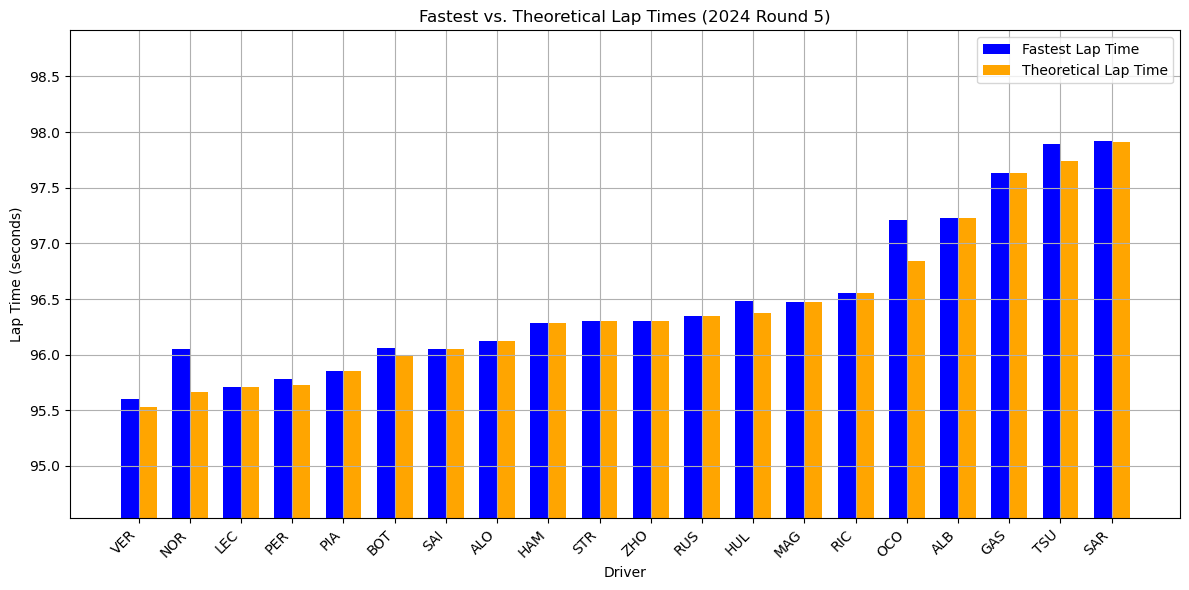

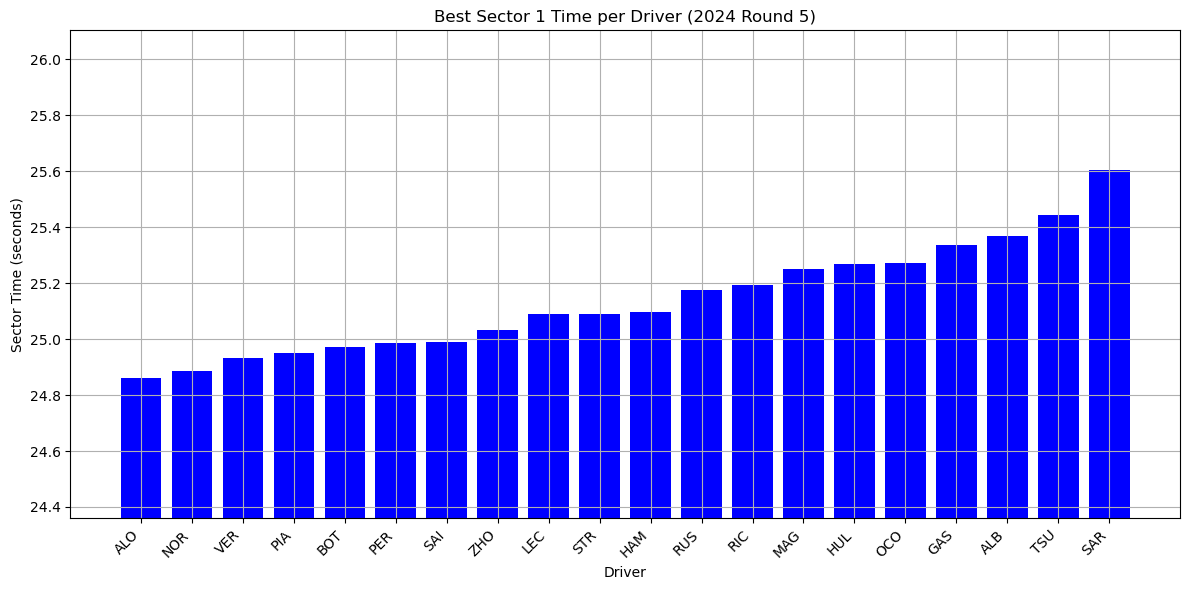

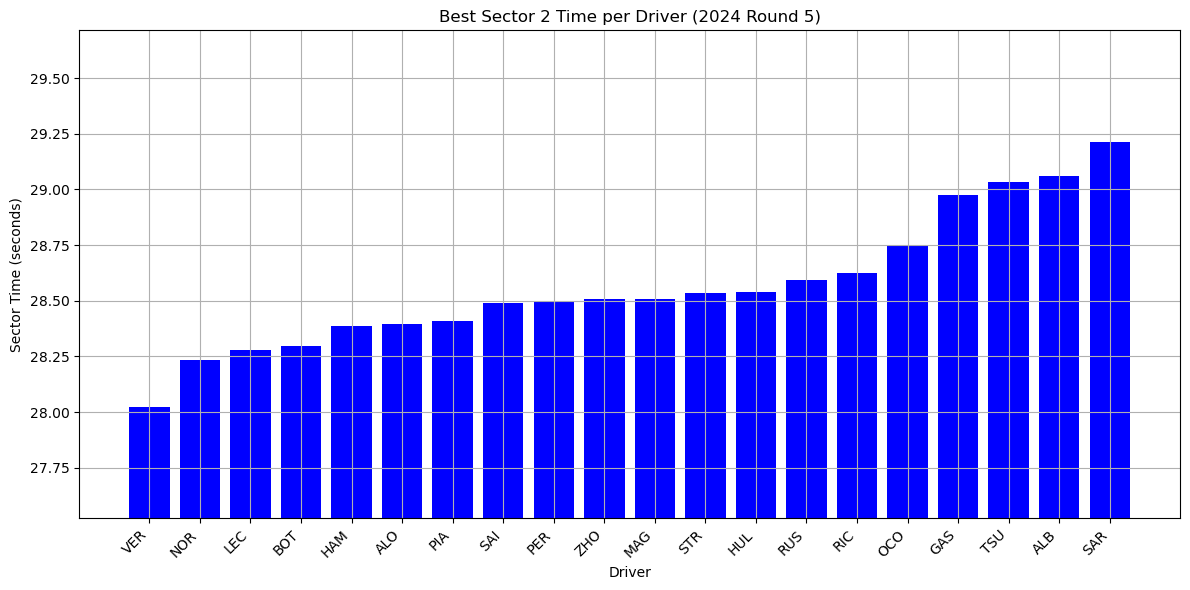

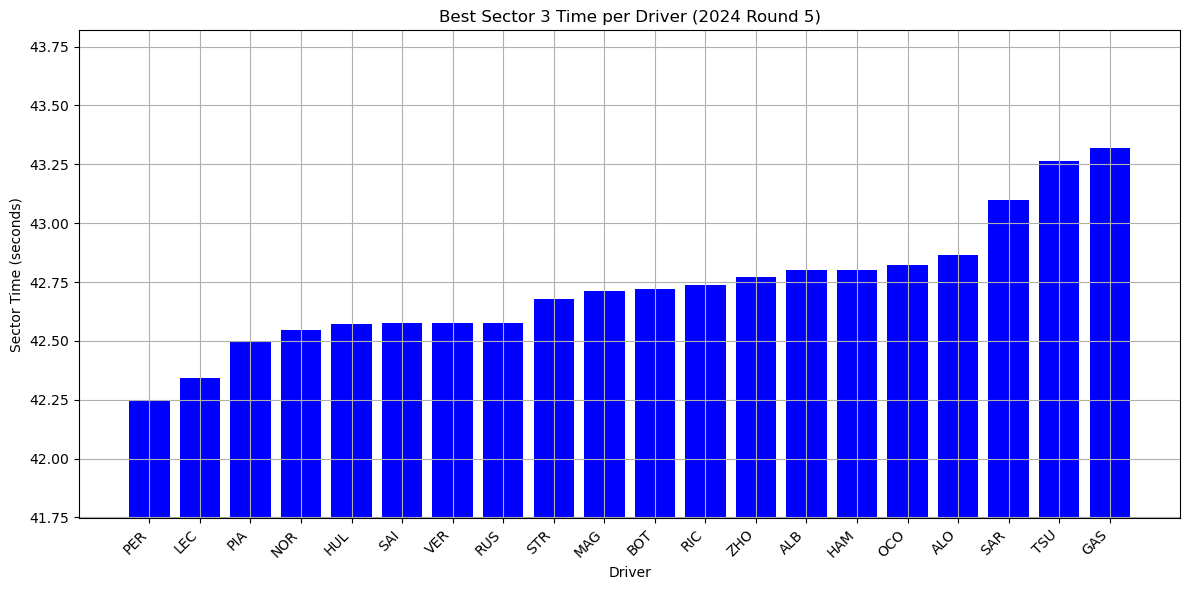

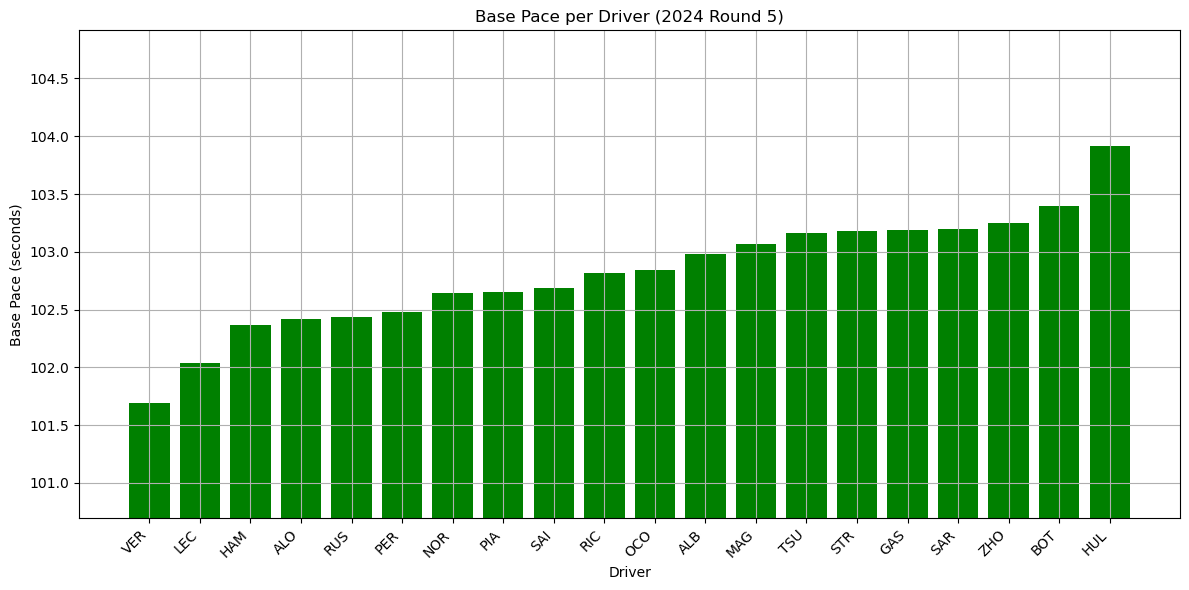

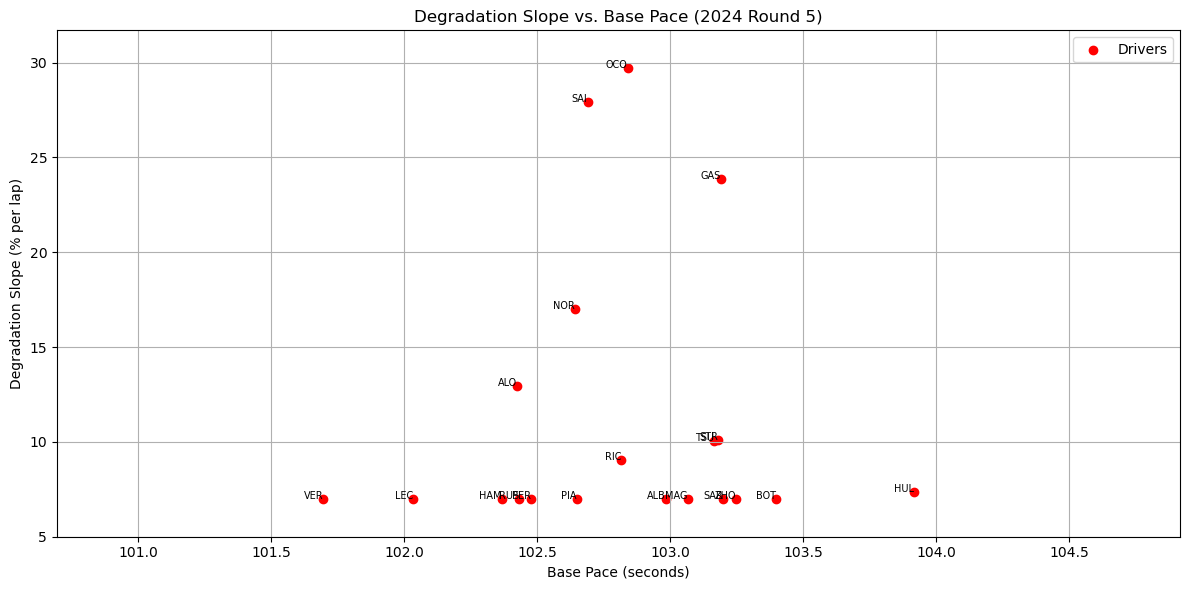

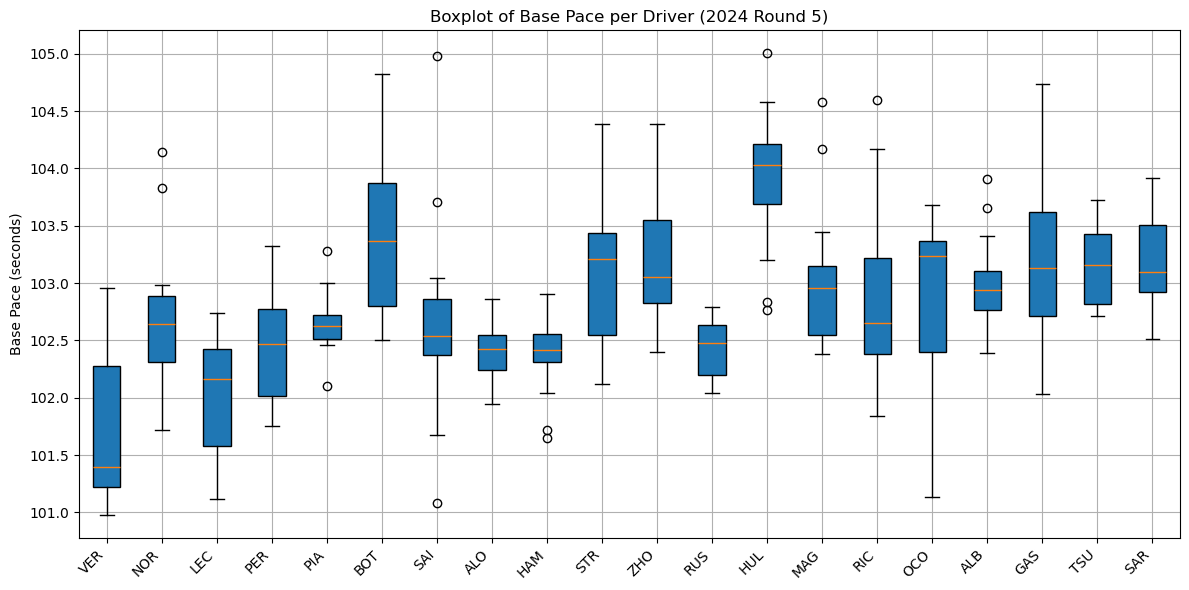


Debug: DegradationSlope values for plot: [7.0, 17.031666666666744, 7.0, 7.0, 7.0, 7.0, 27.936190476190383, 12.934523809523839, 7.0, 10.121363636363762, 7.0, 7.0, 7.358127073232811, 7.0, 9.07069857697283, 29.700000000000973, 7.0, 23.8649749642344, 10.035000000000029, 7.0]


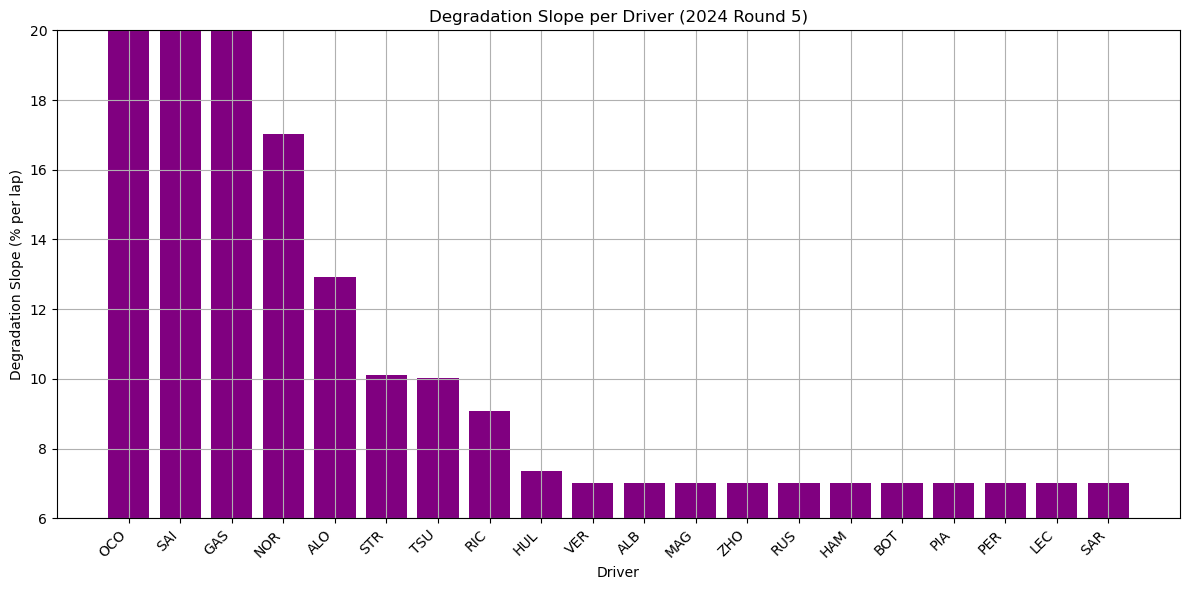


=== How to Read the Output ===
- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.
- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.
- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.
- **BasePace**: The average lap time on long runs (tyre life > 10 laps), reflecting race pace consistency.
- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation, higher values indicate faster tyre wear.
- **Boxplot of BasePace per Driver**: Shows the distribution of long-run lap times for each driver, with median, quartiles, and outliers indicating race pace consistency.
- **Bar Chart of DegradationSlope per Driver**: Displays the individual degradation 

2025-03-18 20:01:03,077 - INFO - Driver performance rows: 20


Saved driver performance to raw_data\2024\R5\2024_R5_driver_performance.csv
Driver performance rows: 20
Driver Performance (Top 5 by FastestLapTime):


,Driver,FastestLapTime,Team,Sector1Time,Sector2Time,Sector3Time,TheoreticalLapTime,BasePace,LapTimeVar,DegradationSlope,LapTimeGap
18,VER,95.606,Red Bull Racing,24.931,28.024,42.576,95.531,101.694882,1.016949,7.000000,7.500000e-02
6,LEC,95.711,Ferrari,25.090,28.277,42.344,95.711,102.033500,1.020335,7.000000,-1.421085e-14
10,PER,95.781,Red Bull Racing,24.985,28.495,42.247,95.727,102.474706,1.024747,7.000000,5.400000e-02
11,PIA,95.853,McLaren,24.949,28.410,42.494,95.853,102.648938,1.026489,7.000000,-1.421085e-14
8,NOR,96.047,McLaren,24.885,28.235,42.548,95.668,102.640231,1.026402,17.031667,3.790000e-01


2025-03-18 20:01:03,090 - INFO - Loading Practice 1 from cache or downloading for telemetry...


Step 6: Analyzing telemetry metrics...


2025-03-18 20:01:27,904 - INFO - Loading Sprint Qualifying from cache or downloading for telemetry...
2025-03-18 20:01:47,264 - INFO - Loading Sprint from cache or downloading for telemetry...
2025-03-18 20:02:07,742 - WARNING - Warning: C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_Practice_3_laps.csv not found. Team info will be incomplete.



Telemetry Metrics (Top 10 by Max Speed):


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
16,STR,329.000000,4.875362,0.191999,Unknown
1,ALO,326.666667,21.418118,0.210064,Unknown
12,RIC,326.666667,45.131261,0.194600,Unknown
15,SAR,325.000000,44.216388,0.198485,Unknown
17,TSU,323.666667,44.499667,0.200059,Unknown
2,BOT,323.333333,48.428356,0.210274,Unknown
8,NOR,323.333333,0.988303,0.186015,Unknown
7,MAG,321.666667,27.841798,0.186092,Unknown
6,LEC,321.333333,0.000000,0.186963,Unknown
9,OCO,321.333333,45.944337,0.215503,Unknown


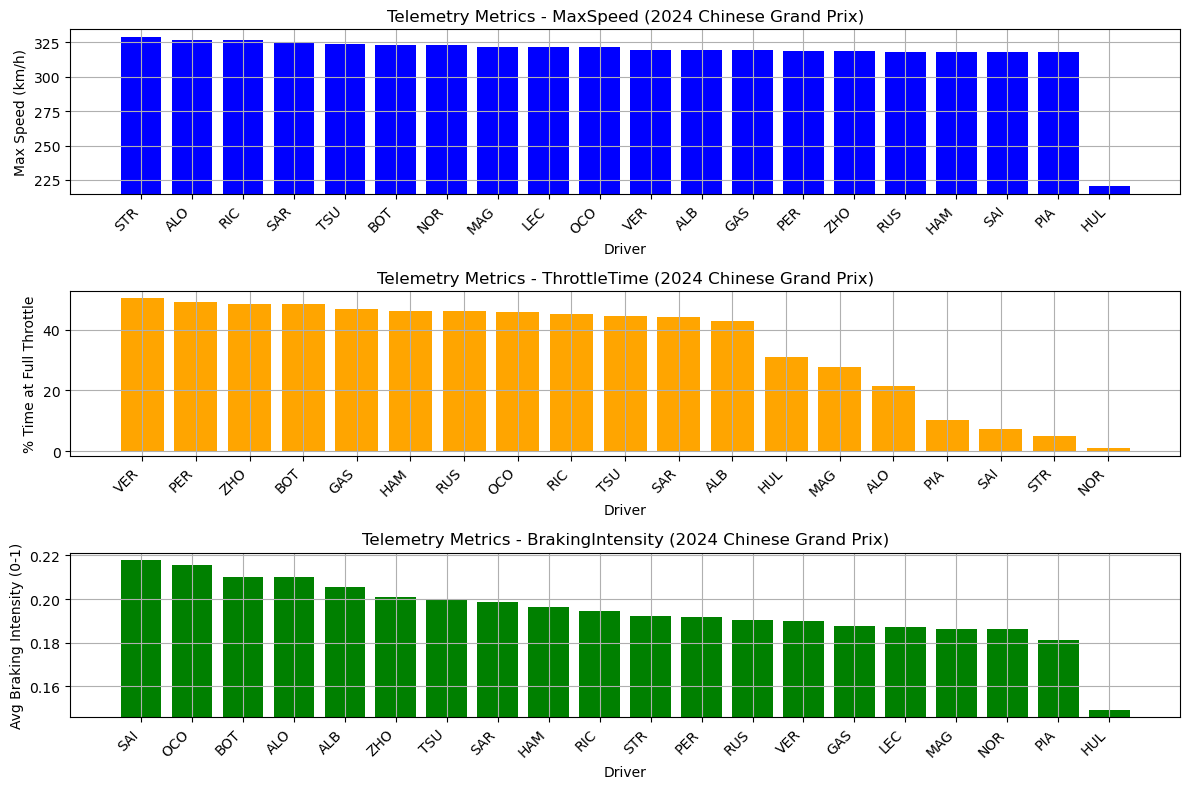

2025-03-18 20:02:08,221 - INFO - Telemetry metrics rows: 20



=== Evaluation and Conclusion ===
Telemetry metrics for 2024 Round 5 - Chinese Grand Prix provide insights into car setup and driver behavior:
- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.
  - Top Performer: STR with 329.00 km/h, indicating strong straight-line speed.
  - Lowest: HUL with 220.33 km/h, possibly prioritizing downforce for cornering over top speed.
- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.
  - Top Performer: VER with 50.34% time at full throttle, suggesting an aggressive approach or high-speed setup.
  - Lowest: NOR with 0.99% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.
  - Missing Thro

,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
16,STR,329.000000,4.875362,0.191999,Unknown
1,ALO,326.666667,21.418118,0.210064,Unknown
12,RIC,326.666667,45.131261,0.194600,Unknown
15,SAR,325.000000,44.216388,0.198485,Unknown
17,TSU,323.666667,44.499667,0.200059,Unknown


2025-03-18 20:02:08,229 - INFO - Base directory: C:\data\Dropbox\dev\F1


Step 7: Investigating sandbagging...

Potential Sandbaggers (Sorted by PredictionDiscrepancy):


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
19,SAR,97.923,Williams,325.000000,44.216388,97.914,0.009,96.502146,1.420854,4.0,20.0,True
18,TSU,97.892,RB,323.666667,44.499667,97.743,0.149,96.500715,1.391285,5.0,19.0,True
17,GAS,97.632,Alpine,319.333333,46.705551,97.632,0.000,96.496063,1.135937,12.5,18.0,True
16,ALB,97.229,Williams,319.333333,42.763322,97.229,0.000,96.496063,0.732937,12.5,17.0,True
15,OCO,97.213,Alpine,321.333333,45.944337,96.839,0.374,96.498210,0.714790,9.5,16.0,True


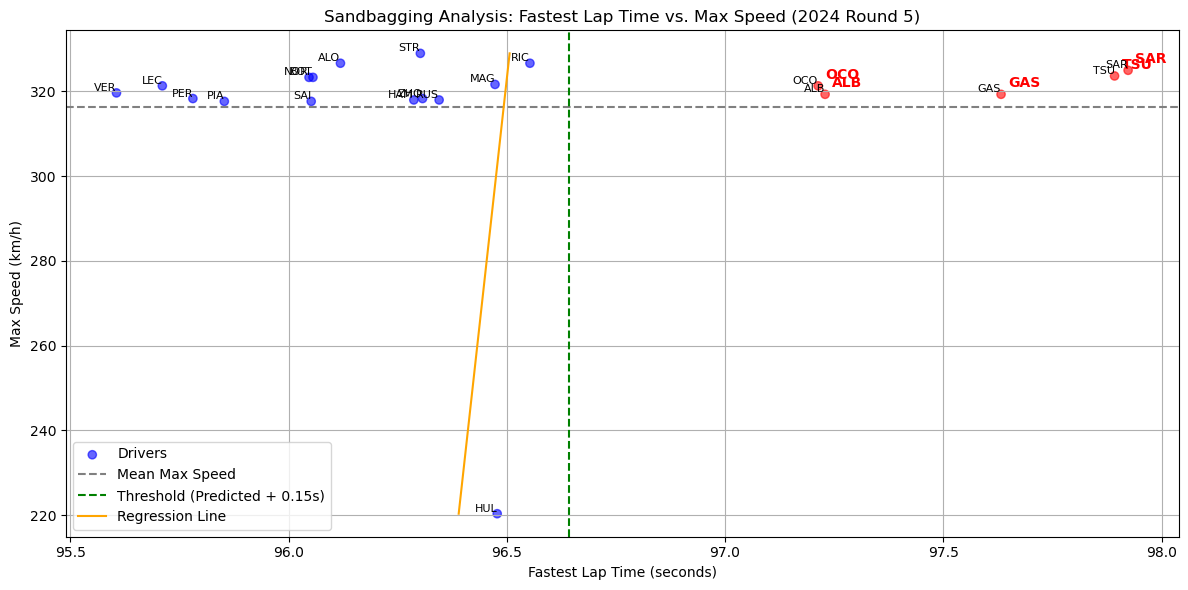

2025-03-18 20:02:08,536 - INFO - Sandbag analysis rows: 20


Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_sandbag_analysis.csv
Sandbag analysis rows: 20
Potential Sandbaggers:


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
19,SAR,97.923,Williams,325.000000,44.216388,97.914,0.009,96.502146,1.420854,4.0,20.0,True
18,TSU,97.892,RB,323.666667,44.499667,97.743,0.149,96.500715,1.391285,5.0,19.0,True
17,GAS,97.632,Alpine,319.333333,46.705551,97.632,0.000,96.496063,1.135937,12.5,18.0,True
16,ALB,97.229,Williams,319.333333,42.763322,97.229,0.000,96.496063,0.732937,12.5,17.0,True
15,OCO,97.213,Alpine,321.333333,45.944337,96.839,0.374,96.498210,0.714790,9.5,16.0,True


Step 8: Evaluating track evolution...
Average lap time for Practice 1: 109.956 seconds (±15.103)
Average lap time for Sprint Qualifying: 111.505 seconds (±14.795)
Average lap time for Sprint: 102.574 seconds (±0.859)
Loading weather for Practice 1 from FastF1...
Available weather columns for Practice 1: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Sprint Qualifying from FastF1...
Available weather columns for Sprint Qualifying: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Sprint from FastF1...
Available weather columns for Sprint: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,109.955757,15.103095,288
1,Sprint Qualifying,111.505239,14.795294,113
2,Sprint,102.573972,0.859121,353



Average Weather Conditions Across Sessions:


WeatherType,AirTemp,Humidity,Rainfall,TrackTemp
Session,,,,
Practice 1,23.142683,22.865854,0.000000,39.468293
Sprint,19.765000,69.537500,0.000000,26.965000
Sprint Qualifying,19.377143,40.800000,0.471429,26.811429



Correlation between TrackTemp and AvgLapTime: 0.343


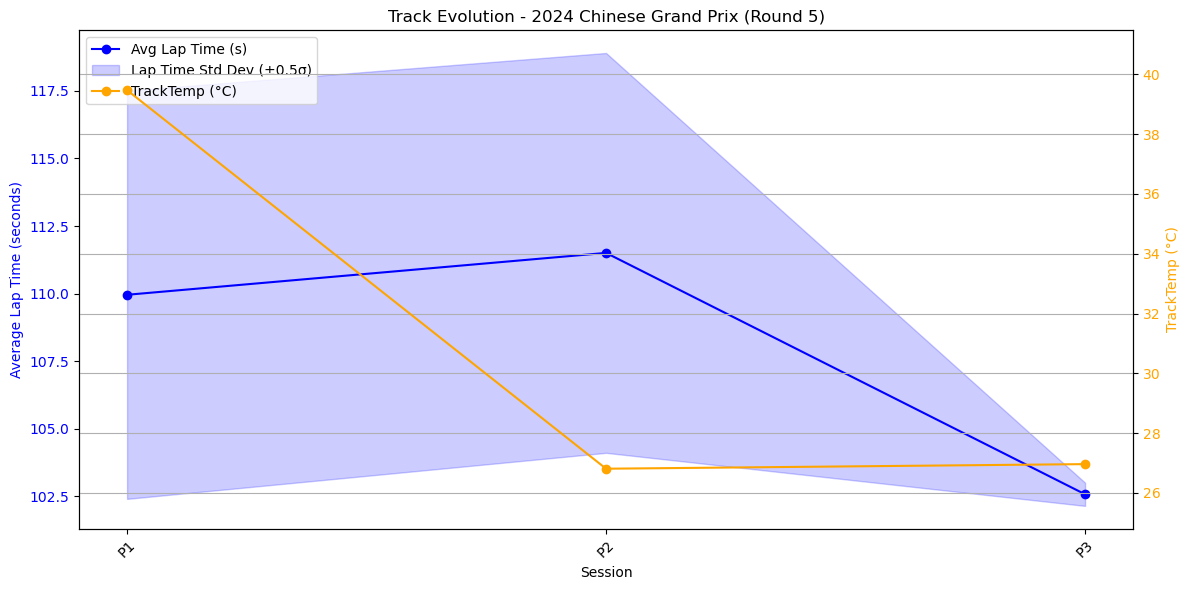

2025-03-18 20:02:16,354 - INFO - Track evolution rows: 3


Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_evolution.csv
Track evolution rows: 3
Track Evolution:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,109.955757,15.103095,288
1,Sprint Qualifying,111.505239,14.795294,113
2,Sprint,102.573972,0.859121,353


Step 9: Analyzing track characteristics...
Error fetching circuit info: Session type 'Practice 3' does not exist for this event

Track Characteristics Analysis for Chinese Grand Prix:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Chinese Grand Prix,High,Easy,3,High,5.388847,Yes



Driver Fit to Track Characteristics (Top 10) - Chinese Grand Prix:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
16,STR,Aston Martin,346.0,35.663287,181.324192,1.175870,1.0
6,LEC,Ferrari,346.0,35.940693,179.924653,1.123701,2.0
12,RIC,RB,344.0,35.690735,181.184745,0.943862,3.0
3,GAS,Alpine,341.0,35.129571,184.079010,0.709126,4.0
10,PER,Red Bull Racing,340.0,34.829937,185.662602,0.652052,5.0
9,OCO,Alpine,342.0,36.231287,178.481562,0.615360,6.0
8,NOR,McLaren,340.0,35.159343,183.923141,0.590104,7.0
17,TSU,RB,341.0,36.353553,177.881286,0.478944,8.0
13,RUS,Mercedes,338.0,34.645019,186.653577,0.459981,9.0
18,VER,Red Bull Racing,336.0,34.853333,185.537970,0.193960,10.0


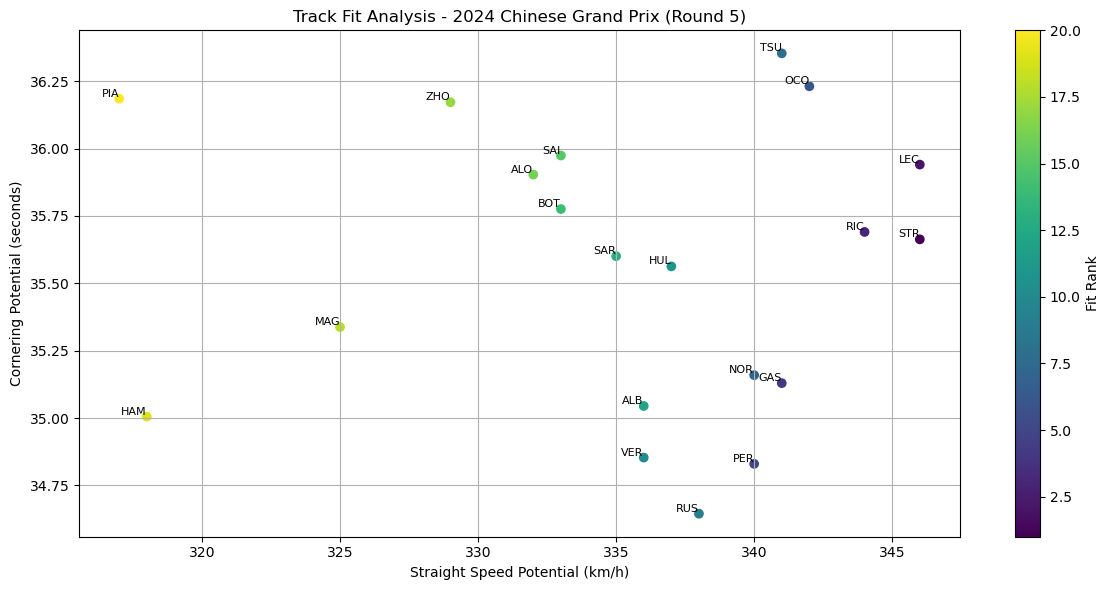

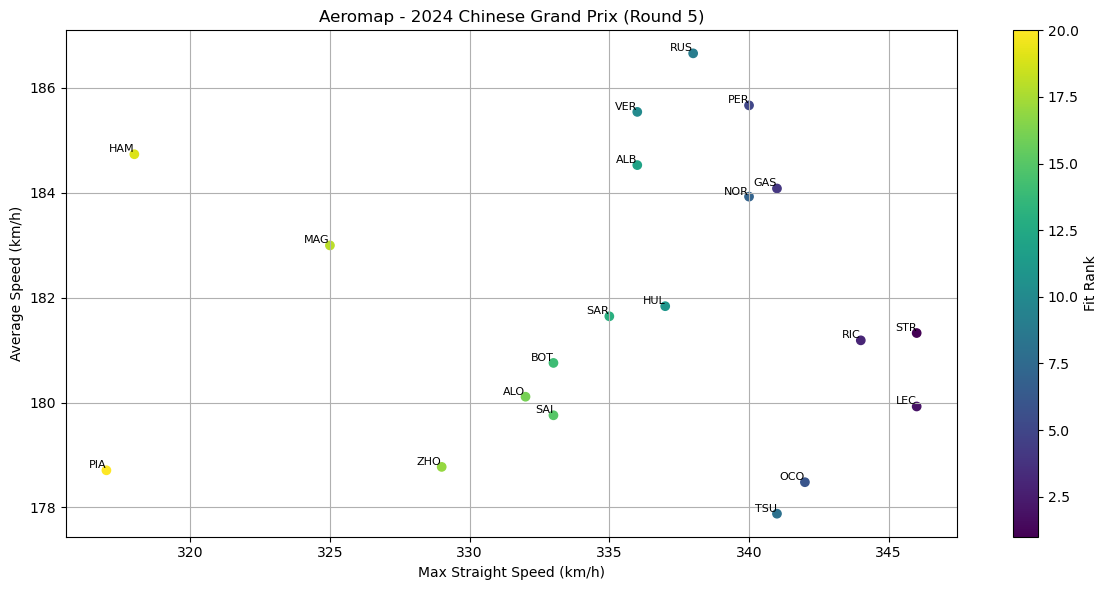

2025-03-18 20:02:16,914 - INFO - Track characteristics drivers rows: 20


Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_characteristics.csv
Saved driver fit data to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_characteristics_drivers.csv
Track characteristics drivers rows: 20
Track Characteristics Drivers (Top 5 by FitRank):


,Driver,Team,SpeedST,Sector1Time,Sector2Time,Sector3Time,LapTime,StraightSpeedPotential,CorneringPotential,AvgSpeed,StraightZScore,CorneringZScore,OverallFit,FitRank
16,STR,Aston Martin,346.0,27.645444,32.566417,46.778000,106.989861,346.0,35.663287,181.324192,1.323437,-0.216451,1.175870,1.0
6,LEC,Ferrari,346.0,27.957763,32.845132,47.019184,107.822079,346.0,35.940693,179.924653,1.323437,-0.760844,1.123701,2.0
12,RIC,RB,344.0,28.354846,32.464205,46.253154,107.072205,344.0,35.690735,181.184745,1.072548,-0.270316,0.943862,3.0
3,GAS,Alpine,341.0,27.826171,31.819486,45.743057,105.388714,341.0,35.129571,184.079010,0.696216,0.830935,0.709126,4.0
10,PER,Red Bull Racing,340.0,27.196351,31.354405,45.939054,104.489811,340.0,34.829937,185.662602,0.570771,1.418950,0.652052,5.0


Step 10: Predicting race outcomes...
No pit_stop_loss found for Chinese Grand Prix in file, using default: 25s

Qualifying Prediction:


,Driver,Team,LapTime,ExpectedLapTime,AdjustedLapTime,QualiPosition
0,VER,Red Bull Racing,95.606,95.531,95.606,1
1,NOR,McLaren,96.047,95.668,95.668,2
2,LEC,Ferrari,95.711,95.711,95.711,3
3,PER,Red Bull Racing,95.781,95.727,95.727,4
4,PIA,McLaren,95.853,95.853,95.853,5
6,SAI,Ferrari,96.052,96.052,96.052,6
5,BOT,Kick Sauber,96.056,95.989,96.056,7
7,ALO,Aston Martin,96.119,96.119,96.119,8
8,HAM,Mercedes,96.287,96.287,96.287,9
9,STR,Aston Martin,96.302,96.302,96.302,10


2025-03-18 20:02:16,956 - ERROR - Error processing Round 5: single positional indexer is out-of-bounds
2025-03-18 20:02:16,957 - INFO - Processing Round 6
2025-03-18 20:02:16,973 - INFO - Fetched 2024 schedule with 25 events.


Error processing Round 5: single positional indexer is out-of-bounds

=== Processing 2024 Round 6 ===
Step 2: Fetching target event info...
Total Events in 2024 Schedule: 25

Target Event Details (Track data TBD until session loaded):


,Round,Event Name,Event Date,Location,Sprint Weekend,Sessions,Track Length (km),Avg Speed (km/h),Downforce Level
0,6,Miami Grand Prix,2024-05-05,Miami,True,"Practice 1, Sprint Qualifying, Sprint",TBD,TBD,TBD



Historical Winners at this Track:


,Year,Winner,Weight
0,2022,VER,1
1,2023,VER,2



Historical Pole Sitters at this Track:


,Year,Pole Sitter,Weight
0,2022,LEC,1
1,2023,PER,2


2025-03-18 20:04:01,568 - INFO - Target event selected: Miami Grand Prix (Round 6) with sessions ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:04:01,569 - INFO - Target event: Miami Grand Prix (Round 6)



Full Event Row from Schedule:
RoundNumber                                                   6
Country                                           United States
Location                                                  Miami
OfficialEventName    FORMULA 1 CRYPTO.COM MIAMI GRAND PRIX 2024
EventDate                                   2024-05-05 00:00:00
EventName                                      Miami Grand Prix
EventFormat                                   sprint_qualifying
Session1                                             Practice 1
Session1Date                          2024-05-03 12:30:00-04:00
Session1DateUtc                             2024-05-03 16:30:00
Session2                                      Sprint Qualifying
Session2Date                          2024-05-03 16:30:00-04:00
Session2DateUtc                             2024-05-03 20:30:00
Session3                                                 Sprint
Session3Date                          2024-05-04 12:00:00-04:00
Session3D

2025-03-18 20:04:22,694 - INFO - Loaded data for Practice 1 with 464 laps.


Saved Practice 1 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Practice_1_laps.csv
Saved Practice 1 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Practice_1_weather.csv
Saved Practice 1 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:14:38.651000,VER,1,NaT,1.0,1.0,0 days 00:12:34.560000,NaT,NaT,0 days 00:00:40.086000,...,True,Red Bull Racing,0 days 00:12:34.560000,2024-05-03 16:31:28.587,1,NaN,False,,False,False
1,0 days 00:16:09.722000,VER,1,0 days 00:01:31.071000,2.0,1.0,NaT,NaT,0 days 00:00:30.747000,0 days 00:00:34.684000,...,True,Red Bull Racing,0 days 00:14:38.651000,2024-05-03 16:33:32.678,1,NaN,False,,False,True
2,0 days 00:18:43.963000,VER,1,NaT,3.0,1.0,NaT,NaT,0 days 00:00:55.371000,0 days 00:01:00.187000,...,True,Red Bull Racing,0 days 00:16:09.722000,2024-05-03 16:35:03.749,12,NaN,False,,False,False
3,0 days 00:30:56.009000,VER,1,NaT,4.0,1.0,NaT,0 days 00:20:30.535000,0 days 00:00:30.209000,NaT,...,True,Red Bull Racing,0 days 00:18:43.963000,2024-05-03 16:37:37.990,251,NaN,False,,False,False
4,0 days 00:32:30.050000,VER,1,NaT,5.0,2.0,0 days 00:30:56.009000,NaT,NaT,0 days 00:00:35.450000,...,False,Red Bull Racing,0 days 00:30:56.009000,2024-05-03 16:49:50.036,1,NaN,False,,False,False



Practice 1 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:01:00.566000,28.5,56.0,1015.6,False,49.7,148,3.0
1,0 days 00:02:00.558000,28.4,58.0,1015.6,False,48.4,180,4.4
2,0 days 00:03:00.567000,28.3,58.0,1015.5,False,46.6,149,2.9
3,0 days 00:04:00.568000,28.3,59.0,1015.5,False,45.0,168,2.7
4,0 days 00:05:00.568000,28.4,59.0,1015.5,False,47.6,152,3.0



Practice 1 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:29.393000,0 days 00:01:48.984545454,-0.033333
1,ALO,0 days 00:01:30.023000,0 days 00:01:46.187235294,-0.100000
2,BOT,0 days 00:01:29.636000,0 days 00:01:50.789411764,-0.100000
3,GAS,0 days 00:01:29.175000,0 days 00:01:49.513000,-0.100000
4,HAM,0 days 00:01:29.012000,0 days 00:01:41.585800,-0.020000
5,HUL,0 days 00:01:29.314000,0 days 00:01:45.525150,-0.100000
6,LEC,0 days 00:01:32.099000,0 days 00:01:32.099000,0.000000
7,MAG,0 days 00:01:29.189000,0 days 00:01:39.130850,-0.100000
8,NOR,0 days 00:01:29.495000,0 days 00:01:45.071588235,0.013370
9,OCO,0 days 00:01:29.163000,0 days 00:01:50.354578947,-0.100000


2025-03-18 20:04:37,071 - INFO - Loaded data for Sprint Qualifying with 230 laps.


Saved Sprint Qualifying lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_Qualifying_laps.csv
Saved Sprint Qualifying weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_Qualifying_weather.csv
Saved Sprint Qualifying indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_Qualifying_indicators.csv

Sprint Qualifying Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:18:21.930000,VER,1,NaT,1.0,1.0,0 days 00:16:17.385000,NaT,NaT,0 days 00:00:44.047000,...,True,Red Bull Racing,0 days 00:16:17.385000,2024-05-03 20:31:48.858,1,NaN,False,,False,False
1,0 days 00:19:50.531000,VER,1,0 days 00:01:28.601000,2.0,1.0,NaT,NaT,0 days 00:00:29.497000,0 days 00:00:33.914000,...,True,Red Bull Racing,0 days 00:18:21.930000,2024-05-03 20:33:53.403,1,NaN,False,,False,True
2,0 days 00:21:52.961000,VER,1,0 days 00:02:02.430000,3.0,1.0,NaT,NaT,0 days 00:00:46.074000,0 days 00:00:43.092000,...,True,Red Bull Racing,0 days 00:19:50.531000,2024-05-03 20:35:22.004,1,NaN,False,,False,True
3,0 days 00:23:49.557000,VER,1,0 days 00:01:56.596000,4.0,1.0,NaT,NaT,0 days 00:00:43.439000,0 days 00:00:45.589000,...,True,Red Bull Racing,0 days 00:21:52.961000,2024-05-03 20:37:24.434,1,NaN,False,,False,True
4,0 days 00:25:17.751000,VER,1,0 days 00:01:28.194000,5.0,1.0,NaT,NaT,0 days 00:00:29.522000,0 days 00:00:33.623000,...,True,Red Bull Racing,0 days 00:23:49.557000,2024-05-03 20:39:21.030,1,NaN,False,,False,True



Sprint Qualifying Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:24.176000,28.8,56.0,1014.2,False,50.8,177,2.9
1,0 days 00:01:24.194000,28.7,56.0,1014.2,False,50.8,171,3.7
2,0 days 00:02:24.203000,28.7,57.0,1014.2,False,49.8,184,4.6
3,0 days 00:03:24.201000,28.6,57.0,1014.2,False,49.9,172,3.1
4,0 days 00:04:24.202000,28.6,57.0,1014.2,False,49.9,180,3.7



Sprint Qualifying Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:29.112000,0 days 00:01:48.406500,0.000000
1,ALO,0 days 00:01:28.189000,0 days 00:01:46.315625,0.050000
2,BOT,0 days 00:01:29.360000,0 days 00:01:42.847166666,0.000000
3,GAS,0 days 00:01:29.185000,0 days 00:01:48.167600,0.000000
4,HAM,0 days 00:01:28.371000,0 days 00:01:53.026300,0.100000
5,HUL,0 days 00:01:28.330000,0 days 00:01:39.414250,-0.050000
6,LEC,0 days 00:01:27.749000,0 days 00:01:44.671846153,0.000000
7,MAG,0 days 00:01:28.377000,0 days 00:01:47.666700,0.000000
8,NOR,0 days 00:01:27.597000,0 days 00:01:43.643375,0.050000
9,OCO,0 days 00:01:28.379000,0 days 00:01:48.048400,0.000000


2025-03-18 20:04:55,123 - INFO - Loaded data for Sprint with 344 laps.


Saved Sprint lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_laps.csv
Saved Sprint weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_weather.csv
Saved Sprint indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Sprint_indicators.csv

Sprint Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:45:46.906000,VER,1,NaT,1.0,1.0,NaT,0 days 00:45:39.966000,NaT,0 days 00:00:34.705000,...,False,Red Bull Racing,0 days 00:43:47.919000,2024-05-04 16:03:39.995,124,1.0,False,,False,False
1,0 days 00:48:19.287000,VER,1,NaT,2.0,2.0,0 days 00:45:59.491000,0 days 00:48:13.160000,0 days 00:00:59.927000,0 days 00:00:49.321000,...,False,Red Bull Racing,0 days 00:45:46.906000,2024-05-04 16:05:38.982,4,1.0,False,,False,False
2,0 days 00:51:01.653000,VER,1,NaT,3.0,3.0,0 days 00:48:30.775000,NaT,0 days 00:00:56.413000,0 days 00:00:49.708000,...,False,Red Bull Racing,0 days 00:48:19.287000,2024-05-04 16:08:11.363,41,1.0,False,,False,False
3,0 days 00:52:32.068000,VER,1,0 days 00:01:30.415000,4.0,3.0,NaT,NaT,0 days 00:00:30.295000,0 days 00:00:34.452000,...,False,Red Bull Racing,0 days 00:51:01.653000,2024-05-04 16:10:53.729,1,1.0,False,,False,True
4,0 days 00:54:02.824000,VER,1,0 days 00:01:30.756000,5.0,3.0,NaT,NaT,0 days 00:00:30.402000,0 days 00:00:34.565000,...,False,Red Bull Racing,0 days 00:52:32.068000,2024-05-04 16:12:24.144,1,1.0,False,,False,True



Sprint Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:07.822000,28.4,59.0,1016.8,False,40.0,160,3.5
1,0 days 00:01:07.808000,28.4,58.0,1016.8,False,40.0,150,3.2
2,0 days 00:02:07.815000,28.4,58.0,1016.8,False,40.0,169,3.0
3,0 days 00:03:07.806000,28.2,57.0,1016.9,False,41.3,172,3.1
4,0 days 00:04:07.816000,28.4,57.0,1016.8,False,41.3,147,3.6



Sprint Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:32.223000,0 days 00:01:38.734111111,-0.1
1,ALO,0 days 00:01:32.355000,0 days 00:01:36.830882352,0.1
2,BOT,0 days 00:01:32.462000,0 days 00:01:38.825833333,-0.1
3,GAS,0 days 00:01:32.148000,0 days 00:01:35.937000,0.0
4,HAM,0 days 00:01:31.830000,0 days 00:01:32.699375,0.0
5,HUL,0 days 00:01:31.939000,0 days 00:01:32.303625,0.0
6,LEC,0 days 00:01:30.807000,0 days 00:01:31.286875,0.0
7,MAG,0 days 00:01:32.113000,0 days 00:01:32.849437500,0.0
8,NOR,NaT,NaT,0.0
9,OCO,0 days 00:01:32.218000,0 days 00:01:35.798882352,0.0


2025-03-18 20:04:55,473 - INFO - Session data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:04:55,477 - INFO - Cleaning Practice 1 data...
2025-03-18 20:04:55,479 - INFO - Raw Laps in Practice 1: 464
2025-03-18 20:04:55,489 - INFO - After Deleting Removed/Keeping Accurate: 299
2025-03-18 20:04:55,497 - INFO - After Dropping Fully NaN Laps: 299
2025-03-18 20:04:55,516 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 226
2025-03-18 20:04:55,630 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R6\cleaned_data\2024_R6_Practice_1_cleaned_laps.csv
2025-03-18 20:04:55,631 - INFO - Cleaning Sprint Qualifying data...
2025-03-18 20:04:55,633 - INFO - Raw Laps in Sprint Qualifying: 230



Download Summary:
Practice 1: 464 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weather: 77 records
  Indicators: 20 drivers
Sprint Qualifying: 230 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']

2025-03-18 20:04:55,647 - INFO - After Deleting Removed/Keeping Accurate: 110
2025-03-18 20:04:55,657 - INFO - After Dropping Fully NaN Laps: 110
2025-03-18 20:04:55,678 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 95
2025-03-18 20:04:55,752 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R6\cleaned_data\2024_R6_Sprint_Qualifying_cleaned_laps.csv
2025-03-18 20:04:55,755 - INFO - Cleaning Sprint data...
2025-03-18 20:04:55,758 - INFO - Raw Laps in Sprint: 344
2025-03-18 20:04:55,772 - INFO - After Deleting Removed/Keeping Accurate: 280
2025-03-18 20:04:55,780 - INFO - After Dropping Fully NaN Laps: 280
2025-03-18 20:04:55,800 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 280
2025-03-18 20:04:55,903 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R6\cleaned_data\2024_R6_Sprint_cleaned_laps.csv
2025-03-18 20:04:55,914 - INFO - Total Raw Laps: 1038
2025-03-18 20:04:55,917 - INFO - Total Cleaned Laps: 689
2025-03-18 20:04:55,920

Driver  FastestLap  AvgLapTime  LapTimeStd  LapCount
   NOR      87.597   90.176625    1.882282        13
   VER      87.641   90.713090    0.975373        33
   LEC      87.749   91.664101    4.379663        24
   PER      87.865   90.588234    0.835279        30
   RIC      88.044   92.571519    3.634473        35


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
8,NOR,87.597,90.176625,1.882282,13
18,VER,87.641,90.713090,0.975373,33
6,LEC,87.749,91.664101,4.379663,24
10,PER,87.865,90.588234,0.835279,30
12,RIC,88.044,92.571519,3.634473,35
11,PIA,88.056,93.272619,7.058046,32
14,SAI,88.103,90.933444,2.227409,33
1,ALO,88.189,92.467579,3.542714,30
16,STR,88.323,91.745236,3.961704,19
5,HUL,88.330,91.383250,0.956699,32


2025-03-18 20:04:55,958 - INFO - Saved aggregated practice summary to C:\data\Dropbox\dev\F1\raw_data\2024\R6\cleaned_data\2024_R6_practice_summary.csv
2025-03-18 20:04:55,961 - INFO - Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-18 20:04:55,965 - INFO - Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']


Cleaned data keys: ['Practice 1', 'Sprint Qualifying', 'Sprint']
Driver Summary (Top 5):


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
8,NOR,87.597,90.176625,1.882282,13
18,VER,87.641,90.713090,0.975373,33
6,LEC,87.749,91.664101,4.379663,24
10,PER,87.865,90.588234,0.835279,30
12,RIC,88.044,92.571519,3.634473,35


Step 5: Computing driver performance...

Driver Performance (sorted by TheoreticalLapTime):


,Driver,FastestLapTime,TheoreticalLapTime,Sector1Time,Sector2Time,Sector3Time,BasePace,DegradationSlope,Team
8,NOR,87.597,87.474,29.112,33.438,24.924,91.521000,30.560000,McLaren
18,VER,87.641,87.601,29.036,33.604,24.961,91.619765,7.000000,Red Bull Racing
10,PER,87.865,87.742,29.250,33.514,24.978,91.682059,7.000000,Red Bull Racing
6,LEC,87.749,87.749,29.233,33.570,24.946,91.290222,7.000000,Ferrari
11,PIA,88.056,87.813,29.227,33.609,24.977,91.981538,10.200000,McLaren
14,SAI,88.103,87.848,29.208,33.593,25.047,91.876750,11.225000,Ferrari
1,ALO,88.189,87.967,29.299,33.596,25.072,92.877941,7.000000,Aston Martin
12,RIC,88.044,88.000,29.266,33.634,25.100,92.084231,7.000000,RB
5,HUL,88.330,88.149,29.491,33.719,24.939,92.708900,7.000000,Haas F1 Team
9,OCO,88.379,88.250,29.372,33.859,25.019,92.548786,20.565000,Alpine


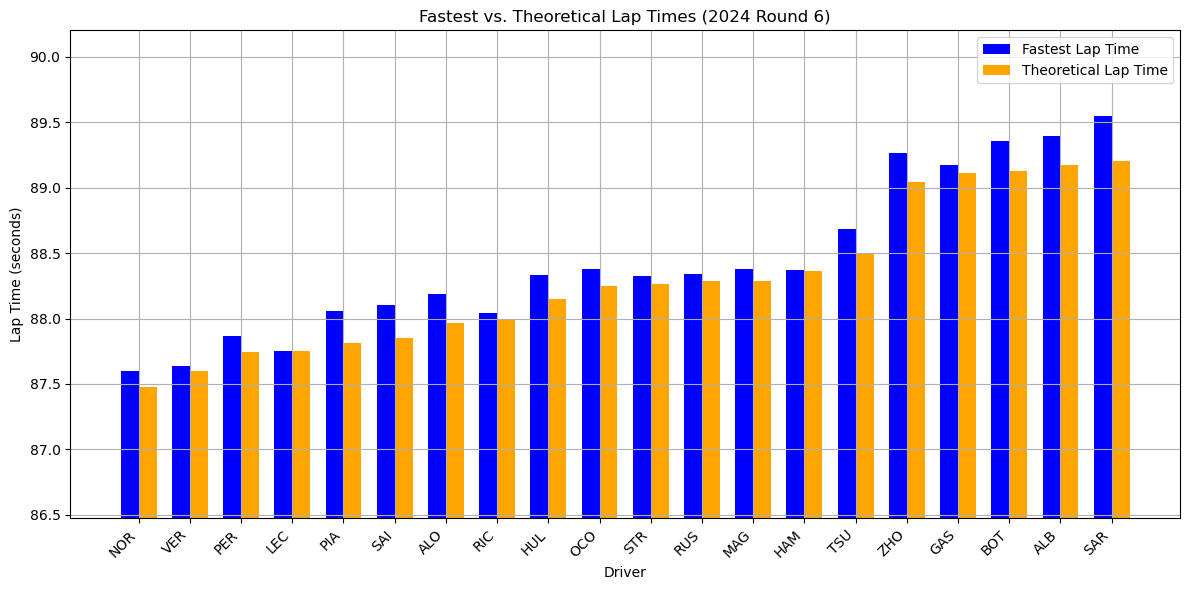

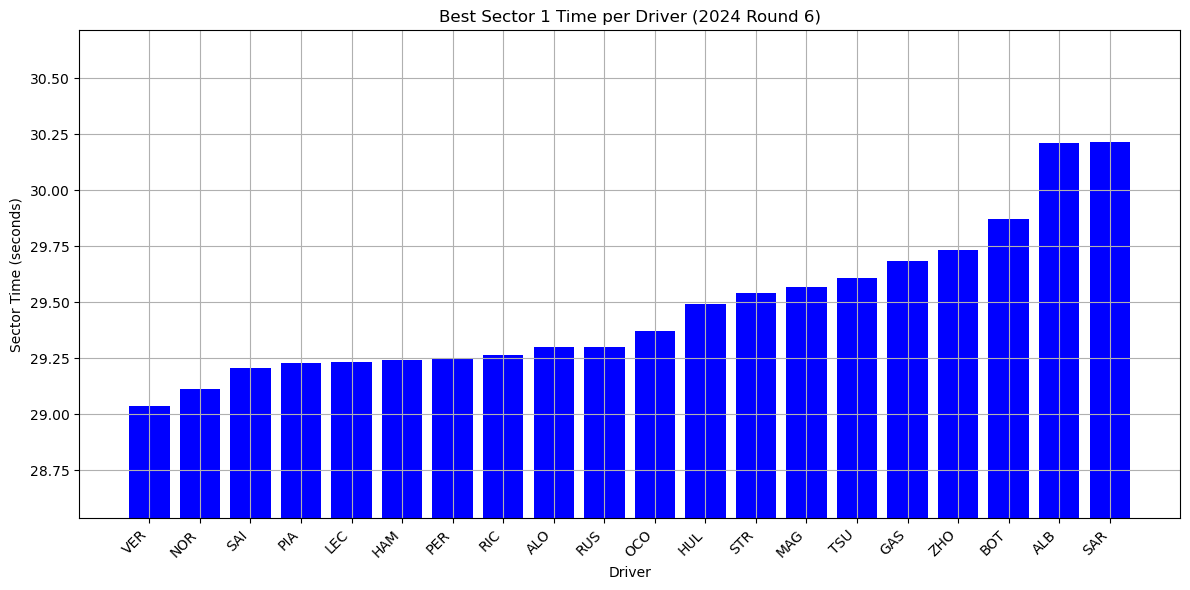

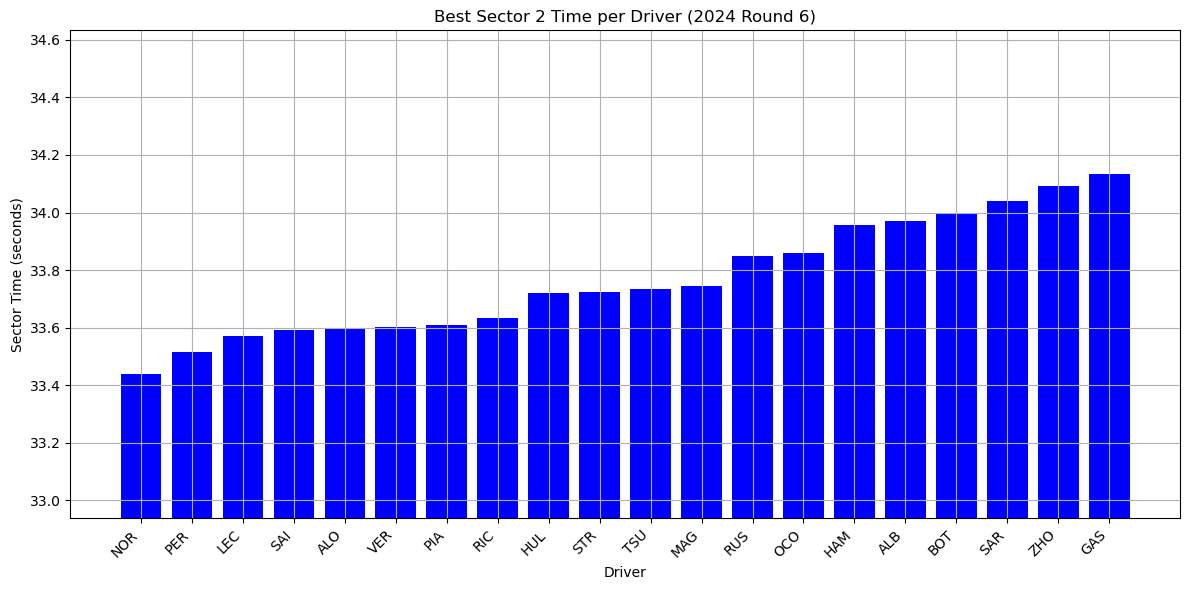

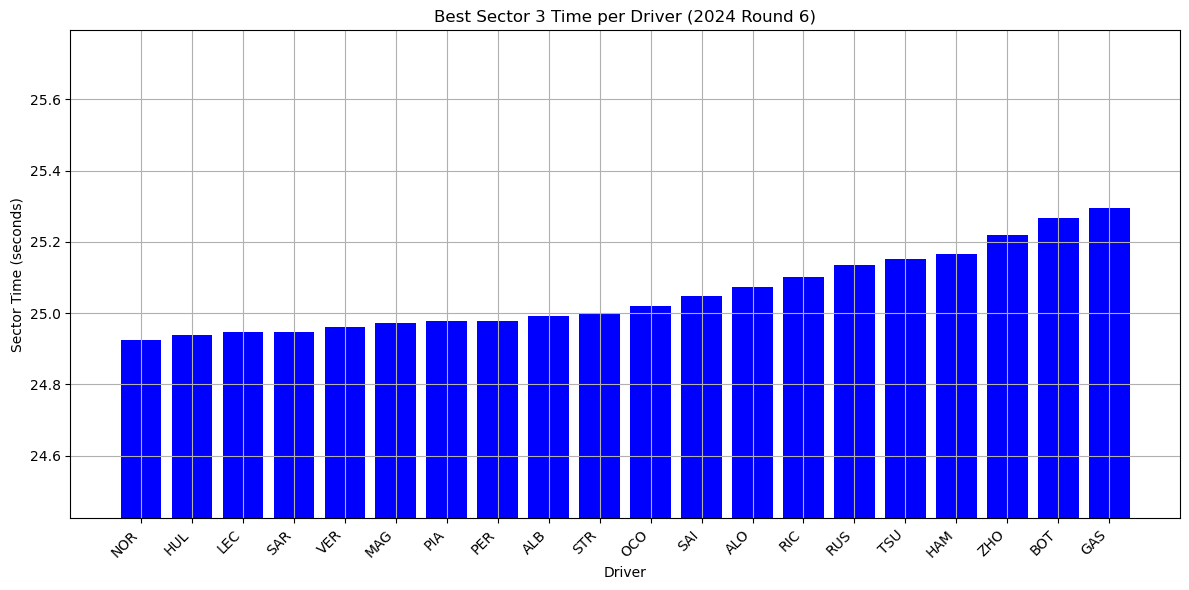

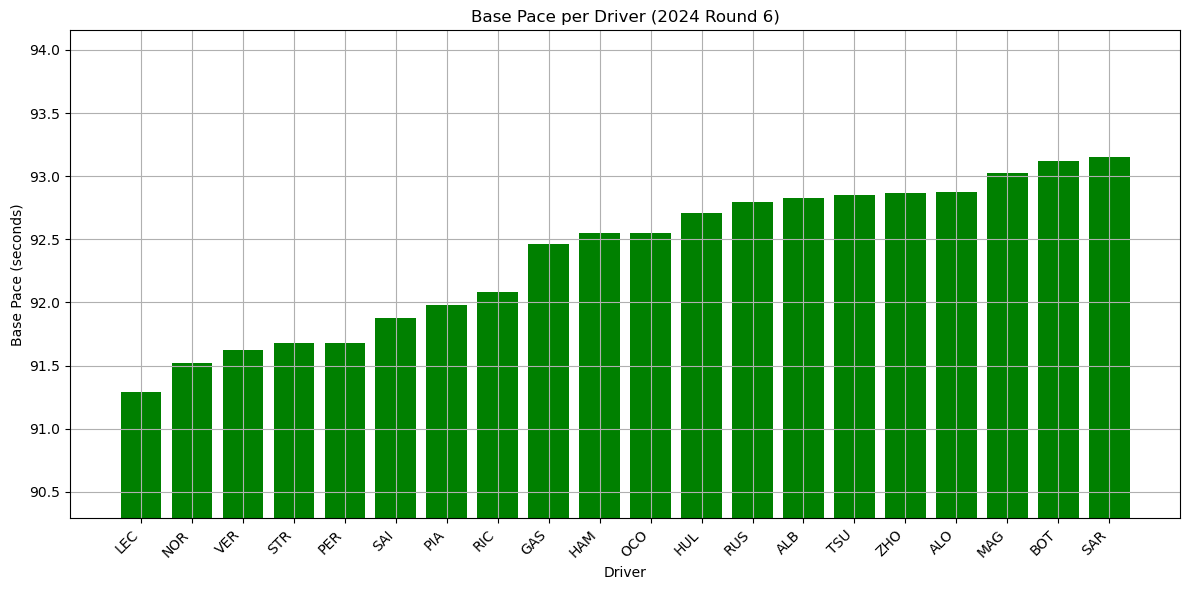

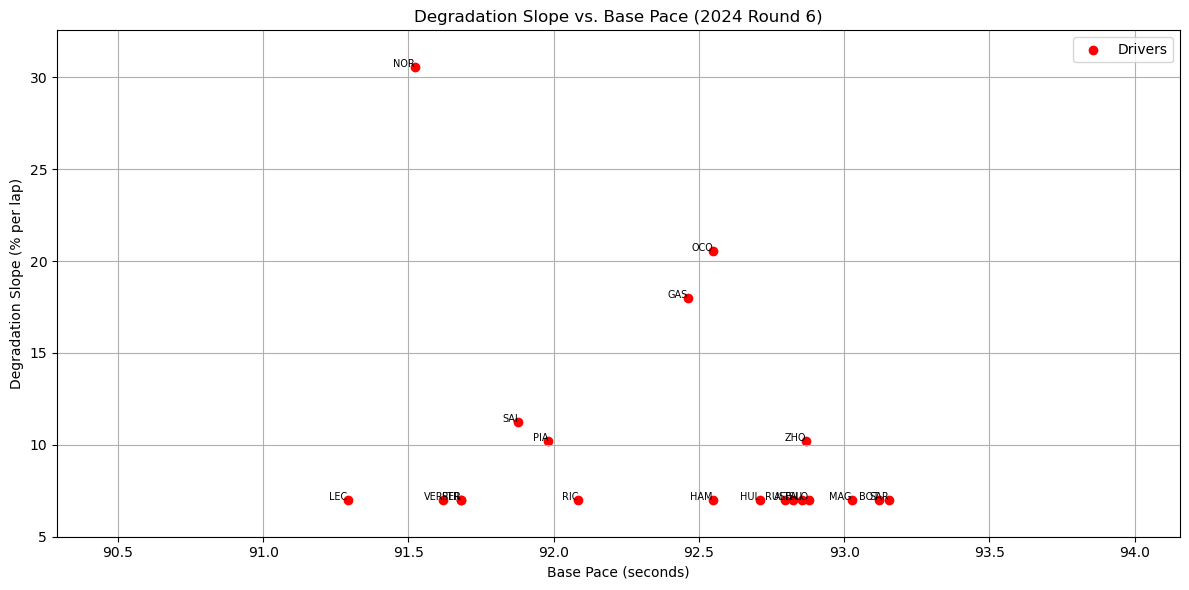

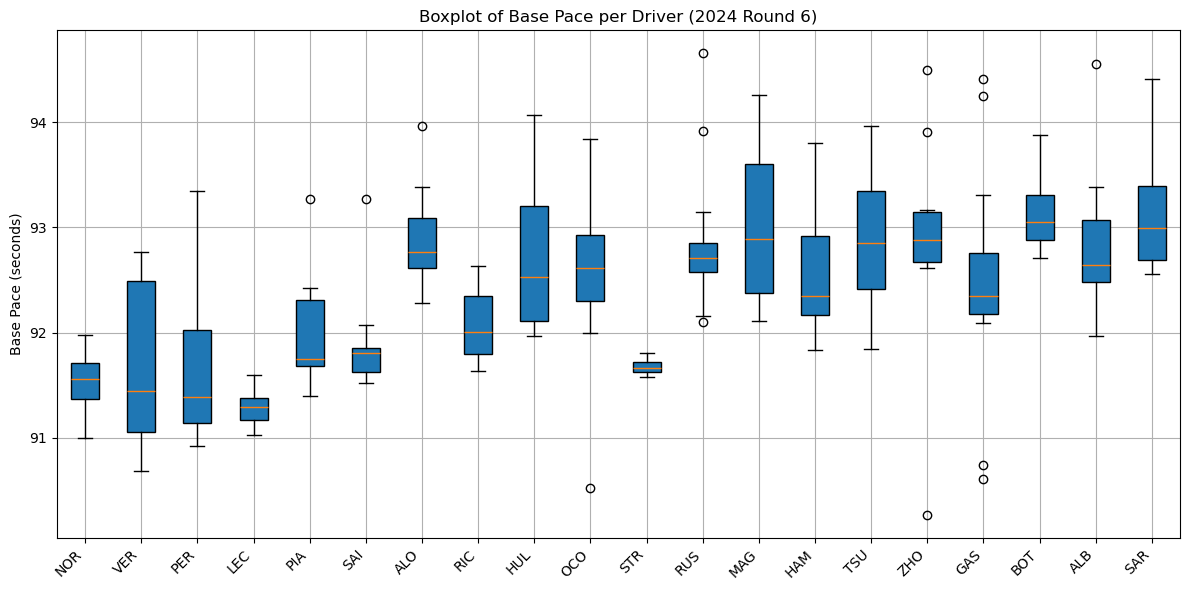


Debug: DegradationSlope values for plot: [30.559999999999874, 7.0, 7.0, 7.0, 10.20000000000013, 11.225000000000618, 7.0, 7.0, 7.0, 20.565000000000122, 7.0, 7.0, 7.0, 7.0, 7.0, 10.204552129221565, 18.00357142857112, 7.0, 7.0, 7.0]


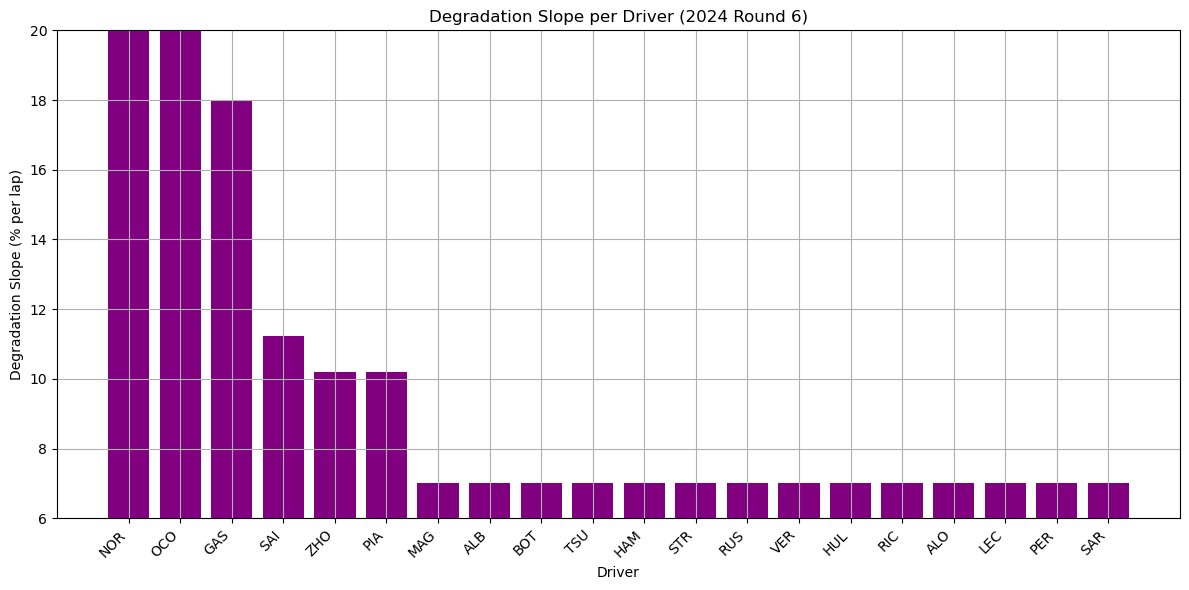

2025-03-18 20:05:00,644 - INFO - Driver performance rows: 20



=== How to Read the Output ===
- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.
- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.
- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.
- **BasePace**: The average lap time on long runs (tyre life > 10 laps), reflecting race pace consistency.
- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation, higher values indicate faster tyre wear.
- **Boxplot of BasePace per Driver**: Shows the distribution of long-run lap times for each driver, with median, quartiles, and outliers indicating race pace consistency.
- **Bar Chart of DegradationSlope per Driver**: Displays the individual degradation 

,Driver,FastestLapTime,Team,Sector1Time,Sector2Time,Sector3Time,TheoreticalLapTime,BasePace,LapTimeVar,DegradationSlope,LapTimeGap
8,NOR,87.597,McLaren,29.112,33.438,24.924,87.474,91.521000,0.915210,30.56,0.123
18,VER,87.641,Red Bull Racing,29.036,33.604,24.961,87.601,91.619765,0.916198,7.00,0.040
6,LEC,87.749,Ferrari,29.233,33.570,24.946,87.749,91.290222,0.912902,7.00,0.000
10,PER,87.865,Red Bull Racing,29.250,33.514,24.978,87.742,91.682059,0.916821,7.00,0.123
12,RIC,88.044,RB,29.266,33.634,25.100,88.000,92.084231,0.920842,7.00,0.044


2025-03-18 20:05:00,659 - INFO - Loading Practice 1 from cache or downloading for telemetry...


Step 6: Analyzing telemetry metrics...


2025-03-18 20:05:14,702 - INFO - Loading Sprint Qualifying from cache or downloading for telemetry...
2025-03-18 20:05:21,239 - INFO - Loading Sprint from cache or downloading for telemetry...
2025-03-18 20:05:28,678 - WARNING - Error loading Sprint: attempt to get argmin of an empty sequence. Skipping session.
2025-03-18 20:05:28,680 - WARNING - Warning: C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_Practice_3_laps.csv not found. Team info will be incomplete.



Telemetry Metrics (Top 10 by Max Speed):


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
0,ALB,343.0,49.452552,0.211125,Unknown
15,SAR,342.5,52.682777,0.182499,Unknown
10,PER,341.5,55.545343,0.167840,Unknown
16,STR,341.0,5.637372,0.175170,Unknown
7,MAG,341.0,23.549643,0.167110,Unknown
5,HUL,340.5,52.906523,0.178677,Unknown
8,NOR,340.5,0.000000,0.148804,Unknown
19,ZHO,339.0,52.364588,0.172842,Unknown
18,VER,339.0,56.985656,0.181987,Unknown
11,PIA,338.5,12.047938,0.162332,Unknown


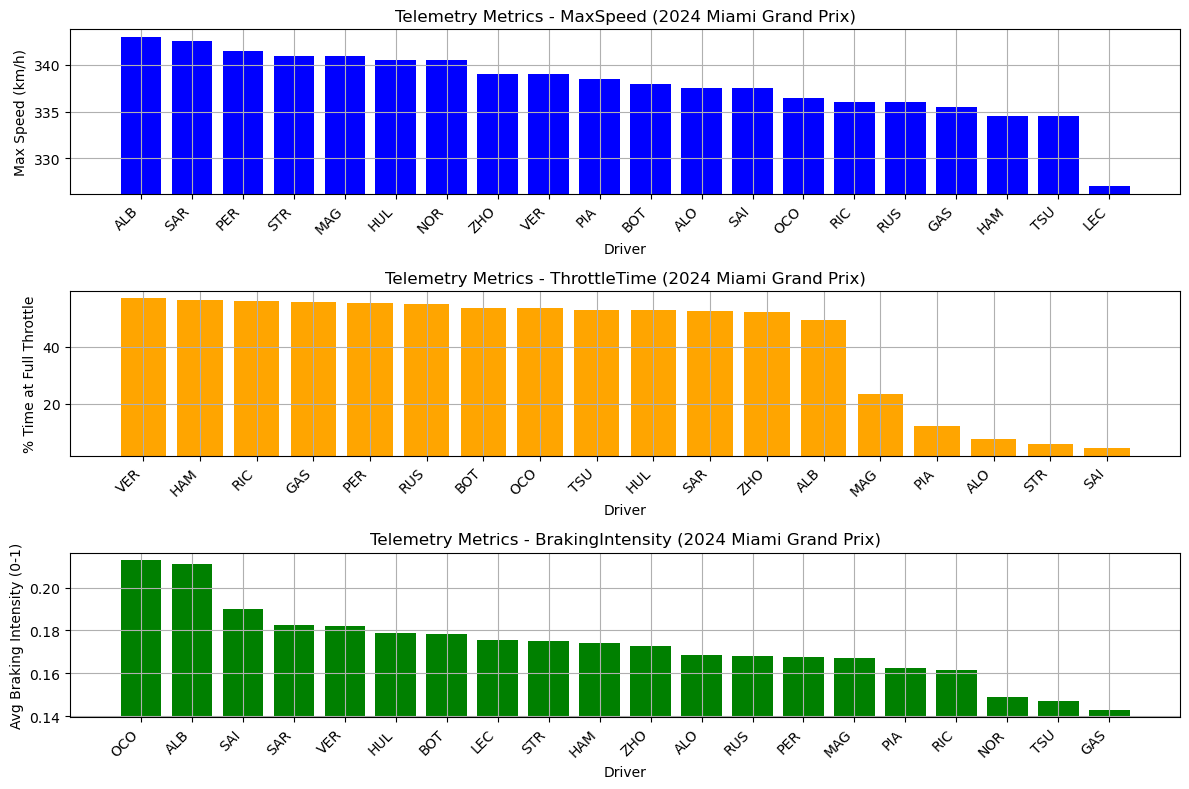

2025-03-18 20:05:29,166 - INFO - Telemetry metrics rows: 20



=== Evaluation and Conclusion ===
Telemetry metrics for 2024 Round 6 - Miami Grand Prix provide insights into car setup and driver behavior:
- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.
  - Top Performer: ALB with 343.00 km/h, indicating strong straight-line speed.
  - Lowest: LEC with 327.00 km/h, possibly prioritizing downforce for cornering over top speed.
- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.
  - Top Performer: VER with 56.99% time at full throttle, suggesting an aggressive approach or high-speed setup.
  - Lowest: SAI with 4.37% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.
  - Missing Thrott

,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
0,ALB,343.0,49.452552,0.211125,Unknown
15,SAR,342.5,52.682777,0.182499,Unknown
10,PER,341.5,55.545343,0.167840,Unknown
16,STR,341.0,5.637372,0.175170,Unknown
7,MAG,341.0,23.549643,0.167110,Unknown


2025-03-18 20:05:29,173 - INFO - Base directory: C:\data\Dropbox\dev\F1


Step 7: Investigating sandbagging...

Potential Sandbaggers (Sorted by PredictionDiscrepancy):


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
17,BOT,89.360,Kick Sauber,338.0,53.769447,89.130,0.230,88.441106,0.918894,11.0,18.0,True
19,SAR,89.551,Williams,342.5,52.682777,89.203,0.348,88.640121,0.910879,2.0,20.0,True
15,ZHO,89.267,Kick Sauber,339.0,52.364588,89.045,0.222,88.485331,0.781669,8.5,17.0,True
18,ALB,89.393,Williams,343.0,49.452552,89.171,0.222,88.662234,0.730766,1.0,19.0,True


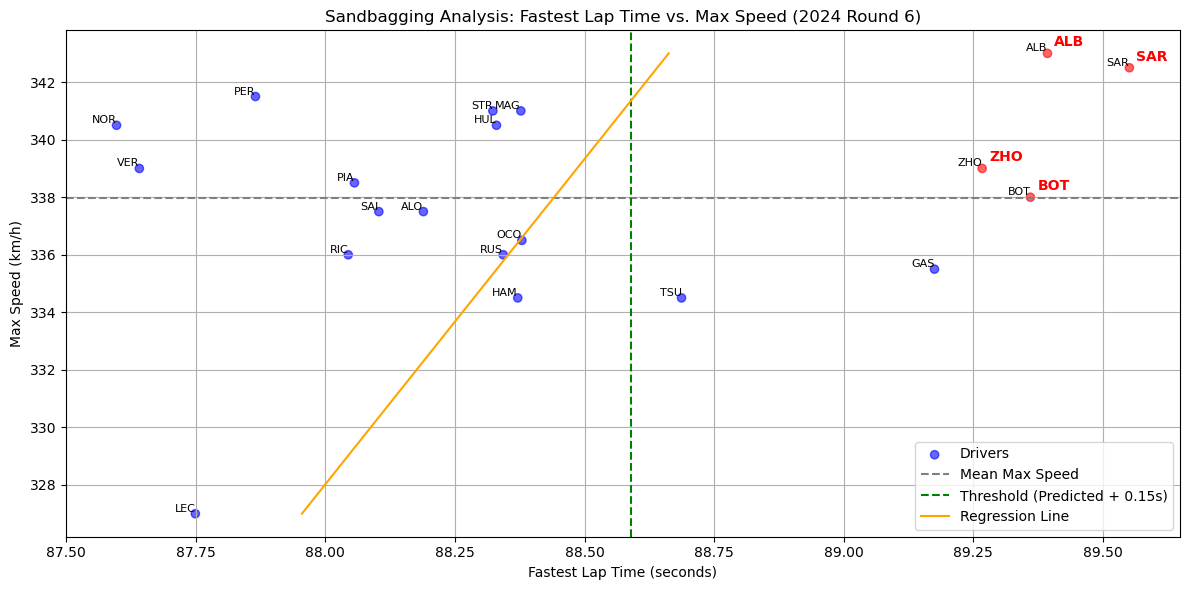

2025-03-18 20:05:29,513 - INFO - Sandbag analysis rows: 20


Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_sandbag_analysis.csv
Sandbag analysis rows: 20
Potential Sandbaggers:


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
17,BOT,89.360,Kick Sauber,338.0,53.769447,89.130,0.230,88.441106,0.918894,11.0,18.0,True
19,SAR,89.551,Williams,342.5,52.682777,89.203,0.348,88.640121,0.910879,2.0,20.0,True
15,ZHO,89.267,Kick Sauber,339.0,52.364588,89.045,0.222,88.485331,0.781669,8.5,17.0,True
18,ALB,89.393,Williams,343.0,49.452552,89.171,0.222,88.662234,0.730766,1.0,19.0,True


Step 8: Evaluating track evolution...
Average lap time for Practice 1: 104.386 seconds (±18.612)
Average lap time for Sprint Qualifying: 99.466 seconds (±15.699)
Average lap time for Sprint: 92.398 seconds (±0.802)
Loading weather for Practice 1 from FastF1...
Available weather columns for Practice 1: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Sprint Qualifying from FastF1...
Available weather columns for Sprint Qualifying: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Sprint from FastF1...
Available weather columns for Sprint: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,104.385809,18.611590,299
1,Sprint Qualifying,99.465809,15.698561,110
2,Sprint,92.397932,0.802273,280



Average Weather Conditions Across Sessions:


WeatherType,AirTemp,Humidity,Rainfall,TrackTemp
Session,,,,
Practice 1,28.780519,56.272727,0.0,49.958442
Sprint,28.698780,56.024390,0.0,44.826829
Sprint Qualifying,28.444444,58.968254,0.0,46.041270



Correlation between TrackTemp and AvgLapTime: 0.922


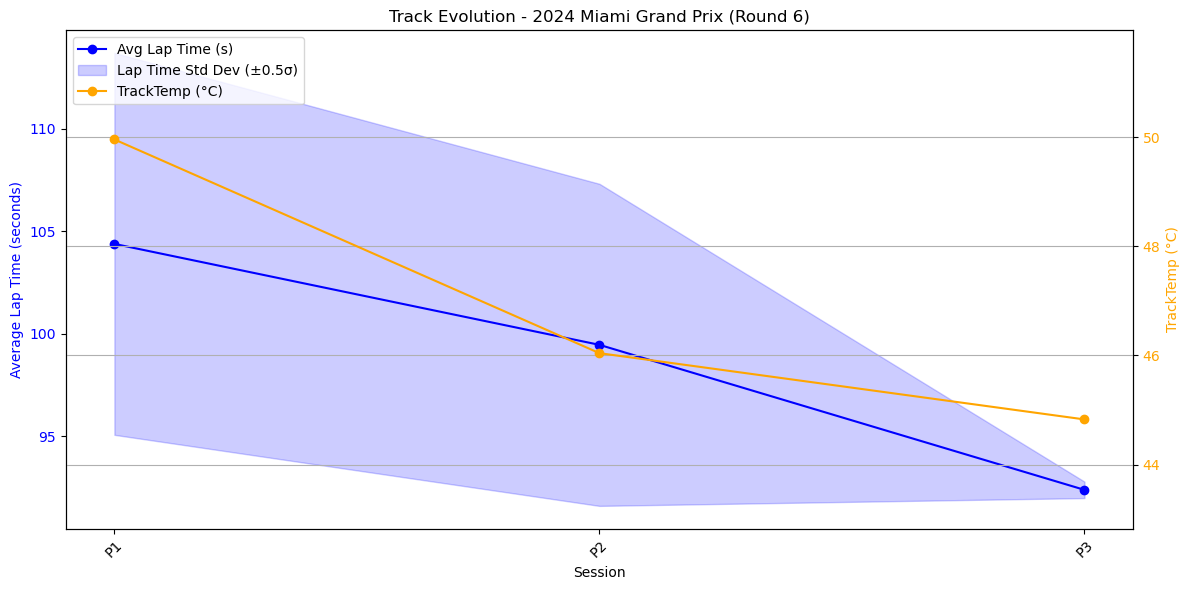

2025-03-18 20:05:33,872 - INFO - Track evolution rows: 3


Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_evolution.csv
Track evolution rows: 3
Track Evolution:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,104.385809,18.611590,299
1,Sprint Qualifying,99.465809,15.698561,110
2,Sprint,92.397932,0.802273,280


Step 9: Analyzing track characteristics...
Error fetching circuit info: Session type 'Practice 3' does not exist for this event

Track Characteristics Analysis for Miami Grand Prix:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Miami Grand Prix,High,Easy,3,Moderate,5.342646,Yes



Driver Fit to Track Characteristics (Top 10) - Miami Grand Prix:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
11,PIA,McLaren,345.0,33.270103,192.700792,1.495146,1.0
0,ALB,Williams,345.0,33.270543,192.698242,1.495107,2.0
13,RUS,Mercedes,344.0,32.058390,199.984311,1.215575,3.0
15,SAR,Williams,344.0,32.598141,196.673026,1.167616,4.0
5,HUL,Haas F1 Team,343.0,32.453288,197.550864,0.793250,5.0
16,STR,Aston Martin,343.0,33.974722,188.704269,0.658066,6.0
4,HAM,Mercedes,342.0,30.929833,207.281270,0.541378,7.0
18,VER,Red Bull Racing,342.0,31.918132,200.863108,0.453564,8.0
10,PER,Red Bull Racing,341.0,30.823978,207.993109,0.163547,9.0
8,NOR,McLaren,341.0,33.424704,191.809483,-0.067536,10.0


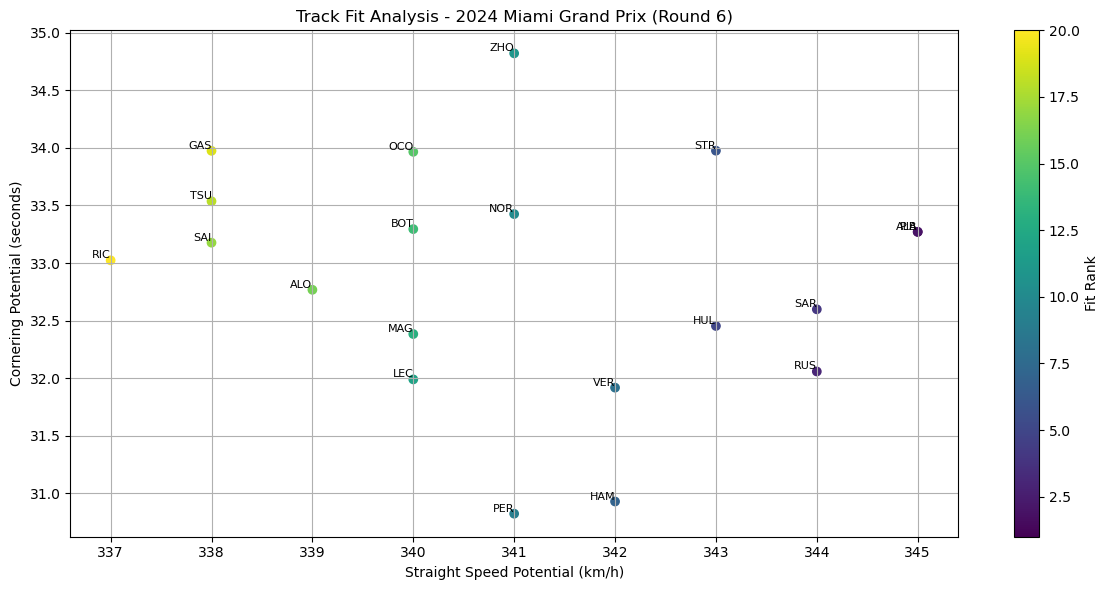

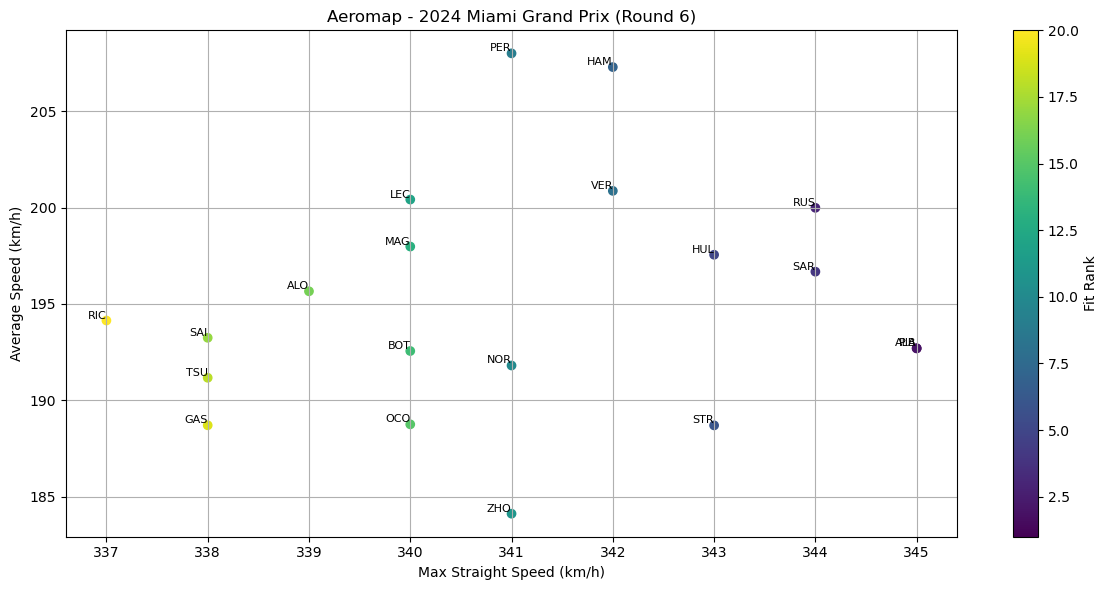

2025-03-18 20:05:34,515 - INFO - Track characteristics drivers rows: 20


Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_characteristics.csv
Saved driver fit data to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_characteristics_drivers.csv
Track characteristics drivers rows: 20
Track Characteristics Drivers (Top 5 by FitRank):


,Driver,Team,SpeedST,Sector1Time,Sector2Time,Sector3Time,LapTime,StraightSpeedPotential,CorneringPotential,AvgSpeed,StraightZScore,CorneringZScore,OverallFit,FitRank
11,PIA,McLaren,345.0,33.506128,37.272923,29.031256,99.810308,345.0,33.270103,192.700792,1.677059,-0.391615,1.495146,1.0
0,ALB,Williams,345.0,34.754086,37.664086,27.393457,99.811629,345.0,33.270543,192.698242,1.677059,-0.392060,1.495107,2.0
13,RUS,Mercedes,344.0,32.659229,36.511886,27.004057,96.175171,344.0,32.058390,199.984311,1.252487,0.832725,1.215575,3.0
15,SAR,Williams,344.0,33.808121,36.690000,27.296303,97.794424,344.0,32.598141,196.673026,1.252487,0.287349,1.167616,4.0
5,HUL,Haas F1 Team,343.0,33.010108,36.864676,27.485081,97.359865,343.0,32.453288,197.550864,0.827915,0.433712,0.793250,5.0


Step 10: Predicting race outcomes...
No pit_stop_loss found for Miami Grand Prix in file, using default: 25s

Qualifying Prediction:


,Driver,Team,LapTime,ExpectedLapTime,AdjustedLapTime,QualiPosition
0,NOR,McLaren,87.597,87.474,87.597,1
1,VER,Red Bull Racing,87.641,87.601,87.641,2
3,LEC,Ferrari,87.749,87.749,87.749,3
4,PIA,McLaren,88.056,87.813,87.813,4
2,PER,Red Bull Racing,87.865,87.742,87.865,5
7,RIC,RB,88.044,88.000,88.044,6
5,SAI,Ferrari,88.103,87.848,88.103,7
8,HUL,Haas F1 Team,88.330,88.149,88.149,8
6,ALO,Aston Martin,88.189,87.967,88.189,9
10,STR,Aston Martin,88.323,88.266,88.266,10


2025-03-18 20:05:34,551 - ERROR - Error processing Round 6: single positional indexer is out-of-bounds
2025-03-18 20:05:34,554 - INFO - Batch processing completed


Error processing Round 6: single positional indexer is out-of-bounds

=== Batch Processing Completed ===
Processed rounds: []


In [31]:
# Step 12: Batch Process for Rounds or Next Race
import os
import fastf1
import pandas as pd
import logging
from datetime import datetime

# Configure logging
BASE_DIR = os.getcwd()
log_dir = os.path.join(BASE_DIR, "logs")
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, f"batch_process_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# List of required functions from Cells 2-11
required_functions = [
    'get_target_event', 'download_practice_data', 'clean_and_aggregate_data',
    'compute_driver_performance', 'analyze_telemetry_metrics', 'investigate_sandbagging',
    'evaluate_track_evolution', 'analyze_track_characteristics', 'predict_race_outcomes',
    'generate_comprehensive_report', 'generate_summary_report'
]

def batch_process_rounds(year=2024, rounds=None):
    # Check if all required functions are defined
    missing_functions = [func for func in required_functions if func not in globals()]
    if missing_functions:
        error_msg = f"Error: The following functions are not defined: {missing_functions}. Please run Cells 2-11 first."
        logger.error(error_msg)
        print(error_msg)
        return {}

    fastf1.Cache.enable_cache(os.path.join(BASE_DIR, "fastf1_cache"))
    fastf1.set_log_level('ERROR')
    if rounds is None:
        mode = "next race"
        logger.info(f"Starting batch process for {year}, Next Race mode")
        print(f"\n=== Starting Batch Process for {year}, Next Race ===")
    else:
        mode = "specified rounds"
        logger.info(f"Starting batch process for {year}, Rounds {list(rounds)}")
        print(f"\n=== Starting Batch Process for {year}, Rounds {list(rounds)} ===")

    try:
        schedule = fastf1.get_event_schedule(year)
        logger.info(f"Fetched {year} schedule with {len(schedule)} events")
        print(f"Schedule fetched: {len(schedule)} events")
        display(schedule[['RoundNumber', 'EventName', 'EventDate']])
    except Exception as e:
        logger.error(f"Failed to fetch event schedule: {e}")
        print(f"Error fetching event schedule: {e}")
        return {}

    results = {}
    if rounds is None:
        target_info = get_target_event(manual_year=year, manual_round=None, skip_timing_validation=True)
        round_number = target_info['round']
        rounds_to_process = [round_number]
        logger.info(f"Next race identified: Round {round_number}")
        print(f"Next race identified: Round {round_number}")
    else:
        rounds_to_process = rounds

    for round_number in rounds_to_process:
        logger.info(f"Processing Round {round_number}")
        print(f"\n=== Processing {year} Round {round_number} ===")

        try:
            # Step 2
            print("Step 2: Fetching target event info...")
            if rounds is not None:
                target_info = get_target_event(manual_year=year, manual_round=round_number, skip_timing_validation=True)
            event_name = target_info['event_name']
            logger.info(f"Target event: {event_name} (Round {round_number})")
            print(f"Event: {event_name}")
            print(f"Target Info: {target_info}")

            # Step 3
            print("Step 3: Downloading practice data...")
            session_data = download_practice_data(target_info)
            if not session_data:
                logger.error(f"No session data for Round {round_number}")
                print("Error: No session data retrieved")
                continue
            logger.info(f"Session data keys: {list(session_data.keys())}")
            print(f"Session data retrieved for: {list(session_data.keys())}")
            for session, data in session_data.items():
                print(f"{session} - Laps: {len(data['laps'])}, Weather: {len(data['weather'])}, Indicators: {len(data['indicators'])}")

            # Step 4
            print("Step 4: Cleaning and aggregating data...")
            cleaned_data, driver_summary = clean_and_aggregate_data(target_info, session_data)
            if cleaned_data == {}:
                logger.error(f"Cleaning failed for Round {round_number}")
                print("Error: Cleaning failed, no cleaned data")
                continue
            logger.info(f"Cleaned data keys: {list(cleaned_data.keys())}")
            print(f"Cleaned data keys: {list(cleaned_data.keys())}")
            print("Driver Summary (Top 5):")
            display(driver_summary.head())

            # Step 5
            print("Step 5: Computing driver performance...")
            driver_performance_df = compute_driver_performance(cleaned_data, year, round_number)
            if driver_performance_df.empty:
                logger.error(f"Driver performance analysis failed for Round {round_number}")
                print("Error: Driver performance DataFrame is empty")
                continue
            logger.info(f"Driver performance rows: {len(driver_performance_df)}")
            print(f"Driver performance rows: {len(driver_performance_df)}")
            print("Driver Performance (Top 5 by FastestLapTime):")
            display(driver_performance_df.sort_values('FastestLapTime').head())

            # Step 6
            print("Step 6: Analyzing telemetry metrics...")
            telemetry_metrics_df = analyze_telemetry_metrics(target_info)
            if telemetry_metrics_df.empty:
                logger.warning(f"Telemetry metrics empty for Round {round_number}, proceeding")
                print("Warning: Telemetry metrics DataFrame is empty, proceeding")
            logger.info(f"Telemetry metrics rows: {len(telemetry_metrics_df)}")
            print(f"Telemetry metrics rows: {len(telemetry_metrics_df)}")
            if not telemetry_metrics_df.empty:
                print("Telemetry Metrics (Top 5 by MaxSpeed):")
                display(telemetry_metrics_df.sort_values('MaxSpeed', ascending=False).head())

            # Step 7
            print("Step 7: Investigating sandbagging...")
            sandbag_analysis_df = investigate_sandbagging(target_info)
            if sandbag_analysis_df.empty:
                logger.warning(f"Sandbagging analysis empty for Round {round_number}, proceeding")
                print("Warning: Sandbagging analysis DataFrame is empty, proceeding")
            logger.info(f"Sandbag analysis rows: {len(sandbag_analysis_df)}")
            print(f"Sandbag analysis rows: {len(sandbag_analysis_df)}")
            if not sandbag_analysis_df.empty:
                print("Potential Sandbaggers:")
                display(sandbag_analysis_df[sandbag_analysis_df['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False))

            # Step 8
            print("Step 8: Evaluating track evolution...")
            track_evolution_df = evaluate_track_evolution(target_info, cleaned_data)
            if track_evolution_df.empty:
                logger.warning(f"Track evolution empty for Round {round_number}, proceeding")
                print("Warning: Track evolution DataFrame is empty, proceeding")
            logger.info(f"Track evolution rows: {len(track_evolution_df)}")
            print(f"Track evolution rows: {len(track_evolution_df)}")
            if not track_evolution_df.empty:
                print("Track Evolution:")
                display(track_evolution_df)

            # Step 9
            print("Step 9: Analyzing track characteristics...")
            track_char_drivers_df = analyze_track_characteristics(target_info, cleaned_data)
            if track_char_drivers_df.empty:
                logger.warning(f"Track characteristics empty for Round {round_number}, proceeding")
                print("Warning: Track characteristics DataFrame is empty, proceeding")
            logger.info(f"Track characteristics drivers rows: {len(track_char_drivers_df)}")
            print(f"Track characteristics drivers rows: {len(track_char_drivers_df)}")
            if not track_char_drivers_df.empty:
                print("Track Characteristics Drivers (Top 5 by FitRank):")
                display(track_char_drivers_df.sort_values('FitRank').head())

            # Step 10
            print("Step 10: Predicting race outcomes...")
            quali_prediction_df, race_prediction_df, fastest_lap_pred = predict_race_outcomes(
                target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df,
                track_evolution_df, track_char_drivers_df
            )
            if quali_prediction_df.empty or race_prediction_df.empty:
                logger.error(f"Prediction failed for Round {round_number}")
                print("Error: Prediction DataFrames are empty")
                continue
            logger.info(f"Quali prediction rows: {len(quali_prediction_df)}, Race prediction rows: {len(race_prediction_df)}")
            print(f"Quali prediction rows: {len(quali_prediction_df)}, Race prediction rows: {len(race_prediction_df)}")
            print("Qualifying Prediction (Top 5):")
            display(quali_prediction_df.sort_values('QualiPosition').head())
            print("Race Prediction (Top 10):")
            display(race_prediction_df.sort_values('FinalPosition').head(10))
            print(f"Fastest Lap Prediction: {fastest_lap_pred}")

            # Step 10.5
            print("Step 10.5: Generating pre-qualifying report...")
            generate_comprehensive_report(
                target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df,
                track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred
            )
            logger.info(f"Pre-qualifying report generated for Round {round_number}")
            print(f"Pre-qualifying report generated: {os.path.join(BASE_DIR, 'reports', str(year), f'R{round_number}', f'{year}_R{round_number}_pre_qualifying_report.pdf')}")

            # Step 11
            print("Step 11: Generating summary report with actual results...")
            generate_summary_report(target_info, quali_prediction_df, race_prediction_df, fastest_lap_pred)
            logger.info(f"Summary report generated for Round {round_number}")
            print(f"Summary report saved: {os.path.join(BASE_DIR, 'raw_data', str(year), f'R{round_number}', f'{year}_R{round_number}_summary_results.csv')}")

            results[round_number] = {
                'target_info': target_info,
                'session_data': session_data,
                'cleaned_data': cleaned_data,
                'driver_summary': driver_summary,
                'driver_performance_df': driver_performance_df,
                'telemetry_metrics_df': telemetry_metrics_df,
                'sandbag_analysis_df': sandbag_analysis_df,
                'track_evolution_df': track_evolution_df,
                'track_char_drivers_df': track_char_drivers_df,
                'quali_prediction_df': quali_prediction_df,
                'race_prediction_df': race_prediction_df,
                'fastest_lap_pred': fastest_lap_pred
            }
            print(f"Results stored for Round {round_number}: {list(results[round_number].keys())}")

        except Exception as e:
            logger.error(f"Error processing Round {round_number}: {e}")
            print(f"Error processing Round {round_number}: {e}")
            continue

    logger.info("Batch processing completed")
    print("\n=== Batch Processing Completed ===")
    print(f"Processed rounds: {list(results.keys())}")
    return results

# Test with Round 4
print("Starting batch process...")
batch_results = batch_process_rounds(year=2024, rounds=range(5,7))

# Test with next race (commented out, uncomment to try after fixing)
# print("Starting batch process for next race...")
# batch_results = batch_process_rounds(year=2025)

In [32]:
# Step 13: Consolidate Data into SQLite Database
import os
import pandas as pd
import sqlite3
from datetime import datetime

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "raw_data")
DB_PATH = os.path.join(BASE_DIR, "f1_fantasy.db")

def consolidate_data(rounds=None, force_reimport=False):
    print(f"\n=== Consolidating Data into {DB_PATH} ===")
    if rounds is None:
        print("Auto-detecting all rounds from raw_data directory...")
    else:
        print(f"Processing specified rounds: {rounds}")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Table schemas (unchanged except for clarity)
    tables = {
        'events': """
            CREATE TABLE events (
                RoundNumber INTEGER,
                Year INTEGER,
                EventName TEXT,
                EventDate TEXT,
                Location TEXT,
                TrackLength REAL,
                AvgSpeed REAL,
                DownforceLevel TEXT,
                PRIMARY KEY (Year, RoundNumber)
            )
        """,
        'driver_performance': """
            CREATE TABLE driver_performance (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                FastestLapTime REAL,
                TheoreticalLapTime REAL,
                Sector1Time REAL,
                Sector2Time REAL,
                Sector3Time REAL,
                BasePace REAL,
                LapTimeVar REAL,
                DegradationSlope REAL,
                LapTimeGap REAL,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """,
        'telemetry_metrics': """
            CREATE TABLE telemetry_metrics (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                MaxSpeed REAL,
                ThrottleTime REAL,
                BrakingIntensity REAL,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """,
        'sandbag_analysis': """
            CREATE TABLE sandbag_analysis (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                FastestLapTime REAL,
                MaxSpeed REAL,
                ExpectedLapTime REAL,
                LapTimeDiscrepancy REAL,
                PredictedLapTime REAL,
                PredictionDiscrepancy REAL,
                SpeedRank REAL,
                LapTimeRank REAL,
                SandbagFlag INTEGER,
                ThrottleTime REAL,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """,
        'track_evolution': """
            CREATE TABLE track_evolution (
                RoundNumber INTEGER,
                Year INTEGER,
                Session TEXT,
                AvgLapTime REAL,
                StdLapTime REAL,
                LapCount INTEGER,
                PRIMARY KEY (Year, RoundNumber, Session)
            )
        """,
        'track_characteristics': """
            CREATE TABLE track_characteristics (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                SpeedST REAL,
                Sector1Time REAL,
                Sector2Time REAL,
                Sector3Time REAL,
                LapTime REAL,
                StraightSpeedPotential REAL,
                CorneringPotential REAL,
                AvgSpeed REAL,
                OverallFit REAL,
                FitRank REAL,
                StraightZScore REAL,
                CorneringZScore REAL,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """,
        'predictions': """
            CREATE TABLE predictions (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                QualiAdjustedLapTime REAL,
                QualiPosition INTEGER,
                RaceAdjustedRaceTime REAL,
                RaceFinalPosition INTEGER,
                FastestLapPred TEXT,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """,
        'results': """
            CREATE TABLE results (
                RoundNumber INTEGER,
                Year INTEGER,
                Driver TEXT,
                GridPosition INTEGER,
                FinalPosition INTEGER,
                BasePace REAL,
                DegradationSlope REAL,
                ActualRacePace REAL,
                ActualDegradationSlope REAL,
                ActualOvertakes REAL,
                NumPitStops REAL,
                TotalPitTime REAL,
                AvgPitTime REAL,
                PaceError REAL,
                DegError REAL,
                PositionError REAL,
                PitStopCountError REAL,
                PitTimeError REAL,
                FuelPenalty REAL,
                TrafficPenalty REAL,
                CompoundStrategy TEXT,
                StintLengths TEXT,
                ActualTyreStrategy TEXT,
                TotalPoints REAL,
                Team TEXT,
                PRIMARY KEY (Year, RoundNumber, Driver)
            )
        """
    }

    # Drop tables if force_reimport is True
    if force_reimport:
        for table_name in tables.keys():
            cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
            print(f"Dropped table: {table_name}")

    # Create tables
    for table_name, create_stmt in tables.items():
        cursor.execute(create_stmt)
        print(f"Created table: {table_name}")

    # Get existing rounds (empty after drop, kept for non-force runs)
    existing_rounds = pd.read_sql_query("SELECT Year, RoundNumber FROM events", conn)
    existing_rounds_set = set(zip(existing_rounds['Year'], existing_rounds['RoundNumber']))

    # Auto-detect rounds if not specified
    if rounds is None:
        years = [y for y in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, y)) and y.isdigit()]
        print(f"Detected years: {years}")
        rounds_to_process = []
        for year in years:
            year_dir = os.path.join(DATA_DIR, year)
            round_dirs = [d for d in os.listdir(year_dir) if d.startswith('R') and os.path.isdir(os.path.join(year_dir, d))]
            for round_dir in round_dirs:
                round_number = int(round_dir.replace('R', ''))
                rounds_to_process.append((int(year), round_number))
    else:
        rounds_to_process = [(2024, r) for r in rounds]

    for year, round_number in rounds_to_process:
        if (year, round_number) in existing_rounds_set and not force_reimport:
            print(f"Skipping Round {round_number} of {year} - already in database")
            continue

        round_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
        if not os.path.exists(round_dir):
            print(f"Warning: Directory {round_dir} not found, skipping")
            continue

        print(f"\nProcessing Round {round_number} of {year}...")

        # Events
        event_data = {
            'RoundNumber': round_number,
            'Year': year,
            'EventName': f"Round {round_number}",
            'EventDate': None,
            'Location': None,
            'TrackLength': None,
            'AvgSpeed': None,
            'DownforceLevel': None
        }
        try:
            track_char_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_track_characteristics.csv"))
            event_subset = track_char_df.iloc[0][['Track', 'LapLength', 'DownforceRequirement']].to_dict()
            event_data.update({
                'EventName': event_subset['Track'],
                'TrackLength': event_subset['LapLength'],
                'DownforceLevel': event_subset['DownforceRequirement']
            })
        except Exception as e:
            print(f"Warning: Could not enrich event data for Round {round_number} of {year}: {e}")
        pd.DataFrame([event_data]).to_sql('events', conn, if_exists='append', index=False)
        print(f"Loaded events: 1 row")

        # Driver Performance
        try:
            driver_performance_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_driver_performance.csv"))
            driver_performance_df['RoundNumber'] = round_number
            driver_performance_df['Year'] = year
            driver_performance_df.to_sql('driver_performance', conn, if_exists='append', index=False)
            print(f"Loaded driver_performance: {len(driver_performance_df)} rows")
        except Exception as e:
            print(f"Error loading driver_performance for Round {round_number} of {year}: {e}")

        # Telemetry Metrics
        try:
            telemetry_metrics_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_telemetry_metrics.csv"))
            telemetry_metrics_df['RoundNumber'] = round_number
            telemetry_metrics_df['Year'] = year
            telemetry_metrics_df.to_sql('telemetry_metrics', conn, if_exists='append', index=False)
            print(f"Loaded telemetry_metrics: {len(telemetry_metrics_df)} rows")
        except Exception as e:
            print(f"Error loading telemetry_metrics for Round {round_number} of {year}: {e}")

        # Sandbag Analysis
        try:
            sandbag_analysis_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_sandbag_analysis.csv"))
            sandbag_analysis_df['RoundNumber'] = round_number
            sandbag_analysis_df['Year'] = year
            sandbag_analysis_df.to_sql('sandbag_analysis', conn, if_exists='append', index=False)
            print(f"Loaded sandbag_analysis: {len(sandbag_analysis_df)} rows")
        except Exception as e:
            print(f"Error loading sandbag_analysis for Round {round_number} of {year}: {e}")

        # Track Evolution
        try:
            track_evolution_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_track_evolution.csv"))
            track_evolution_df['RoundNumber'] = round_number
            track_evolution_df['Year'] = year
            track_evolution_df.to_sql('track_evolution', conn, if_exists='append', index=False)
            print(f"Loaded track_evolution: {len(track_evolution_df)} rows")
        except Exception as e:
            print(f"Error loading track_evolution for Round {round_number} of {year}: {e}")

        # Track Characteristics
        try:
            track_char_drivers_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_track_characteristics_drivers.csv"))
            track_char_drivers_df['RoundNumber'] = round_number
            track_char_drivers_df['Year'] = year
            track_char_drivers_df.to_sql('track_characteristics', conn, if_exists='append', index=False)
            print(f"Loaded track_characteristics: {len(track_char_drivers_df)} rows")
        except Exception as e:
            print(f"Error loading track_characteristics for Round {round_number} of {year}: {e}")

        # Predictions
        try:
            quali_pred_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_quali_prediction.csv"))
            race_pred_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_race_prediction.csv"))
            print(f"Quali columns: {quali_pred_df.columns.tolist()}")
            print(f"Race columns: {race_pred_df.columns.tolist()}")
            predictions_df = quali_pred_df[['Driver', 'AdjustedLapTime', 'QualiPosition', 'Team']].merge(
                race_pred_df[['Driver', 'AdjustedRaceTime', 'FinalPosition']], on='Driver', how='outer'
            )
            predictions_df['RoundNumber'] = round_number
            predictions_df['Year'] = year
            predictions_df['FastestLapPred'] = None  # Placeholder
            predictions_df.rename(columns={
                'AdjustedLapTime': 'QualiAdjustedLapTime',
                'AdjustedRaceTime': 'RaceAdjustedRaceTime',  # Fixed renaming
                'FinalPosition': 'RaceFinalPosition'
            }, inplace=True)
            print(f"Predictions columns after merge: {predictions_df.columns.tolist()}")
            predictions_df.to_sql('predictions', conn, if_exists='append', index=False)
            print(f"Loaded predictions: {len(predictions_df)} rows")
        except Exception as e:
            print(f"Error loading predictions for Round {round_number} of {year}: {e}")

        # Results
        try:
            results_df = pd.read_csv(os.path.join(round_dir, f"{year}_R{round_number}_summary_results.csv"))
            results_df['RoundNumber'] = round_number
            results_df['Year'] = year
            results_df['TotalPoints'] = None  # Placeholder
            results_df.to_sql('results', conn, if_exists='append', index=False)
            print(f"Loaded results: {len(results_df)} rows")
        except Exception as e:
            print(f"Error loading results for Round {round_number} of {year}: {e}")

    # Verify table contents
    for table in tables.keys():
        count = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table}", conn).iloc[0]['count']
        print(f"Total rows in {table}: {count}")

    conn.commit()
    conn.close()
    print(f"\nData consolidation completed. Database saved at {DB_PATH}")

# Run with force reimport
consolidate_data(force_reimport=True)


=== Consolidating Data into C:\data\Dropbox\dev\F1\f1_fantasy.db ===
Auto-detecting all rounds from raw_data directory...
Dropped table: events
Dropped table: driver_performance
Dropped table: telemetry_metrics
Dropped table: sandbag_analysis
Dropped table: track_evolution
Dropped table: track_characteristics
Dropped table: predictions
Dropped table: results
Created table: events
Created table: driver_performance
Created table: telemetry_metrics
Created table: sandbag_analysis
Created table: track_evolution
Created table: track_characteristics
Created table: predictions
Created table: results
Detected years: ['2024']

Processing Round 1 of 2024...
Loaded events: 1 row
Loaded driver_performance: 20 rows
Loaded telemetry_metrics: 20 rows
Loaded sandbag_analysis: 20 rows
Loaded track_evolution: 3 rows
Loaded track_characteristics: 20 rows
Quali columns: ['Driver', 'LapTime', 'Team', 'ExpectedLapTime', 'LapTimeDiscrepancy', 'SandbagFlag', 'OverallFit', 'AdjustedLapTime', 'QualiPosition']
